In [1]:
import os
import shutil
from IPython.display import display, Image as DImage

import numpy
from numpy import array
from PIL import Image, ImageDraw


ncc_mode = True

width = 10
string_mode = True
top = 3
empty_threshold = 20
threshold = 3
delete_threshold = 200
bin_ratio = 600

binary_path = os.getcwd() + '/binary/'
found_path = os.getcwd() + '/found/'
cutted_path = os.getcwd() + '/cutted/'

bin_examples = []
names = []
nccors = []
results = []

RESULT = ''

In [2]:
def UI():
    global input_address, examples_path
    
    input_address = input('Input image address (default is test.png) :')
    imput_address = '\''+ input_address + '\''
    if input_address == '': input_address = 'test.png'

    examples_path = input('Input path to folder with samples (default is /examples/):')
    examples_path = '\''+ examples_path + '\''
    examples_path = os.getcwd() + '/examples/'
    
    erase_flag = input('Clear examples after the previous preprocessing? [y/N]:')
    #erase_flag = '\''+ erase_flag + '\''
    return erase_flag

In [3]:
def create_folders():
    global examples_path, binary_path, found_path, cutted_path
    if not os.path.exists(examples_path):
        os.mkdir('examples')
        examples_path = os.getcwd() + '/examples/'

    if not os.path.exists(binary_path):
        os.mkdir('binary')
        binary_path = os.getcwd() + '/binary/'

    if not os.path.exists(found_path):
        os.mkdir('found')
        found_path = os.getcwd() + '/found/'
    
    if not os.path.exists(cutted_path):
        os.mkdir('cutted')
        cutted_path = os.getcwd() + '/cutted/'

    for d, dirs, files in os.walk(examples_path):
            for f in dirs:
                if not os.path.exists(binary_path + f):
                    os.mkdir(binary_path+ f)
                    os.mkdir(cutted_path+ f)

In [4]:
def clean_folders():              
    if os.path.exists(binary_path):   
        shutil.rmtree(binary_path)
    
    if os.path.exists(found_path):
        shutil.rmtree(found_path)
        
    if os.path.exists(cutted_path):
        shutil.rmtree(cutted_path)

In [5]:
def address_helper(addr, mode):
    if mode == 'png': #after preprocessing the program only works with .png
        addr = addr[:-4]+'.png' 
        
    if mode == 'bin': #change the address of the folder to /binary
        addr = addr.replace('/examples/', '/binary/')
        
    if mode == 'cln': #leave only the name of file (letter)
        addr = addr[:-4]
        addr = addr.replace(binary_path, '')
        addr = addr.replace(found_path, '')
        addr = addr.replace(cutted_path, '')
    
    return addr

In [6]:
def binarization(input_img_addr):
    input_image  = Image.open(input_img_addr).convert('RGBA') #convert for .gif opening fix
    draw = ImageDraw.Draw(input_image)
     
    for i in range(input_image.size[0]):
        for j in range(input_image.size[1]):
            r, g, b, a = input_image.getpixel((i, j))
            if a == 0:
                r, g, b = 0, 0, 0
            if (r + g + b > bin_ratio): 
                r, g, b = 255, 255, 255
            else:
                r, g, b = 0, 0, 0 
            draw.point((i, j), (r, g, b))
    del draw
    
    input_img_addr = address_helper(input_img_addr, 'png')
    input_image.save(address_helper(input_img_addr, 'bin'), "PNG")

In [7]:
def separation(input_img_addr, threshold, empty_threshold):
    x0 = 0
    y0 = 0
    x1 = 0
    y1 = 0

    symbolsx = []
    symbolsy = []

    black = 0
    symbol = False
    empty = 0
    
    input_image = Image.open(input_img_addr).convert('L')
    
    for x in range(input_image.size[0]):
        for y in range(input_image.size[1]):
            pix = input_image.getpixel((x, y))
            if pix < 255:
                black += 1
        if symbol == True and black < threshold:
            empty += 1
        if symbol == False and black > threshold: 
            x0 = x
            symbol = True
        if symbol == True and black <= threshold and empty >= empty_threshold:
            x1 = x
            symbol = False
            symbolsx.append((x0, x1))
            empty = 0
        black = 0
    
    
    black = 0
    symbol = False
    
    if string_mode:
        for y in range(input_image.size[1]):
            for x in range(input_image.size[0]):
                pix = input_image.getpixel((x, y))
                if pix < 255:
                    black += 1
            if symbol == True and black < threshold:
                empty += 1
            if symbol == False and black > threshold:
                y0 = y
                symbol = True
            if symbol == True and black <= threshold and empty >= empty_threshold:
                y1 = y
                symbol = False
                symbolsy.append((y0, y1))
                empty = 0
            black = 0
    
    count = 0
    black = 0
    
    if symbolsx == []:
        symbolsx = [(0, input_image.size[0])] 
    if symbolsy == []:
        symbolsy = [(0, input_image.size[1])] 
        
    for y in symbolsy:
        for x in symbolsx:
            if count < 1000:
                temp = '{:03d}'.format(count)
                addr = 'found/' + str(temp) + '.png'
                input_image.crop((x[0], y[0], x[1], y[1])).save(addr, "PNG")
            count += 1

In [8]:
def delete_trash(threshold):
    images = os.listdir(found_path)
    for i in range(len(images)):
        try:
            black = 0
            input_image = Image.open(found_path + images[i])
            
            for x in range(input_image.size[0]):
                for y in range(input_image.size[1]):
                    pix = input_image.getpixel((x, y))
                    if pix != 255:
                        black += 1
            if black < threshold:
                os.remove(found_path + images[i])
        except IOError:
            pass        

In [9]:
def ncc(input_img_addr, example_addr): 
    global width
    input_image = Image.open(input_img_addr)
    wpercent = (width / float(input_image.size[0]))
    height = int((float(input_image.size[1]) * float(wpercent)))
    input_image = input_image.resize((width,height),Image.ANTIALIAS)
    example = Image.open(example_addr).resize((input_image.size[0],
                                               input_image.size[1]), 
                                              Image.ANTIALIAS)
    
    images = [input_image, example]
    vectors = []
    norms = []
    for image in images:
        vector = []
        for pixel in image.getdata():
            vector.append(numpy.mean(pixel))
        vectors.append(vector)
        norms.append(numpy.linalg.norm(vector, 2))
    a, b = vectors
    a_norm, b_norm = norms
    res = numpy.dot(a / a_norm, b / b_norm)
    return res

In [10]:
def compare_1to1(input_img_addr, example_addr):
    input_img_addr = found_path + input_img_addr
    naive_cut(input_img_addr)

    if ncc_mode:
        nccors.append(ncc(input_img_addr, example_addr))
    
    names.append(address_helper(example_addr, 'cln')) 

In [11]:
def compare_1toN(input_img_addr):
    global names, nccors, bin_examples
    names, nccors = [], []
    
    for i in range(len(bin_examples)):
        try:
            compare_1to1(input_img_addr, bin_examples[i])
        except IOError:
            pass

In [12]:
def result_1toN():
    global results
    global RESULT
    results = []
    
    if ncc_mode and nccors != []:
        results.append(names[nccors.index(max(nccors))])
    
    if results == []:
        results = ['']
        
    temp = max(set(results), key=results.count)
    display(DImage(filename=binary_path + temp + '.png'))
    for d, dirs, files in os.walk(examples_path):
        for f in dirs:
            temp = temp.replace(f, '')
            temp = temp.replace('/', '')  
    RESULT += temp 

In [13]:
def print_full(top, tmp_arr, flag):
    for i in range(top):
        if flag == 'max':
            tmp = max(tmp_arr)
        if flag == 'min':
            tmp = min(tmp_arr)    
        print(str(i+1)+". :"+str(names[tmp_arr.index(max(tmp_arr))])+" scores: "+str(max(tmp_arr)))
        tmp_arr.remove(max(tmp_arr))

In [14]:
def print_1toN():
    global top
    print('Results:')
    if ncc_mode and nccors != []:
        print('NCC mode:')
        print_full(top, nccors, 'max')
    print('Result:' + str(RESULT))

In [15]:
def naive_cut(img_address):
    img = Image.open(img_address).convert('L')
    arr = array(img)
    norm_arr = []
    find = False

    for c in range(4):
        black = 0
        find = False
        img = Image.fromarray(arr)
        for x in range(len(arr[:, 1])):
            if find:
                break
            for y in range(len(arr[1, :])):
                if arr[x, y] == 0:
                    black += 1
            if black >= 1:
                arr = numpy.delete(arr, numpy.s_[0:x], axis=0)
                find = True
                break
        arr = numpy.rot90(arr)
        c+=1
        
    
    img = Image.fromarray(arr)
    img.save(img_address.replace('binary', 'cutted'),"PNG")

In [16]:
def found_symbols():
    symbols = os.listdir(found_path)
    print('Found:')
    for i in sorted(symbols):
        try:
            display(DImage(filename=found_path + i))
        except IOError:
            pass

In [17]:
def main():
    erase_flag = UI()
    global RESULT, input_address, empty_threshold
    RESULT = ''
    try:
        binarization(input_address)
    except IOError:
        print('Error. Input image is not found.')
        return 0
    display(DImage(filename=input_address[:-4]+'.png'))
    input_address = address_helper(input_address, 'png')
    
    if erase_flag == 'y' or erase_flag == 'Y' or not os.path.exists(binary_path):
        clean_folders()
        create_folders()
        examples = []
        for d, dirs, files in os.walk(examples_path):
            for f in files:
                path = os.path.join(d, f)
                examples.append(path)

        for i in range(len(examples)):
            try:
                binarization(examples[i])
                naive_cut(address_helper(examples[i], 'bin'))
            except IOError:
                pass

        global bin_examples
        for d, dirs, files in os.walk(cutted_path):
            for f in files:
                path = os.path.join(d, f)
                bin_examples.append(path)
    else:
        pass
            
   
    separation(input_address, threshold, empty_threshold)
    delete_trash(delete_threshold)
        
    symbols = os.listdir(found_path)
    count = 0 
    for i in sorted(symbols):
        try:
            count += 1
            print('Processing:')
            display(DImage(filename=found_path + i))
            compare_1toN(i)
            result_1toN()
            print_1toN()
            print('Processed: ' + str(count) + '/' + str(len(symbols)))
        except IOError:
            pass
    print('Message: ' + RESULT)
    RESULT = ''

Input image address (default is test.png) :
Input path to folder with samples (default is /examples/):
Clear examples after the previous preprocessing? [y/N]:


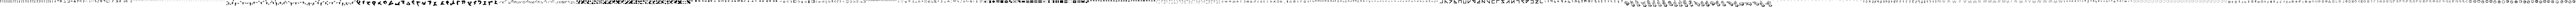

Processing:


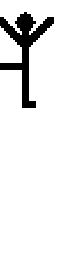

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


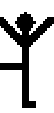

Results:
NCC mode:
1. :11/i scores: 1.0
2. :11/9 scores: 0.960396560012
3. :11/u scores: 0.926756412992
Result:i
Processed: 1/715
Processing:


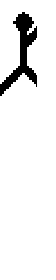

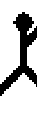

Results:
NCC mode:
1. :11/k scores: 1.0
2. :25/a scores: 0.871227729936
3. :28/l scores: 0.861680388671
Result:ik
Processed: 2/715
Processing:


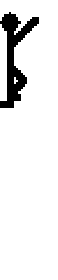

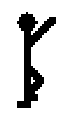

Results:
NCC mode:
1. :11/f scores: 1.0
2. :11/g scores: 0.900296823637
3. :17/d scores: 0.872264016154
Result:ikf
Processed: 3/715
Processing:


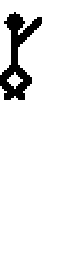

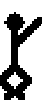

Results:
NCC mode:
1. :11/y scores: 1.0
2. :11/e scores: 0.892808726156
3. :11/u scores: 0.88426315135
Result:ikfy
Processed: 4/715
Processing:


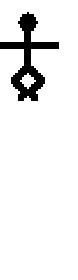

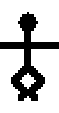

Results:
NCC mode:
1. :11/b scores: 1.0
2. :11/3 scores: 0.954083037056
3. :10/w scores: 0.919464613405
Result:ikfyb
Processed: 5/715
Processing:


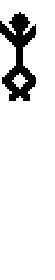

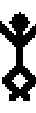

Results:
NCC mode:
1. :11/m scores: 1.0
2. :11/w scores: 0.835299463471
3. :11/g scores: 0.834229947819
Result:ikfybm
Processed: 6/715
Processing:


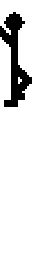

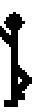

Results:
NCC mode:
1. :11/u scores: 1.0
2. :1/l scores: 0.880882102379
3. :5/b scores: 0.863956625261
Result:ikfybmu
Processed: 7/715
Processing:


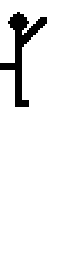

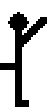

Results:
NCC mode:
1. :11/v scores: 1.0
2. :11/v scores: 0.936842582947
3. :11/i scores: 0.927808909364
Result:ikfybmuv
Processed: 8/715
Processing:


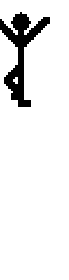

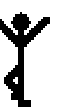

Results:
NCC mode:
1. :11/o scores: 1.0
2. :11/v scores: 0.936108965777
3. :11/d scores: 0.933224406105
Result:ikfybmuvo
Processed: 9/715
Processing:


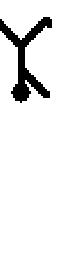

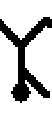

Results:
NCC mode:
1. :11/d scores: 1.0
2. :11/h scores: 0.937509263252
3. :11/c scores: 0.88409897446
Result:ikfybmuvod
Processed: 10/715
Processing:


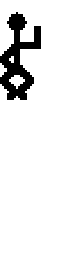

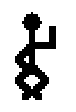

Results:
NCC mode:
1. :11/n scores: 1.0
2. :11/3 scores: 0.893392998034
3. :11/b scores: 0.859441544582
Result:ikfybmuvodn
Processed: 11/715
Processing:


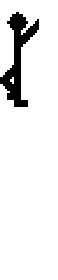

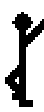

Results:
NCC mode:
1. :11/w scores: 1.0
2. :11/o scores: 0.930817269088
3. :11/a scores: 0.906043433071
Result:ikfybmuvodnw
Processed: 12/715
Processing:


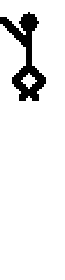

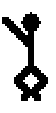

Results:
NCC mode:
1. :11/c scores: 1.0
2. :11/0 scores: 0.910582924926
3. :11/0 scores: 0.909612938969
Result:ikfybmuvodnwc
Processed: 13/715
Processing:


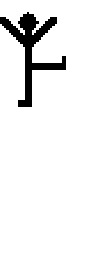

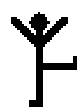

Results:
NCC mode:
1. :11/r scores: 1.0
2. :29/h scores: 0.931556483952
3. :11/i scores: 0.924973063378
Result:ikfybmuvodnwcr
Processed: 14/715
Processing:


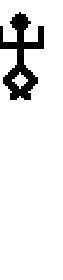

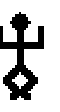

Results:
NCC mode:
1. :11/s scores: 1.0
2. :11/b scores: 0.9516946014
3. :11/d scores: 0.897109143584
Result:ikfybmuvodnwcrs
Processed: 15/715
Processing:


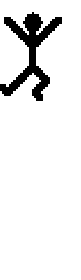

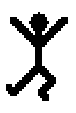

Results:
NCC mode:
1. :11/a scores: 1.0
2. :11/p scores: 0.904671447506
3. :11/z scores: 0.896930580842
Result:ikfybmuvodnwcrsa
Processed: 16/715
Processing:


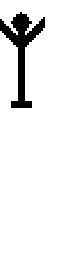

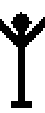

Results:
NCC mode:
1. :11/h scores: 1.0
2. :11/i scores: 0.959101625366
3. :30/p scores: 0.932125798997
Result:ikfybmuvodnwcrsah
Processed: 17/715
Processing:


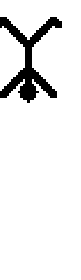

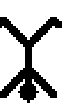

Results:
NCC mode:
1. :11/t scores: 1.0
2. :11/d scores: 0.941148237409
3. :29/p scores: 0.90762012861
Result:ikfybmuvodnwcrsaht
Processed: 18/715
Processing:


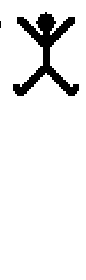

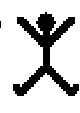

Results:
NCC mode:
1. :11/e scores: 1.0
2. :3/a scores: 0.914006199981
3. :25/v scores: 0.907855292653
Result:ikfybmuvodnwcrsahte
Processed: 19/715
Processing:


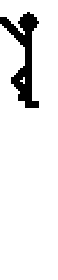

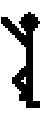

Results:
NCC mode:
1. :11/j scores: 1.0
2. :11/q scores: 0.911827823093
3. :11/0 scores: 0.895422618818
Result:ikfybmuvodnwcrsahtej
Processed: 20/715
Processing:


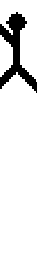

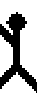

Results:
NCC mode:
1. :11/x scores: 1.0
2. :10/t scores: 0.903306095299
3. :29/p scores: 0.892324364605
Result:ikfybmuvodnwcrsahtejx
Processed: 21/715
Processing:


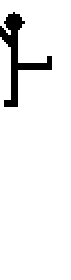

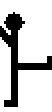

Results:
NCC mode:
1. :11/q scores: 1.0
2. :11/g scores: 0.910249516119
3. :2/r scores: 0.897974216034
Result:ikfybmuvodnwcrsahtejxq
Processed: 22/715
Processing:


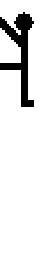

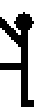

Results:
NCC mode:
1. :11/p scores: 1.0
2. :11/j scores: 0.914088183797
3. :21/y scores: 0.859346663592
Result:ikfybmuvodnwcrsahtejxqp
Processed: 23/715
Processing:


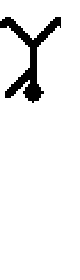

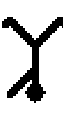

Results:
NCC mode:
1. :11/g scores: 1.0
2. :28/f scores: 0.907261516453
3. :3/g scores: 0.905081364672
Result:ikfybmuvodnwcrsahtejxqpg
Processed: 24/715
Processing:


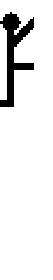

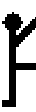

Results:
NCC mode:
1. :11/z scores: 1.0
2. :11/q scores: 0.904875201252
3. :11/f scores: 0.901421979972
Result:ikfybmuvodnwcrsahtejxqpgz
Processed: 25/715
Processing:


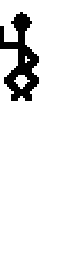

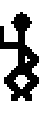

Results:
NCC mode:
1. :11/l scores: 1.0
2. :11/8 scores: 0.8729439348
3. :11/m scores: 0.841747411654
Result:ikfybmuvodnwcrsahtejxqpgzl
Processed: 26/715
Processing:


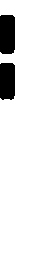

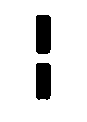

Results:
NCC mode:
1. :27/i scores: 1.0
2. :7/c scores: 0.693992355851
3. :7/t scores: 0.605213515115
Result:ikfybmuvodnwcrsahtejxqpgzli
Processed: 27/715
Processing:


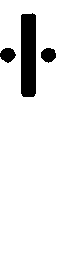

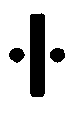

Results:
NCC mode:
1. :27/k scores: 1.0
2. :29/d scores: 0.93082834321
3. :10/a scores: 0.928195461286
Result:ikfybmuvodnwcrsahtejxqpgzlik
Processed: 28/715
Processing:


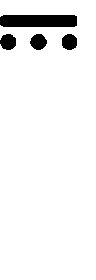

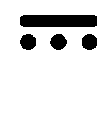

Results:
NCC mode:
1. :27/f scores: 1.0
2. :1/b scores: 0.845091009637
3. :1/a scores: 0.845024231025
Result:ikfybmuvodnwcrsahtejxqpgzlikf
Processed: 29/715
Processing:


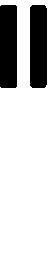

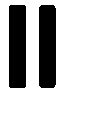

Results:
NCC mode:
1. :27/y scores: 1.0
2. :26/l scores: 0.961462842188
3. :7/h scores: 0.938214135219
Result:ikfybmuvodnwcrsahtejxqpgzlikfy
Processed: 30/715
Processing:


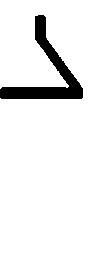

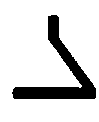

Results:
NCC mode:
1. :27/b scores: 0.99970556198
2. :12/m scores: 0.941688071406
3. :8/y scores: 0.924480779367
Result:ikfybmuvodnwcrsahtejxqpgzlikfyb
Processed: 31/715
Processing:


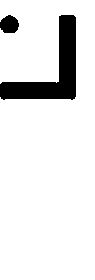

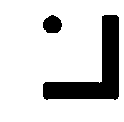

Results:
NCC mode:
1. :27/m scores: 1.0
2. :20/l scores: 0.956731774731
3. :23/w scores: 0.934687624071
Result:ikfybmuvodnwcrsahtejxqpgzlikfybm
Processed: 32/715
Processing:


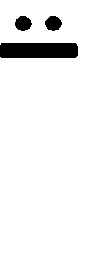

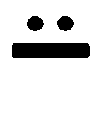

Results:
NCC mode:
1. :27/u scores: 1.0
2. :23/l scores: 0.87532869818
3. :23/t scores: 0.841772002269
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmu
Processed: 33/715
Processing:


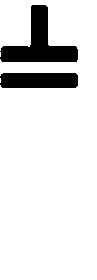

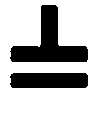

Results:
NCC mode:
1. :27/v scores: 1.0
2. :27/b scores: 0.85610562893
3. :20/y scores: 0.848756902353
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuv
Processed: 34/715
Processing:


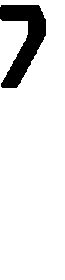

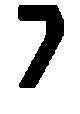

Results:
NCC mode:
1. :27/o scores: 1.0
2. :27/d scores: 0.945444020271
3. :3/q scores: 0.859231261644
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvo
Processed: 35/715
Processing:


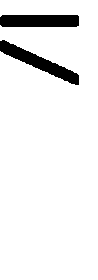

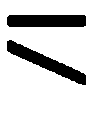

Results:
NCC mode:
1. :27/d scores: 1.0
2. :2/k scores: 0.89716320356
3. :2/f scores: 0.889130131189
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvod
Processed: 36/715
Processing:


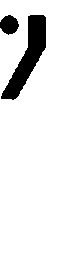

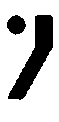

Results:
NCC mode:
1. :27/n scores: 1.0
2. :27/o scores: 0.945444020271
3. :27/e scores: 0.852763319515
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodn
Processed: 37/715
Processing:


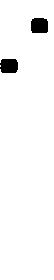

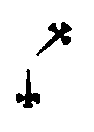

Results:
NCC mode:
1. :8/j scores: 0.975189598539
2. :2/r scores: 0.937924894177
3. :2/b scores: 0.934146928005
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnj
Processed: 38/715
Processing:


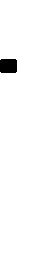

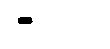

Results:
NCC mode:
1. :15/t scores: 0.74811660809
2. :7/e scores: 0.469630977313
3. :15/h scores: 0.469349623476
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjt
Processed: 39/715
Processing:


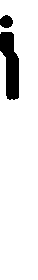

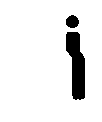

Results:
NCC mode:
1. :27/c scores: 1.0
2. :15/o scores: 0.743482859976
3. :14/o scores: 0.739651268634
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtc
Processed: 40/715
Processing:


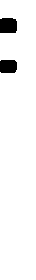

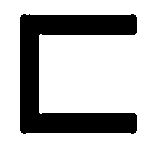

Results:
NCC mode:
1. :1/c scores: 0.82951787471
2. :1/p scores: 0.821089456944
3. :8/h scores: 0.818495179141
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcc
Processed: 41/715
Processing:


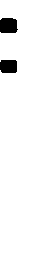

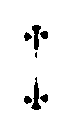

Results:
NCC mode:
1. :8/h scores: 0.826805519184
2. :8/w scores: 0.819978142343
3. :1/n scores: 0.819889856058
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcch
Processed: 42/715
Processing:


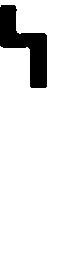

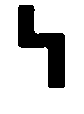

Results:
NCC mode:
1. :27/s scores: 1.0
2. :14/w scores: 0.844079816138
3. :13/p scores: 0.831441564996
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchs
Processed: 43/715
Processing:


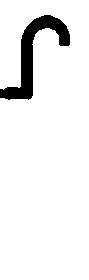

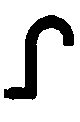

Results:
NCC mode:
1. :27/a scores: 1.0
2. :13/h scores: 0.914812151637
3. :8/t scores: 0.89525119743
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsa
Processed: 44/715
Processing:


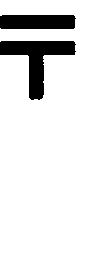

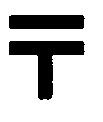

Results:
NCC mode:
1. :27/h scores: 1.0
2. :15/l scores: 0.872960998545
3. :3/g scores: 0.866527466701
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsah
Processed: 45/715
Processing:


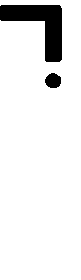

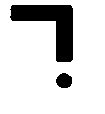

Results:
NCC mode:
1. :27/t scores: 0.999824681126
2. :1/h scores: 0.951821153397
3. :12/q scores: 0.918096294282
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsaht
Processed: 46/715
Processing:


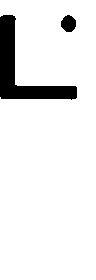

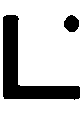

Results:
NCC mode:
1. :27/e scores: 1.0
2. :1/z scores: 0.972203690223
3. :12/o scores: 0.954128238585
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahte
Processed: 47/715
Processing:


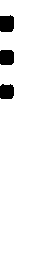

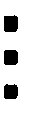

Results:
NCC mode:
1. :27/j scores: 1.0
2. :7/w scores: 0.955476955209
3. :2/k scores: 0.831126762294
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtej
Processed: 48/715
Processing:


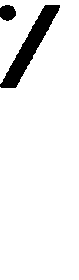

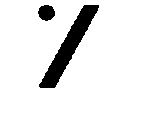

Results:
NCC mode:
1. :27/x scores: 0.998628303936
2. :24/s scores: 0.957854561825
3. :17/l scores: 0.925722038087
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejx
Processed: 49/715
Processing:


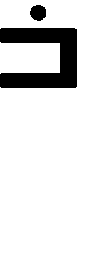

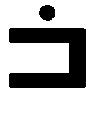

Results:
NCC mode:
1. :27/q scores: 1.0
2. :13/i scores: 0.857935433289
3. :20/z scores: 0.851057842322
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxq
Processed: 50/715
Processing:


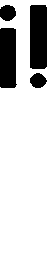

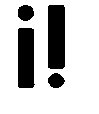

Results:
NCC mode:
1. :27/p scores: 1.0
2. :27/y scores: 0.905693746111
3. :26/z scores: 0.869434277455
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqp
Processed: 51/715
Processing:


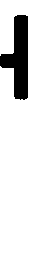

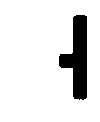

Results:
NCC mode:
1. :27/g scores: 1.0
2. :7/a scores: 0.87316930017
3. :7/i scores: 0.870223184588
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpg
Processed: 52/715
Processing:


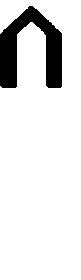

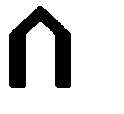

Results:
NCC mode:
1. :27/z scores: 1.0
2. :30/m scores: 0.890863183221
3. :14/n scores: 0.844858130628
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgz
Processed: 53/715
Processing:


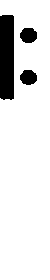

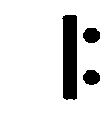

Results:
NCC mode:
1. :27/l scores: 0.992426959498
2. :23/e scores: 0.902089495273
3. :30/g scores: 0.874398473154
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzl
Processed: 54/715
Processing:


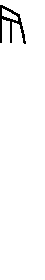

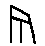

Results:
NCC mode:
1. :29/y scores: 1.0
2. :29/z scores: 0.953483025453
3. :29/z scores: 0.895995595889
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzly
Processed: 55/715
Processing:


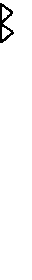

Results:
NCC mode:
1. :29/b scores: 1.0
2. :18/d scores: 0.915554252131
3. :29/uv scores: 0.888453772496
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlyb
Processed: 56/715
Processing:


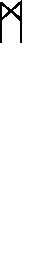

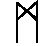

Results:
NCC mode:
1. :29/m scores: 1.0
2. :29/t scores: 0.96415949673
3. :16/s scores: 0.930806281644
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybm
Processed: 57/715
Processing:


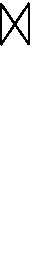

Results:
NCC mode:
1. :29/d scores: 1.0
2. :7/u scores: 0.939116050267
3. :16/j scores: 0.938126982412
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmd
Processed: 58/715
Processing:


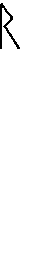

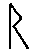

Results:
NCC mode:
1. :29/r scores: 1.0
2. :29/c scores: 0.948059121245
3. :29/r scores: 0.918392452882
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdr
Processed: 59/715
Processing:


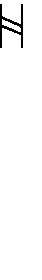

Results:
NCC mode:
1. :29/h scores: 1.0
2. :16/a scores: 0.942234902041
3. :29/s scores: 0.909124353135
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrh
Processed: 60/715
Processing:


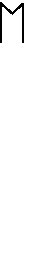

Results:
NCC mode:
1. :29/e scores: 1.0
2. :29/m scores: 0.965499724947
3. :16/s scores: 0.962524808411
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhe
Processed: 61/715
Processing:


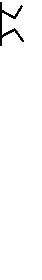

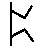

Results:
NCC mode:
1. :29/p scores: 1.0
2. :16/u scores: 0.916561567425
3. :29/d scores: 0.910771328232
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhep
Processed: 62/715
Processing:


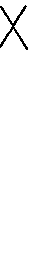

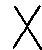

Results:
NCC mode:
1. :29/g scores: 0.993163328924
2. :16/j scores: 0.950137878229
3. :28/j scores: 0.937438020482
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepg
Processed: 63/715
Processing:


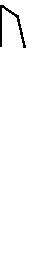

Results:
NCC mode:
1. :29/uv scores: 1.0
2. :29/y scores: 0.952776091813
3. :29/z scores: 0.935684382406
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguv
Processed: 64/715
Processing:


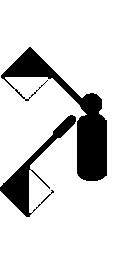

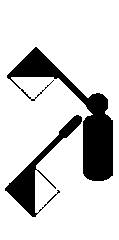

Results:
NCC mode:
1. :14/i scores: 0.999685680558
2. :8/p scores: 0.918997025159
3. :14/w scores: 0.917758648592
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvi
Processed: 65/715
Processing:


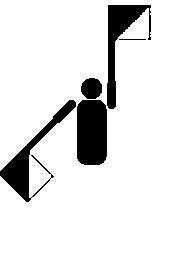

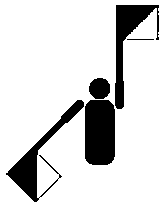

Results:
NCC mode:
1. :14/k scores: 0.999562707202
2. :6/j scores: 0.934052035872
3. :6/p scores: 0.933343480403
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvik
Processed: 66/715
Processing:


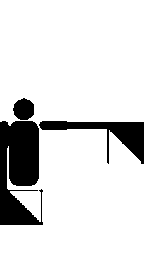

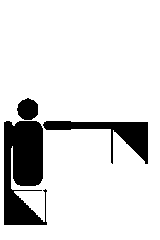

Results:
NCC mode:
1. :14/f scores: 1.0
2. :29/w scores: 0.931426601963
3. :29/uv scores: 0.929490049093
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikf
Processed: 67/715
Processing:


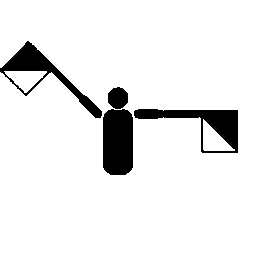

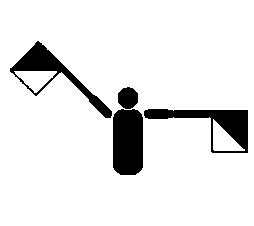

Results:
NCC mode:
1. :14/y scores: 1.0
2. :14/m scores: 0.970565966304
3. :28/y scores: 0.962463782615
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfy
Processed: 68/715
Processing:


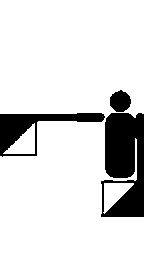

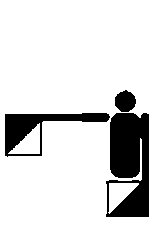

Results:
NCC mode:
1. :14/b scores: 1.0
2. :14/w scores: 0.925189594507
3. :14/s scores: 0.92299866288
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfyb
Processed: 69/715
Processing:


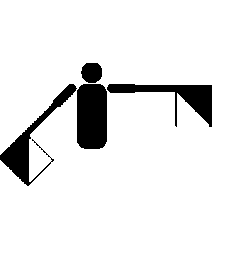

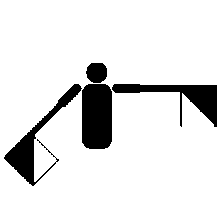

Results:
NCC mode:
1. :14/m scores: 0.999892829125
2. :14/z scores: 0.959859956451
3. :29/t scores: 0.946137075366
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybm
Processed: 70/715
Processing:


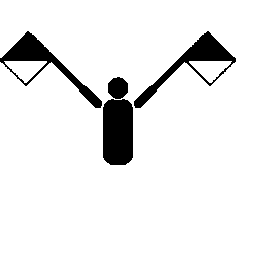

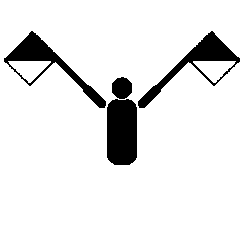

Results:
NCC mode:
1. :14/u scores: 1.0
2. :8/i scores: 0.981227594438
3. :28/y scores: 0.977258358466
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmu
Processed: 71/715
Processing:


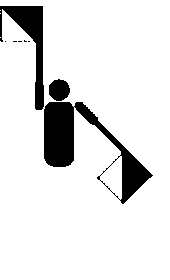

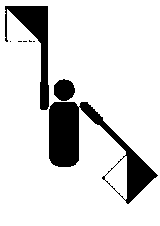

Results:
NCC mode:
1. :14/v scores: 1.0
2. :26/m scores: 0.9537829411
3. :26/p scores: 0.94391022172
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuv
Processed: 72/715
Processing:


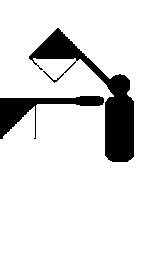

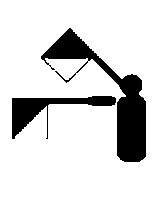

Results:
NCC mode:
1. :14/o scores: 1.0
2. :25/j scores: 0.913964129476
3. :14/n scores: 0.909864855339
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvo
Processed: 73/715
Processing:


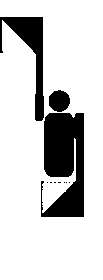

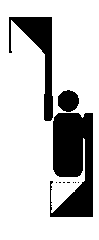

Results:
NCC mode:
1. :14/d scores: 1.0
2. :15/b scores: 0.892564336435
3. :14/w scores: 0.888192194307
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvod
Processed: 74/715
Processing:


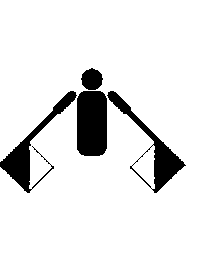

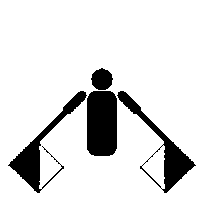

Results:
NCC mode:
1. :14/n scores: 0.999407542686
2. :29/z scores: 0.936894373463
3. :10/t scores: 0.936878765102
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodn
Processed: 75/715
Processing:


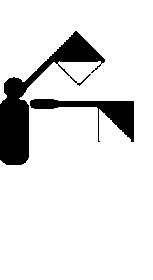

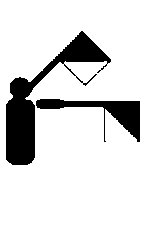

Results:
NCC mode:
1. :14/w scores: 1.0
2. :2/l scores: 0.912579191302
3. :14/t scores: 0.909603773669
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnw
Processed: 76/715
Processing:


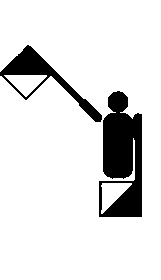

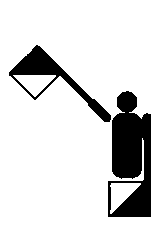

Results:
NCC mode:
1. :14/c scores: 1.0
2. :2/t scores: 0.924575091668
3. :15/y scores: 0.921615674383
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwc
Processed: 77/715
Processing:


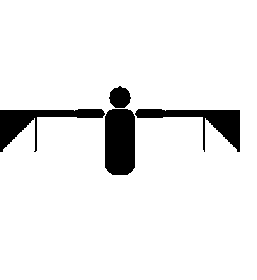

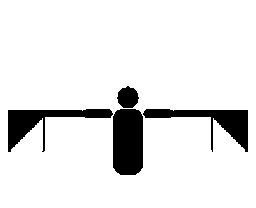

Results:
NCC mode:
1. :14/r scores: 1.0
2. :18/h scores: 0.987964298181
3. :10/h scores: 0.974200981828
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcr
Processed: 78/715
Processing:


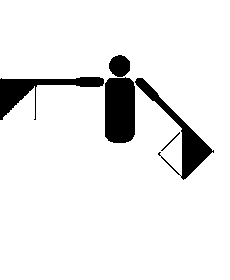

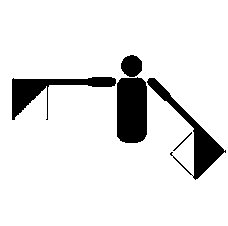

Results:
NCC mode:
1. :14/s scores: 1.0
2. :25/u scores: 0.953487932447
3. :25/g scores: 0.953302242767
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrs
Processed: 79/715
Processing:


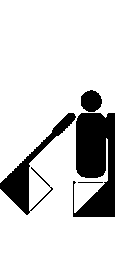

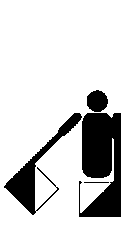

Results:
NCC mode:
1. :14/a scores: 0.998575803768
2. :14/b scores: 0.891218362805
3. :14/w scores: 0.868949321583
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsa
Processed: 80/715
Processing:


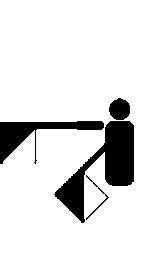

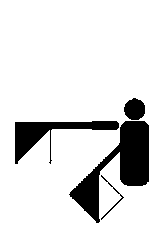

Results:
NCC mode:
1. :14/h scores: 1.0
2. :14/b scores: 0.922047506842
3. :6/d scores: 0.9073060734
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsah
Processed: 81/715
Processing:


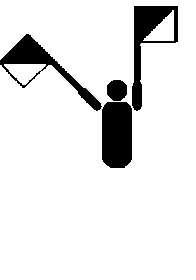

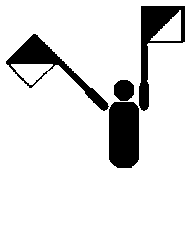

Results:
NCC mode:
1. :14/t scores: 0.999945325215
2. :14/q scores: 0.963127063023
3. :6/q scores: 0.937642535897
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsaht
Processed: 82/715
Processing:


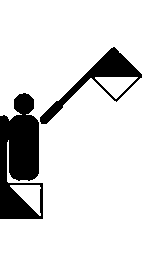

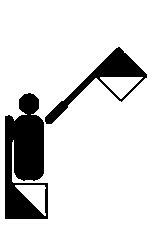

Results:
NCC mode:
1. :14/e scores: 1.0
2. :4/l scores: 0.926809560521
3. :2/c scores: 0.925872158109
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahte
Processed: 83/715
Processing:


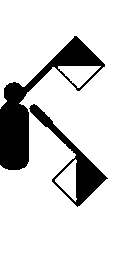

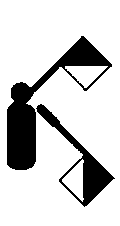

Results:
NCC mode:
1. :14/x scores: 1.0
2. :14/e scores: 0.911624234964
3. :25/j scores: 0.906555503588
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtex
Processed: 84/715
Processing:


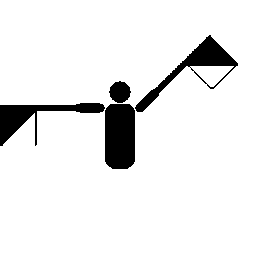

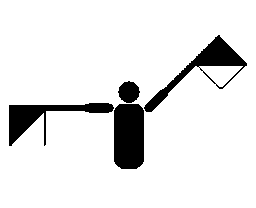

Results:
NCC mode:
1. :14/q scores: 1.0
2. :14/u scores: 0.972832001957
3. :28/y scores: 0.964359352416
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexq
Processed: 85/715
Processing:


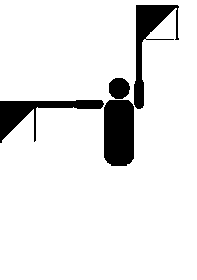

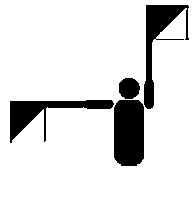

Results:
NCC mode:
1. :14/p scores: 1.0
2. :14/t scores: 0.966477797279
3. :6/q scores: 0.947530982109
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqp
Processed: 86/715
Processing:


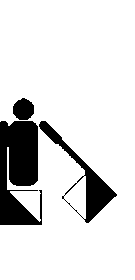

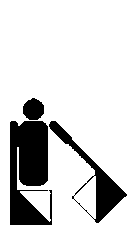

Results:
NCC mode:
1. :14/g scores: 1.0
2. :14/f scores: 0.903882990699
3. :18/o scores: 0.89324938852
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpg
Processed: 87/715
Processing:


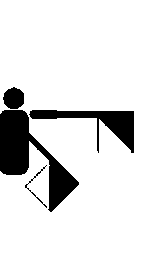

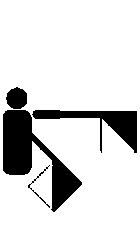

Results:
NCC mode:
1. :14/z scores: 1.0
2. :14/f scores: 0.921627479148
3. :29/l scores: 0.904893911808
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgz
Processed: 88/715
Processing:


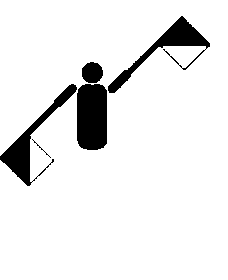

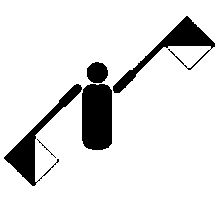

Results:
NCC mode:
1. :14/l scores: 0.999921903274
2. :14/m scores: 0.951532261943
3. :5/p scores: 0.950636777308
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzl
Processed: 89/715
Processing:


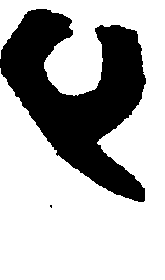

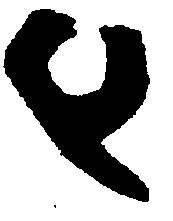

Results:
NCC mode:
1. :17/i scores: 0.999719281452
2. :17/f scores: 0.824244190871
3. :17/e scores: 0.823630618204
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzli
Processed: 90/715
Processing:


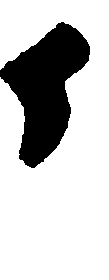

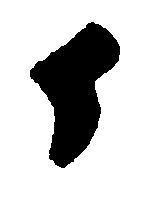

Results:
NCC mode:
1. :17/k scores: 1.0
2. :17/x scores: 0.928471669574
3. :17/p scores: 0.802769231969
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlik
Processed: 91/715
Processing:


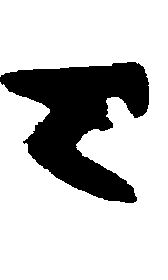

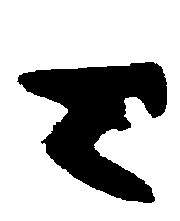

Results:
NCC mode:
1. :17/f scores: 0.999813504316
2. :17/j scores: 0.858152827781
3. :3/p scores: 0.849253238253
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikf
Processed: 92/715
Processing:


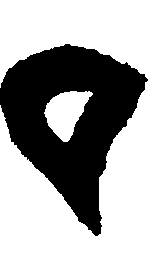

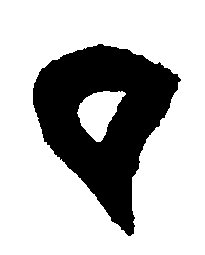

Results:
NCC mode:
1. :17/y scores: 1.0
2. :17/a scores: 0.867463860712
3. :3/p scores: 0.856055658867
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfy
Processed: 93/715
Processing:


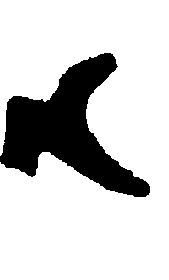

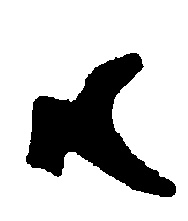

Results:
NCC mode:
1. :17/b scores: 1.0
2. :30/w scores: 0.899356405978
3. :30/i scores: 0.889375944412
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfyb
Processed: 94/715
Processing:


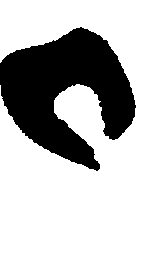

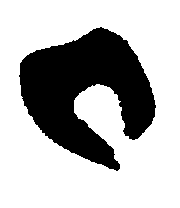

Results:
NCC mode:
1. :17/m scores: 0.999654817725
2. :30/d scores: 0.840555112148
3. :17/a scores: 0.810583536061
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybm
Processed: 95/715
Processing:


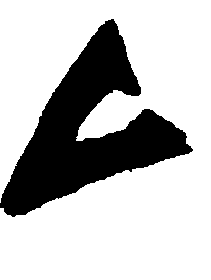

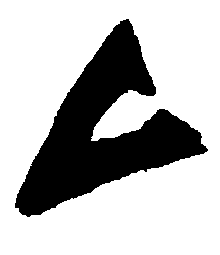

Results:
NCC mode:
1. :17/u scores: 1.0
2. :17/h scores: 0.863861431343
3. :11/3 scores: 0.858917370662
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmu
Processed: 96/715
Processing:


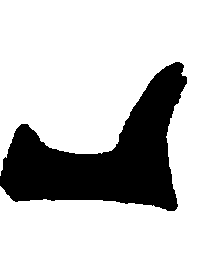

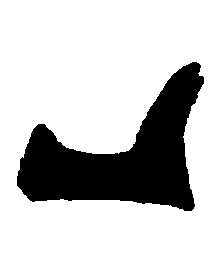

Results:
NCC mode:
1. :17/v scores: 1.0
2. :14/p scores: 0.848517446449
3. :9/h scores: 0.842808917753
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuv
Processed: 97/715
Processing:


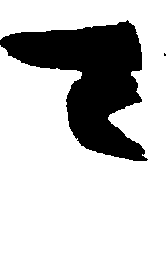

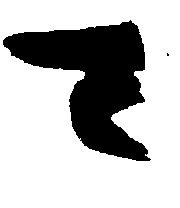

Results:
NCC mode:
1. :17/o scores: 1.0
2. :17/c scores: 0.90354427059
3. :3/p scores: 0.898362305359
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvo
Processed: 98/715
Processing:


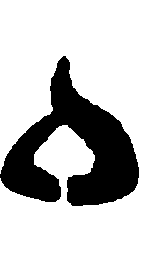

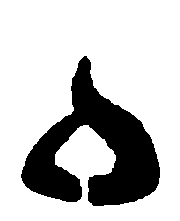

Results:
NCC mode:
1. :17/d scores: 1.0
2. :12/m scores: 0.852761529447
3. :27/y scores: 0.845831535315
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvod
Processed: 99/715
Processing:


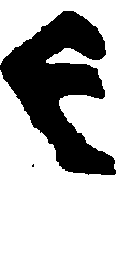

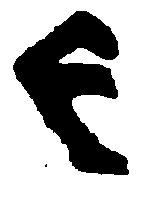

Results:
NCC mode:
1. :17/n scores: 1.0
2. :17/a scores: 0.867602688603
3. :17/y scores: 0.818668416859
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodn
Processed: 100/715
Processing:


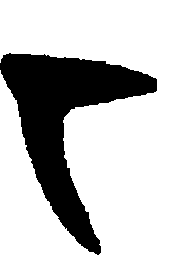

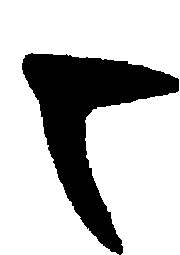

Results:
NCC mode:
1. :17/w scores: 1.0
2. :3/c scores: 0.888245010977
3. :11/f scores: 0.886352125303
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnw
Processed: 101/715
Processing:


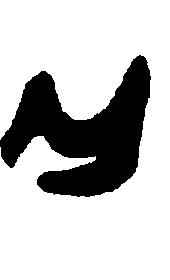

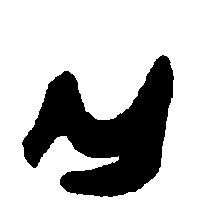

Results:
NCC mode:
1. :17/c scores: 0.999645547415
2. :20/w scores: 0.843557208488
3. :8/k scores: 0.819533308863
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwc
Processed: 102/715
Processing:


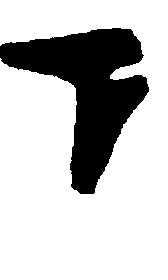

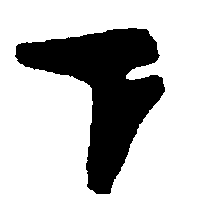

Results:
NCC mode:
1. :17/r scores: 0.999899924526
2. :17/o scores: 0.89976704599
3. :11/j scores: 0.877234732076
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcr
Processed: 103/715
Processing:


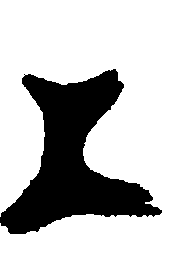

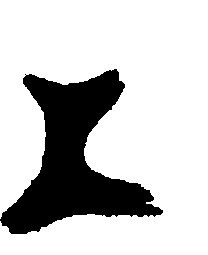

Results:
NCC mode:
1. :17/s scores: 0.99977100428
2. :17/s scores: 0.897339710452
3. :18/z scores: 0.887770402649
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrs
Processed: 104/715
Processing:


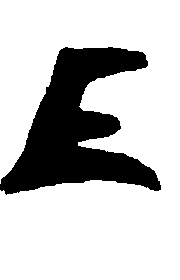

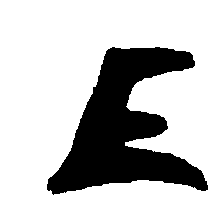

Results:
NCC mode:
1. :17/a scores: 1.0
2. :17/s scores: 0.899928064405
3. :11/7 scores: 0.859145206523
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsa
Processed: 105/715
Processing:


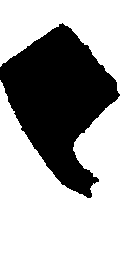

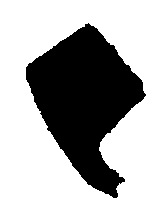

Results:
NCC mode:
1. :17/h scores: 1.0
2. :17/n scores: 0.867602688603
3. :17/y scores: 0.865381051319
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsah
Processed: 106/715
Processing:


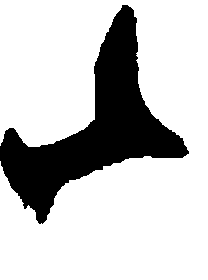

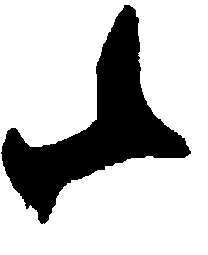

Results:
NCC mode:
1. :17/t scores: 0.999906409687
2. :25/s scores: 0.881539064031
3. :11/3 scores: 0.877133320584
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsaht
Processed: 107/715
Processing:


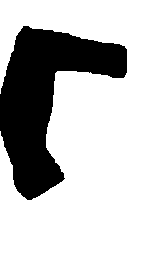

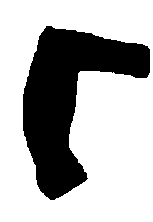

Results:
NCC mode:
1. :17/e scores: 1.0
2. :30/z scores: 0.849761134234
3. :17/g scores: 0.846958155364
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahte
Processed: 108/715
Processing:


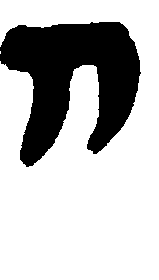

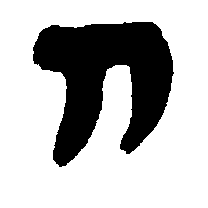

Results:
NCC mode:
1. :17/j scores: 1.0
2. :21/z scores: 0.81162937361
3. :17/g scores: 0.810377844572
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtej
Processed: 109/715
Processing:


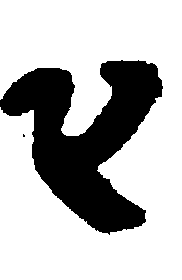

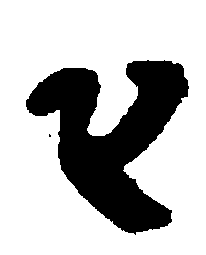

Results:
NCC mode:
1. :17/x scores: 1.0
2. :17/f scores: 0.856917670797
3. :17/f scores: 0.85099461598
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejx
Processed: 110/715
Processing:


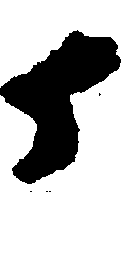

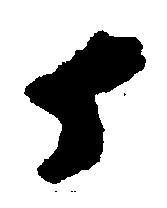

Results:
NCC mode:
1. :17/q scores: 0.999734104838
2. :17/k scores: 0.927035174278
3. :17/p scores: 0.865555483757
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxq
Processed: 111/715
Processing:


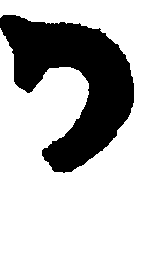

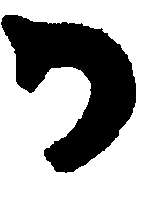

Results:
NCC mode:
1. :17/p scores: 0.999721872406
2. :18/m scores: 0.830781731913
3. :17/r scores: 0.82289864279
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqp
Processed: 112/715
Processing:


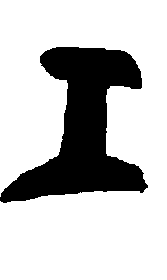

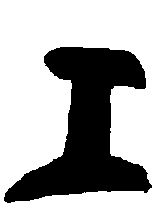

Results:
NCC mode:
1. :17/g scores: 1.0
2. :11/e scores: 0.873144032639
3. :11/k scores: 0.871882835516
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 113/715
Processing:


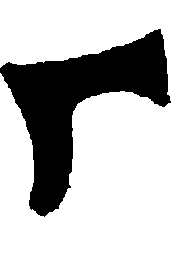

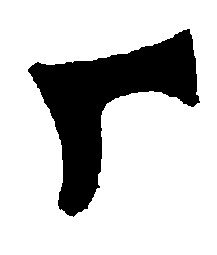

Results:
NCC mode:
1. :17/z scores: 0.999809610586
2. :5/q scores: 0.874435016923
3. :15/f scores: 0.874028600983
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgz
Processed: 114/715
Processing:


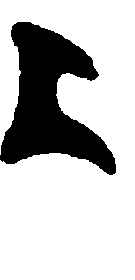

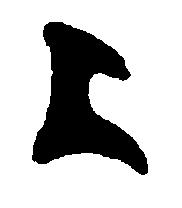

Results:
NCC mode:
1. :17/l scores: 1.0
2. :17/s scores: 0.871326668668
3. :11/x scores: 0.850920404134
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 115/715
Processing:


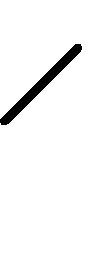

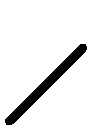

Results:
NCC mode:
1. :16/i scores: 1.0
2. :24/s scores: 0.985350111283
3. :5/p scores: 0.966985089939
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzli
Processed: 116/715
Processing:


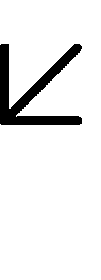

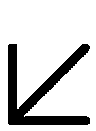

Results:
NCC mode:
1. :16/k scores: 1.0
2. :16/u scores: 0.940256098109
3. :16/n scores: 0.939060212639
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlik
Processed: 117/715
Processing:


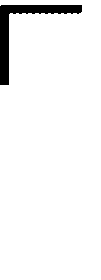

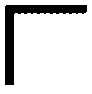

Results:
NCC mode:
1. :16/f scores: 1.0
2. :1/c scores: 0.977259027089
3. :12/p scores: 0.974750533633
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikf
Processed: 118/715
Processing:


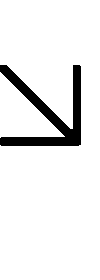

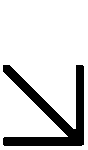

Results:
NCC mode:
1. :16/y scores: 1.0
2. :16/r scores: 0.946736225176
3. :16/t scores: 0.930064597684
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfy
Processed: 119/715
Processing:


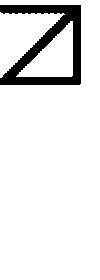

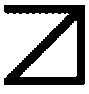

Results:
NCC mode:
1. :16/b scores: 1.0
2. :16/g scores: 0.945562479696
3. :16/o scores: 0.938456679886
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfyb
Processed: 120/715
Processing:


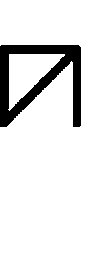

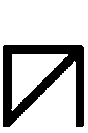

Results:
NCC mode:
1. :16/m scores: 1.0
2. :16/q scores: 0.938179408881
3. :3/n scores: 0.896849836321
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybm
Processed: 121/715
Processing:


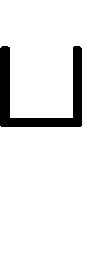

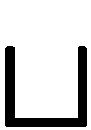

Results:
NCC mode:
1. :16/u scores: 1.0
2. :1/m scores: 0.967021336701
3. :12/r scores: 0.951652849104
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmu
Processed: 122/715
Processing:


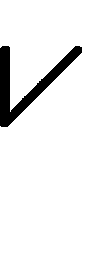

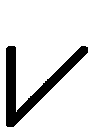

Results:
NCC mode:
1. :16/v scores: 1.0
2. :1/u scores: 0.972860392412
3. :16/q scores: 0.951727019065
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuv
Processed: 123/715
Processing:


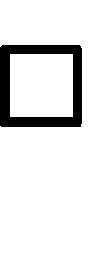

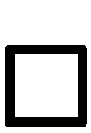

Results:
NCC mode:
1. :16/o scores: 1.0
2. :12/r scores: 0.983247498065
3. :12/v scores: 0.964993543214
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvo
Processed: 124/715
Processing:


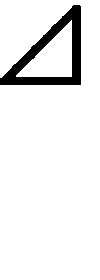

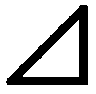

Results:
NCC mode:
1. :16/d scores: 0.999531058784
2. :16/s scores: 0.956806537635
3. :1/v scores: 0.951121523469
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvod
Processed: 125/715
Processing:


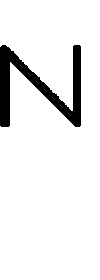

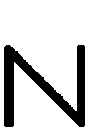

Results:
NCC mode:
1. :16/n scores: 1.0
2. :1/d scores: 0.948331650759
3. :29/d scores: 0.940544568307
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodn
Processed: 126/715
Processing:


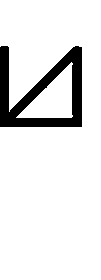

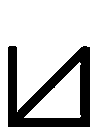

Results:
NCC mode:
1. :16/w scores: 1.0
2. :16/k scores: 0.934319259792
3. :16/m scores: 0.928385603889
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnw
Processed: 127/715
Processing:


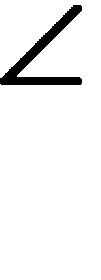

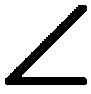

Results:
NCC mode:
1. :16/c scores: 1.0
2. :16/i scores: 0.957266672823
3. :24/r scores: 0.949760419593
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwc
Processed: 128/715
Processing:


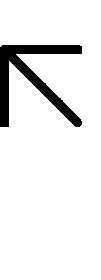

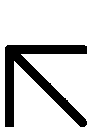

Results:
NCC mode:
1. :16/r scores: 1.0
2. :16/p scores: 0.938605820185
3. :16/f scores: 0.931935143132
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcr
Processed: 129/715
Processing:


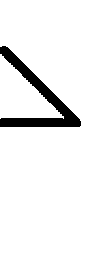

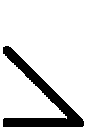

Results:
NCC mode:
1. :16/s scores: 1.0
2. :16/y scores: 0.946736225176
3. :28/l scores: 0.906258556883
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrs
Processed: 130/715
Processing:


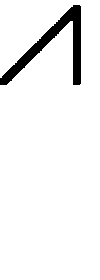

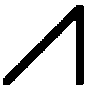

Results:
NCC mode:
1. :16/a scores: 1.0
2. :1/s scores: 0.963618143368
3. :16/d scores: 0.955797707699
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsa
Processed: 131/715
Processing:


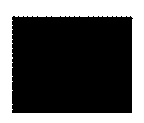

Results:
NCC mode:
1. :7/e scores: 0.280824356772
2. :15/h scores: 0.239196674479
3. :15/h scores: 0.185058622355
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsae
Processed: 132/715
Processing:


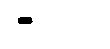

Results:
NCC mode:
1. :15/t scores: 0.189123995917
2. :27/i scores: 0.173715295306
3. :18/t scores: 0.151077970347
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaet
Processed: 133/715
Processing:


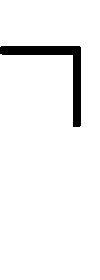

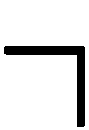

Results:
NCC mode:
1. :16/t scores: 1.0
2. :1/h scores: 0.961968629679
3. :12/q scores: 0.953811064719
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaett
Processed: 134/715
Processing:


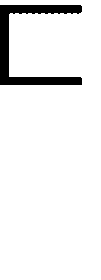

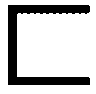

Results:
NCC mode:
1. :16/e scores: 1.0
2. :16/f scores: 0.952899150556
3. :16/g scores: 0.948181174499
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaette
Processed: 135/715
Processing:


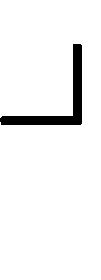

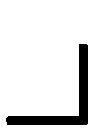

Results:
NCC mode:
1. :16/j scores: 1.0
2. :20/l scores: 0.974533950692
3. :12/n scores: 0.96180449
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettej
Processed: 136/715
Processing:


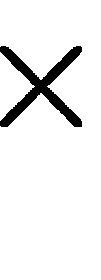

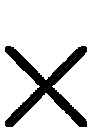

Results:
NCC mode:
1. :16/x scores: 1.0
2. :7/u scores: 0.988260864151
3. :29/g scores: 0.968004768372
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejx
Processed: 137/715
Processing:


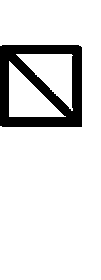

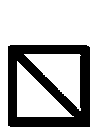

Results:
NCC mode:
1. :16/q scores: 1.0
2. :16/o scores: 0.921594234561
3. :12/y scores: 0.912166033992
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxq
Processed: 138/715
Processing:


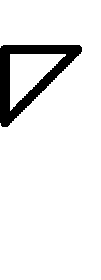

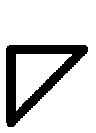

Results:
NCC mode:
1. :16/p scores: 1.0
2. :1/e scores: 0.95421009303
3. :16/v scores: 0.948576084196
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqp
Processed: 139/715
Processing:


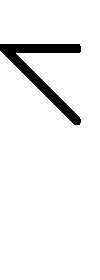

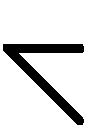

Results:
NCC mode:
1. :16/g scores: 1.0
2. :1/t scores: 0.955082585326
3. :16/r scores: 0.938605820185
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpg
Processed: 140/715
Processing:


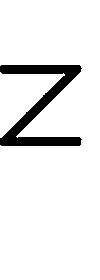

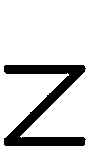

Results:
NCC mode:
1. :16/z scores: 1.0
2. :1/g scores: 0.94718832874
3. :16/b scores: 0.945562479696
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgz
Processed: 141/715
Processing:


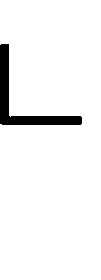

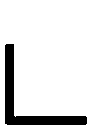

Results:
NCC mode:
1. :16/l scores: 1.0
2. :1/z scores: 0.978951266232
3. :12/o scores: 0.975991897049
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzl
Processed: 142/715
Processing:


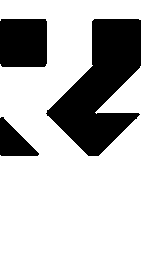

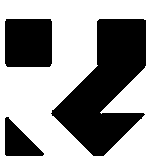

Results:
NCC mode:
1. :22/i scores: 1.0
2. :22/k scores: 0.952142539447
3. :22/s scores: 0.903277978176
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzli
Processed: 143/715
Processing:


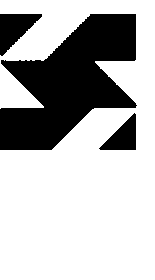

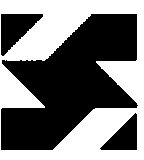

Results:
NCC mode:
1. :22/k scores: 1.0
2. :22/e scores: 0.883553532452
3. :22/d scores: 0.841696654329
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlik
Processed: 144/715
Processing:


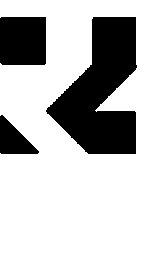

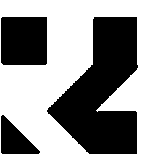

Results:
NCC mode:
1. :22/f scores: 1.0
2. :22/a scores: 0.952524585075
3. :22/i scores: 0.952077517473
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikf
Processed: 145/715
Processing:


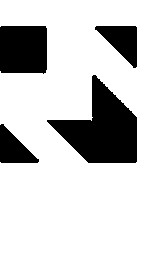

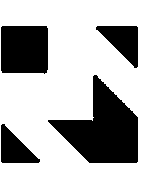

Results:
NCC mode:
1. :22/y scores: 1.0
2. :22/s scores: 0.915547918614
3. :22/y scores: 0.872606209689
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfy
Processed: 146/715
Processing:


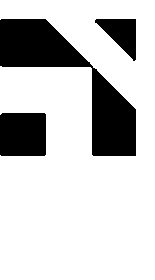

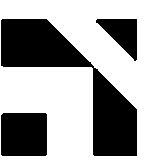

Results:
NCC mode:
1. :22/b scores: 1.0
2. :22/s scores: 0.960734824575
3. :22/y scores: 0.872606209689
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfyb
Processed: 147/715
Processing:


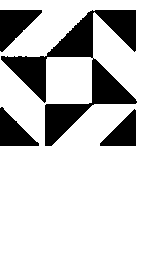

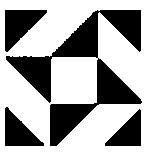

Results:
NCC mode:
1. :22/m scores: 1.0
2. :22/e scores: 0.89391936373
3. :28/x scores: 0.853921790636
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybm
Processed: 148/715
Processing:


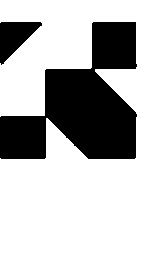

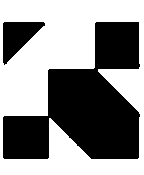

Results:
NCC mode:
1. :22/u scores: 1.0
2. :22/u scores: 0.943115040947
3. :22/s scores: 0.861349804108
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmu
Processed: 149/715
Processing:


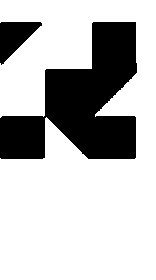

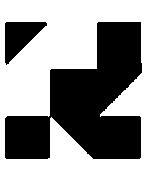

Results:
NCC mode:
1. :22/v scores: 1.0
2. :22/u scores: 0.943115040947
3. :22/s scores: 0.910965290125
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuv
Processed: 150/715
Processing:


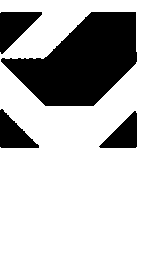

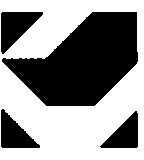

Results:
NCC mode:
1. :22/o scores: 1.0
2. :22/d scores: 0.951788073621
3. :22/j scores: 0.890827131393
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvo
Processed: 151/715
Processing:


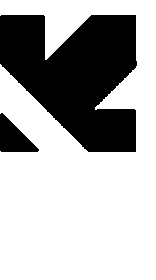

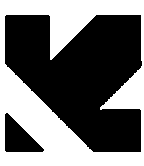

Results:
NCC mode:
1. :22/d scores: 1.0
2. :22/z scores: 0.825583590618
3. :22/x scores: 0.8210009731
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvod
Processed: 152/715
Processing:


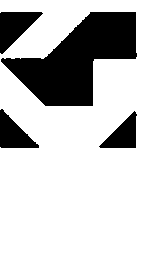

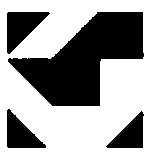

Results:
NCC mode:
1. :22/n scores: 1.0
2. :22/o scores: 0.951788073621
3. :22/j scores: 0.951550904202
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodn
Processed: 153/715
Processing:


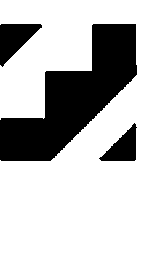

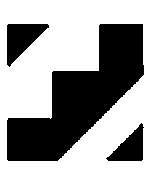

Results:
NCC mode:
1. :22/w scores: 1.0
2. :22/v scores: 0.879362083481
3. :27/n scores: 0.850859582202
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnw
Processed: 154/715
Processing:


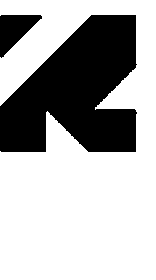

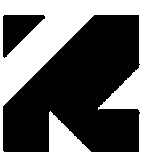

Results:
NCC mode:
1. :22/c scores: 1.0
2. :22/v scores: 0.872406901297
3. :22/u scores: 0.803447837521
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwc
Processed: 155/715
Processing:


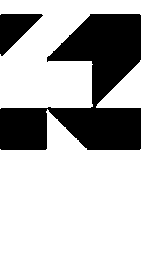

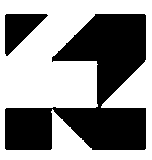

Results:
NCC mode:
1. :22/r scores: 1.0
2. :22/j scores: 0.947863526217
3. :22/a scores: 0.859144725523
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcr
Processed: 156/715
Processing:


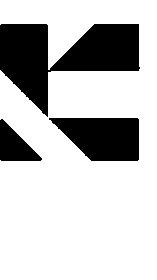

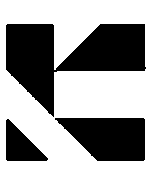

Results:
NCC mode:
1. :22/s scores: 1.0
2. :27/r scores: 0.821325305821
3. :22/f scores: 0.812946618672
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrs
Processed: 157/715
Processing:


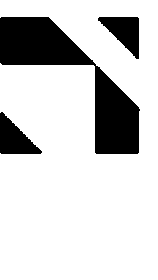

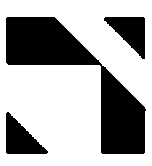

Results:
NCC mode:
1. :22/a scores: 1.0
2. :22/b scores: 0.963334250051
3. :22/y scores: 0.914273342486
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsa
Processed: 158/715
Processing:


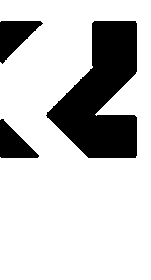

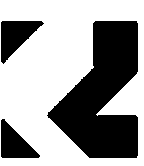

Results:
NCC mode:
1. :22/h scores: 1.0
2. :22/f scores: 0.952524585075
3. :22/u scores: 0.910965290125
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsah
Processed: 159/715
Processing:


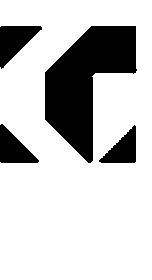

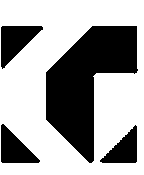

Results:
NCC mode:
1. :22/t scores: 1.0
2. :22/x scores: 0.954901421225
3. :22/n scores: 0.9057728044
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsaht
Processed: 160/715
Processing:


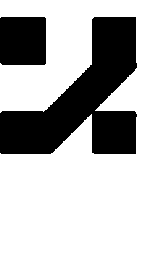

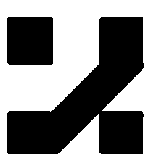

Results:
NCC mode:
1. :22/e scores: 1.0
2. :22/f scores: 0.879281319399
3. :22/a scores: 0.846056438019
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahte
Processed: 161/715
Processing:


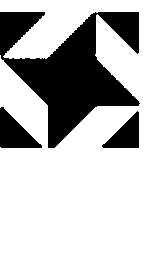

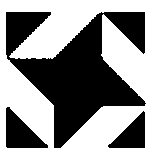

Results:
NCC mode:
1. :22/j scores: 1.0
2. :22/m scores: 0.89391936373
3. :22/k scores: 0.883553532452
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtej
Processed: 162/715
Processing:


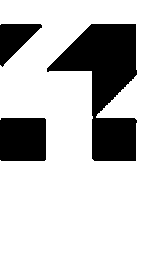

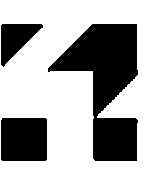

Results:
NCC mode:
1. :22/x scores: 1.0
2. :22/r scores: 0.944749798087
3. :27/r scores: 0.846716365382
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejx
Processed: 163/715
Processing:


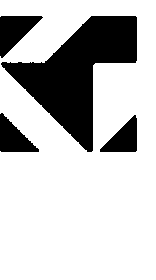

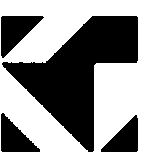

Results:
NCC mode:
1. :22/q scores: 1.0
2. :22/t scores: 0.954639565174
3. :22/n scores: 0.951550904202
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxq
Processed: 164/715
Processing:


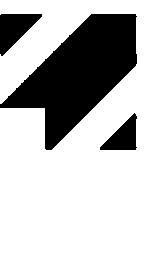

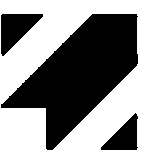

Results:
NCC mode:
1. :22/p scores: 1.0
2. :22/o scores: 0.848047334164
3. :22/d scores: 0.809566130682
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqp
Processed: 165/715
Processing:


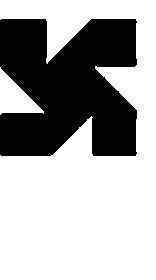

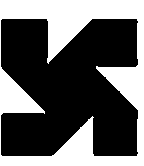

Results:
NCC mode:
1. :22/g scores: 1.0
2. :22/k scores: 0.82346945419
3. :22/e scores: 0.748530429183
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 166/715
Processing:


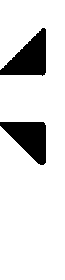

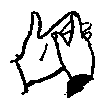

Results:
NCC mode:
1. :25/d scores: 0.828183981647
2. :22/g scores: 0.827889141998
3. :8/f scores: 0.826715704081
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgd
Processed: 167/715
Processing:


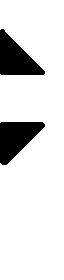

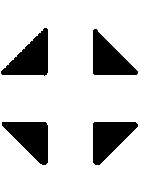

Results:
NCC mode:
1. :22/z scores: 0.827348627397
2. :8/z scores: 0.810114709454
3. :30/z scores: 0.805092165846
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdz
Processed: 168/715
Processing:


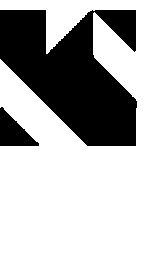

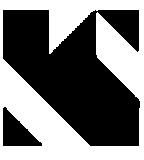

Results:
NCC mode:
1. :22/l scores: 1.0
2. :22/d scores: 0.831898419144
3. :22/e scores: 0.812598216961
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzl
Processed: 169/715
Processing:


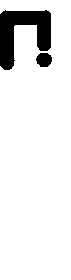

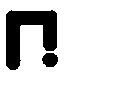

Results:
NCC mode:
1. :23/i scores: 1.0
2. :23/p scores: 0.865163436012
3. :30/b scores: 0.84994360182
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzli
Processed: 170/715
Processing:


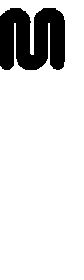

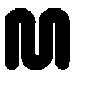

Results:
NCC mode:
1. :23/k scores: 1.0
2. :15/a scores: 0.705796917192
3. :24/p scores: 0.692716915576
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlik
Processed: 171/715
Processing:


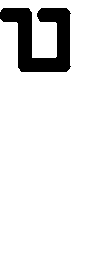

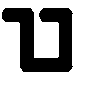

Results:
NCC mode:
1. :23/f scores: 1.0
2. :1/p scores: 0.837493386371
3. :1/h scores: 0.820905740078
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikf
Processed: 172/715
Processing:


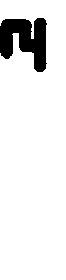

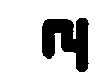

Results:
NCC mode:
1. :23/y scores: 1.0
2. :23/m scores: 0.984556026103
3. :14/b scores: 0.765117915665
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfy
Processed: 173/715
Processing:


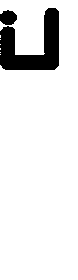

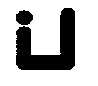

Results:
NCC mode:
1. :23/b scores: 1.0
2. :9/m scores: 0.927778224879
3. :1/b scores: 0.907496767267
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfyb
Processed: 174/715
Processing:


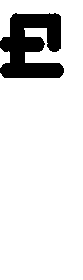

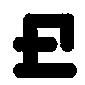

Results:
NCC mode:
1. :23/m scores: 1.0
2. :27/j scores: 0.768835852595
3. :7/n scores: 0.7474491613
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybm
Processed: 175/715
Processing:


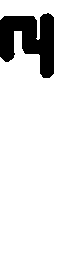

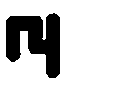

Results:
NCC mode:
1. :23/u scores: 1.0
2. :23/y scores: 0.983801532623
3. :14/b scores: 0.791089850347
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmu
Processed: 176/715
Processing:


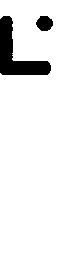

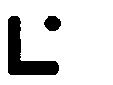

Results:
NCC mode:
1. :23/v scores: 1.0
2. :27/e scores: 0.953298579416
3. :1/g scores: 0.917565825995
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuv
Processed: 177/715
Processing:


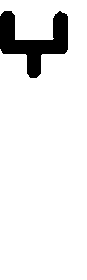

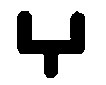

Results:
NCC mode:
1. :23/o scores: 1.0
2. :14/z scores: 0.843140237787
3. :14/h scores: 0.841755484911
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvo
Processed: 178/715
Processing:


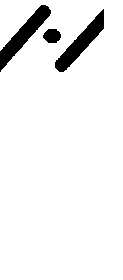

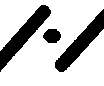

Results:
NCC mode:
1. :23/d scores: 1.0
2. :24/v scores: 0.928190983238
3. :24/y scores: 0.91243938338
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvod
Processed: 179/715
Processing:


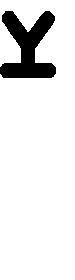

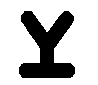

Results:
NCC mode:
1. :23/n scores: 1.0
2. :20/y scores: 0.883084293684
3. :23/n scores: 0.833288924375
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodn
Processed: 180/715
Processing:


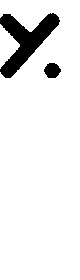

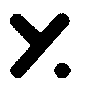

Results:
NCC mode:
1. :23/w scores: 1.0
2. :30/p scores: 0.917559976075
3. :23/a scores: 0.904941170364
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnw
Processed: 181/715
Processing:


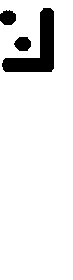

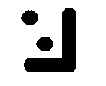

Results:
NCC mode:
1. :23/c scores: 0.998204017925
2. :27/m scores: 0.938353697817
3. :20/z scores: 0.896263320163
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwc
Processed: 182/715
Processing:


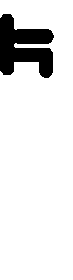

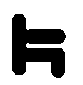

Results:
NCC mode:
1. :23/r scores: 1.0
2. :30/c scores: 0.809427359169
3. :20/l scores: 0.78969988258
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcr
Processed: 183/715
Processing:


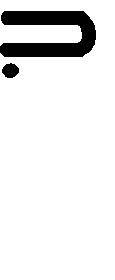

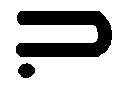

Results:
NCC mode:
1. :23/s scores: 1.0
2. :2/p scores: 0.876085790329
3. :20/c scores: 0.871155243518
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrs
Processed: 184/715
Processing:


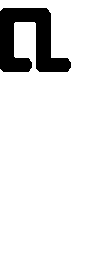

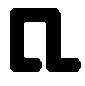

Results:
NCC mode:
1. :23/a scores: 1.0
2. :1/w scores: 0.809309239219
3. :1/g scores: 0.80295610301
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsa
Processed: 185/715
Processing:


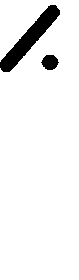

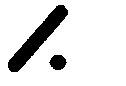

Results:
NCC mode:
1. :23/h scores: 1.0
2. :24/s scores: 0.946217182105
3. :16/i scores: 0.935605192624
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsah
Processed: 186/715
Processing:


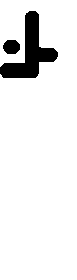

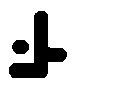

Results:
NCC mode:
1. :23/t scores: 1.0
2. :27/k scores: 0.850837821618
3. :10/g scores: 0.849615587483
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsaht
Processed: 187/715
Processing:


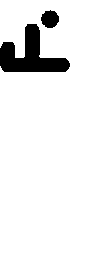

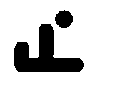

Results:
NCC mode:
1. :23/e scores: 1.0
2. :23/l scores: 0.875864701016
3. :13/n scores: 0.852339076555
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahte
Processed: 188/715
Processing:


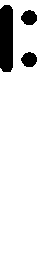

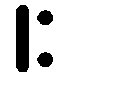

Results:
NCC mode:
1. :23/j scores: 1.0
2. :27/l scores: 0.896694837853
3. :30/g scores: 0.849630222559
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtej
Processed: 189/715
Processing:


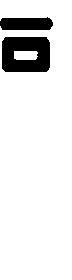

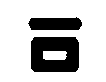

Results:
NCC mode:
1. :23/x scores: 0.993771300338
2. :27/j scores: 0.862960279175
3. :7/n scores: 0.844799303171
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejx
Processed: 190/715
Processing:


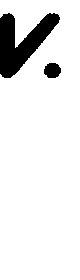

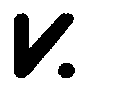

Results:
NCC mode:
1. :23/q scores: 1.0
2. :1/u scores: 0.920643417262
3. :16/v scores: 0.865305331859
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxq
Processed: 191/715
Processing:


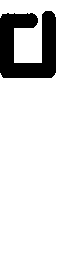

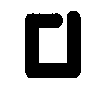

Results:
NCC mode:
1. :23/p scores: 1.0
2. :23/b scores: 0.89758960857
3. :23/q scores: 0.891885497105
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqp
Processed: 192/715
Processing:


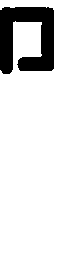

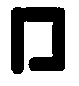

Results:
NCC mode:
1. :23/g scores: 1.0
2. :23/p scores: 0.890071043685
3. :23/i scores: 0.862365517206
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpg
Processed: 193/715
Processing:


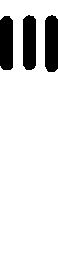

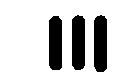

Results:
NCC mode:
1. :23/z scores: 1.0
2. :15/r scores: 0.98715452144
3. :12/t scores: 0.841842875472
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgz
Processed: 194/715
Processing:


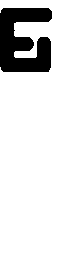

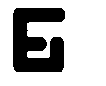

Results:
NCC mode:
1. :23/l scores: 1.0
2. :1/w scores: 0.776979338246
3. :23/v scores: 0.744083921884
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzl
Processed: 195/715
Processing:


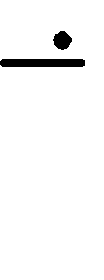

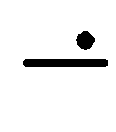

Results:
NCC mode:
1. :13/i scores: 1.0
2. :16/c scores: 0.923372124297
3. :16/g scores: 0.912529842144
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzli
Processed: 196/715
Processing:


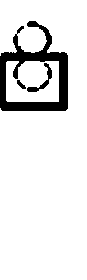

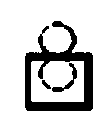

Results:
NCC mode:
1. :13/k scores: 1.0
2. :6/e scores: 0.869422043366
3. :16/e scores: 0.868832174993
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlik
Processed: 197/715
Processing:


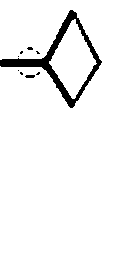

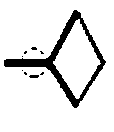

Results:
NCC mode:
1. :13/f scores: 1.0
2. :26/z scores: 0.957823475798
3. :6/j scores: 0.95649084425
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikf
Processed: 198/715
Processing:


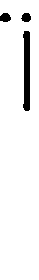

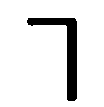

Results:
NCC mode:
1. :12/q scores: 0.962170060149
2. :14/w scores: 0.93125644299
3. :12/n scores: 0.923909847518
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfq
Processed: 199/715
Processing:


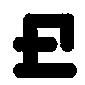

Results:
NCC mode:
1. :23/m scores: 0.500137259547
2. :23/x scores: 0.392385475092
3. :7/n scores: 0.375640422491
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqm
Processed: 200/715
Processing:


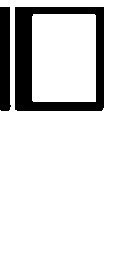

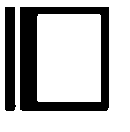

Results:
NCC mode:
1. :13/b scores: 1.0
2. :12/v scores: 0.898897704523
3. :16/v scores: 0.894592683364
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmb
Processed: 201/715
Processing:


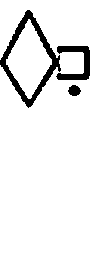

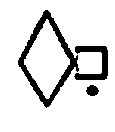

Results:
NCC mode:
1. :13/m scores: 1.0
2. :13/q scores: 0.960621518503
3. :6/c scores: 0.948337471571
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbm
Processed: 202/715
Processing:


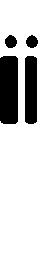

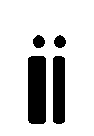

Results:
NCC mode:
1. :13/u scores: 1.0
2. :27/p scores: 0.722425450264
3. :7/a scores: 0.716289513048
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmu
Processed: 203/715
Processing:


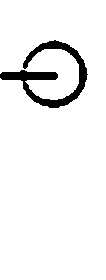

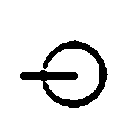

Results:
NCC mode:
1. :13/v scores: 1.0
2. :13/f scores: 0.939830426188
3. :28/o scores: 0.934861976831
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuv
Processed: 204/715
Processing:


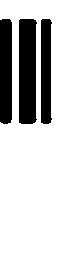

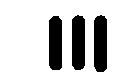

Results:
NCC mode:
1. :23/z scores: 0.882367745359
2. :15/r scores: 0.878307179184
3. :12/t scores: 0.774488789458
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvz
Processed: 205/715
Processing:


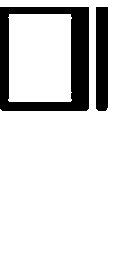

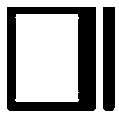

Results:
NCC mode:
1. :13/d scores: 1.0
2. :16/o scores: 0.8857023347
3. :16/u scores: 0.882402279253
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzd
Processed: 206/715
Processing:


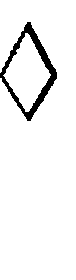

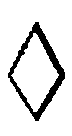

Results:
NCC mode:
1. :13/n scores: 1.0
2. :13/c scores: 0.946502098937
3. :28/o scores: 0.94356917258
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdn
Processed: 207/715
Processing:


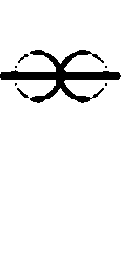

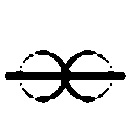

Results:
NCC mode:
1. :13/w scores: 1.0
2. :18/y scores: 0.990927147303
3. :5/a scores: 0.978537858584
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnw
Processed: 208/715
Processing:


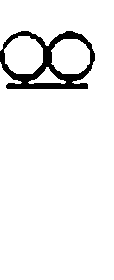

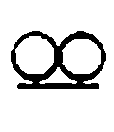

Results:
NCC mode:
1. :13/c scores: 1.0
2. :25/g scores: 0.928593376643
3. :25/d scores: 0.927286644271
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwc
Processed: 209/715
Processing:


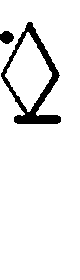

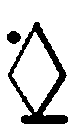

Results:
NCC mode:
1. :13/r scores: 1.0
2. :13/n scores: 0.94701069262
3. :28/q scores: 0.921688564104
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcr
Processed: 210/715
Processing:


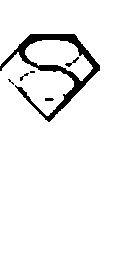

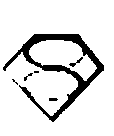

Results:
NCC mode:
1. :13/s scores: 0.999816450893
2. :6/m scores: 0.96210931887
3. :13/j scores: 0.96125950212
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrs
Processed: 211/715
Processing:


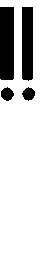

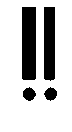

Results:
NCC mode:
1. :13/a scores: 1.0
2. :27/y scores: 0.83475198183
3. :26/z scores: 0.827557692091
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsa
Processed: 212/715
Processing:


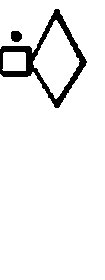

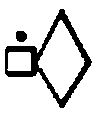

Results:
NCC mode:
1. :13/h scores: 1.0
2. :13/f scores: 0.945399538336
3. :6/m scores: 0.940136396947
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsah
Processed: 213/715
Processing:


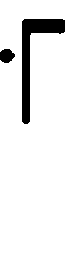

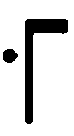

Results:
NCC mode:
1. :13/t scores: 1.0
2. :29/t scores: 0.91478139403
3. :11/v scores: 0.912290816662
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsaht
Processed: 214/715
Processing:


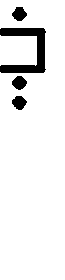

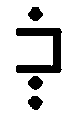

Results:
NCC mode:
1. :13/e scores: 1.0
2. :25/i scores: 0.880020162068
3. :28/v scores: 0.878280656865
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahte
Processed: 215/715
Processing:


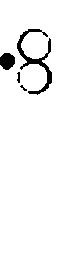

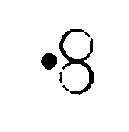

Results:
NCC mode:
1. :13/j scores: 0.998937156316
2. :28/o scores: 0.926407183024
3. :26/g scores: 0.924592152041
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtej
Processed: 216/715
Processing:


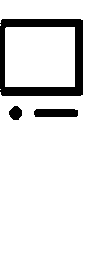

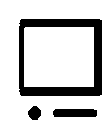

Results:
NCC mode:
1. :13/x scores: 1.0
2. :7/j scores: 0.920446093432
3. :6/i scores: 0.916600511017
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejx
Processed: 217/715
Processing:


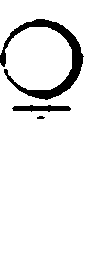

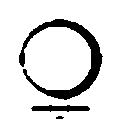

Results:
NCC mode:
1. :13/q scores: 1.0
2. :13/s scores: 0.952417262225
3. :6/y scores: 0.951851931139
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxq
Processed: 218/715
Processing:


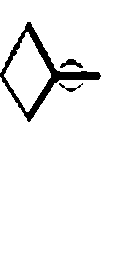

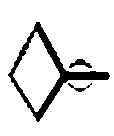

Results:
NCC mode:
1. :13/p scores: 0.999641639666
2. :6/j scores: 0.961962270363
3. :13/b scores: 0.960619111315
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqp
Processed: 219/715
Processing:


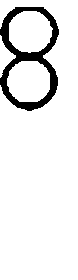

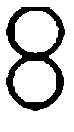

Results:
NCC mode:
1. :13/g scores: 1.0
2. :6/g scores: 0.881625121592
3. :6/x scores: 0.881593114489
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpg
Processed: 220/715
Processing:


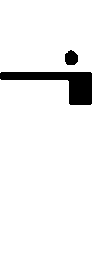

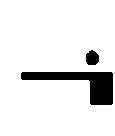

Results:
NCC mode:
1. :13/z scores: 1.0
2. :2/n scores: 0.918683877419
3. :13/j scores: 0.918365766837
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgz
Processed: 221/715
Processing:


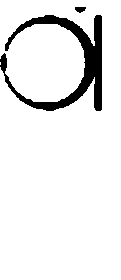

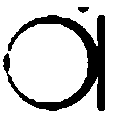

Results:
NCC mode:
1. :13/l scores: 1.0
2. :12/a scores: 0.931115087222
3. :2/z scores: 0.927757467569
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzl
Processed: 222/715
Processing:


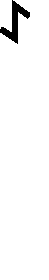

Results:
NCC mode:
1. :30/i scores: 0.996972581647
2. :30/e scores: 0.996972581647
3. :10/c scores: 0.911851710761
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzli
Processed: 223/715
Processing:


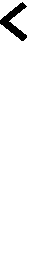

Results:
NCC mode:
1. :30/c scores: 0.992413311148
2. :30/k scores: 0.988955305088
3. :17/b scores: 0.883834636624
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlic
Processed: 224/715
Processing:


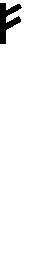

Results:
NCC mode:
1. :30/f scores: 1.0
2. :30/s scores: 0.910133808656
3. :30/a scores: 0.843577975404
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicf
Processed: 225/715
Processing:


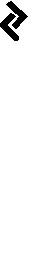

Results:
NCC mode:
1. :30/y scores: 0.993748438959
2. :10/c scores: 0.867952170991
3. :5/j scores: 0.867094823643
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfy
Processed: 226/715
Processing:


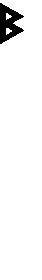

Results:
NCC mode:
1. :30/b scores: 1.0
2. :30/c scores: 0.854176376197
3. :30/n scores: 0.846000009636
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfyb
Processed: 227/715
Processing:


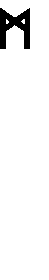

Results:
NCC mode:
1. :30/m scores: 1.0
2. :30/t scores: 0.902106421806
3. :30/m scores: 0.820326648815
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybm
Processed: 228/715
Processing:


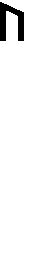

Results:
NCC mode:
1. :30/u scores: 1.0
2. :30/t scores: 0.895832158777
3. :27/z scores: 0.888826348338
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmu
Processed: 229/715
Processing:


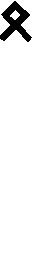

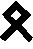

Results:
NCC mode:
1. :30/o scores: 0.994637997319
2. :10/t scores: 0.844131183058
3. :4/q scores: 0.840612733621
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuo
Processed: 230/715
Processing:


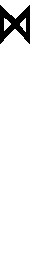

Results:
NCC mode:
1. :30/d scores: 1.0
2. :29/d scores: 0.894277570251
3. :16/d scores: 0.870510983035
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuod
Processed: 231/715
Processing:


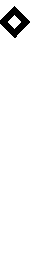

Results:
NCC mode:
1. :30/n scores: 0.994662894551
2. :10/e scores: 0.907119334412
3. :7/i scores: 0.880477266001
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodn
Processed: 232/715
Processing:


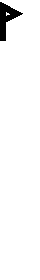

Results:
NCC mode:
1. :30/w scores: 1.0
2. :30/z scores: 0.947168179757
3. :29/w scores: 0.895828299852
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnw
Processed: 233/715
Processing:


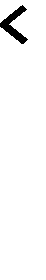

Results:
NCC mode:
1. :30/c scores: 0.989465197161
2. :30/k scores: 0.977636142416
3. :17/b scores: 0.892225716877
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwc
Processed: 234/715
Processing:


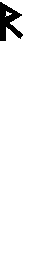

Results:
NCC mode:
1. :30/r scores: 1.0
2. :30/w scores: 0.88663766833
3. :30/b scores: 0.858835594888
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcr
Processed: 235/715
Processing:


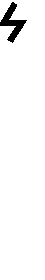

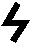

Results:
NCC mode:
1. :30/s scores: 0.981544456097
2. :10/e scores: 0.894887612927
3. :27/i scores: 0.882149365917
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrs
Processed: 236/715
Processing:


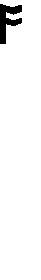

Results:
NCC mode:
1. :30/a scores: 1.0
2. :30/f scores: 0.910133808656
3. :29/o scores: 0.829096036019
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsa
Processed: 237/715
Processing:


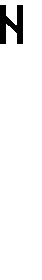

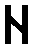

Results:
NCC mode:
1. :30/h scores: 1.0
2. :1/d scores: 0.858088691207
3. :27/p scores: 0.816892825958
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsah
Processed: 238/715
Processing:


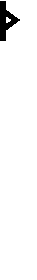

Results:
NCC mode:
1. :30/t scores: 1.0
2. :30/f scores: 0.839857558962
3. :20/i scores: 0.829004993843
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsaht
Processed: 239/715
Processing:


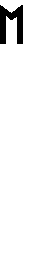

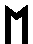

Results:
NCC mode:
1. :30/e scores: 1.0
2. :30/m scores: 0.898817428964
3. :30/m scores: 0.895832158777
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahte
Processed: 240/715
Processing:


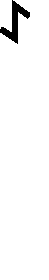

Results:
NCC mode:
1. :30/i scores: 0.996972581647
2. :30/e scores: 0.996972581647
3. :10/c scores: 0.911851710761
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahtei
Processed: 241/715
Processing:


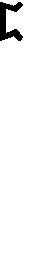

Results:
NCC mode:
1. :30/p scores: 1.0
2. :23/v scores: 0.878146229728
3. :9/u scores: 0.854005813086
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteip
Processed: 242/715
Processing:


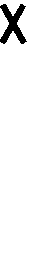

Results:
NCC mode:
1. :30/g scores: 1.0
2. :23/w scores: 0.91366017541
3. :16/x scores: 0.902062027855
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipg
Processed: 243/715
Processing:


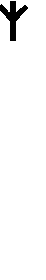

Results:
NCC mode:
1. :30/z scores: 0.978321684606
2. :11/h scores: 0.933864714939
3. :8/n scores: 0.910180246647
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgz
Processed: 244/715
Processing:


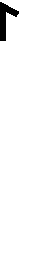

Results:
NCC mode:
1. :30/l scores: 1.0
2. :30/w scores: 0.942706177487
3. :14/f scores: 0.907468735235
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzl
Processed: 245/715
Processing:


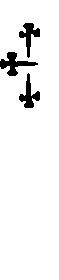

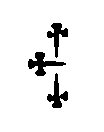

Results:
NCC mode:
1. :8/i scores: 1.0
2. :26/z scores: 0.905040223216
3. :2/n scores: 0.90373773077
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzli
Processed: 246/715
Processing:


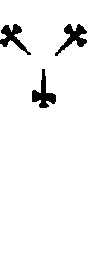

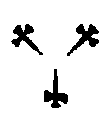

Results:
NCC mode:
1. :8/k scores: 0.999740966985
2. :14/u scores: 0.977749835843
3. :28/y scores: 0.967092107267
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlik
Processed: 247/715
Processing:


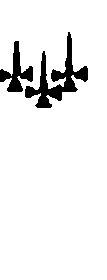

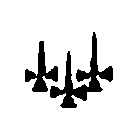

Results:
NCC mode:
1. :8/f scores: 1.0
2. :21/l scores: 0.934366256901
3. :6/v scores: 0.927259970445
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikf
Processed: 248/715
Processing:


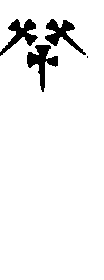

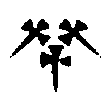

Results:
NCC mode:
1. :8/y scores: 0.996051021858
2. :5/o scores: 0.931127638662
3. :25/u scores: 0.930533701581
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfy
Processed: 249/715
Processing:


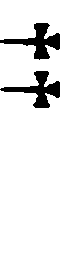

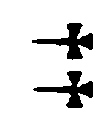

Results:
NCC mode:
1. :8/b scores: 0.99971673038
2. :25/d scores: 0.908659662659
3. :25/p scores: 0.890515446376
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfyb
Processed: 250/715
Processing:


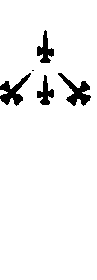

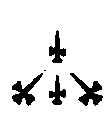

Results:
NCC mode:
1. :8/m scores: 1.0
2. :27/w scores: 0.954685731101
3. :29/g scores: 0.952154881423
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybm
Processed: 251/715
Processing:


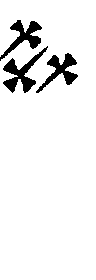

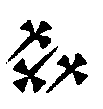

Results:
NCC mode:
1. :8/u scores: 0.986734416414
2. :8/t scores: 0.924346360342
3. :13/p scores: 0.912519331466
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmu
Processed: 252/715
Processing:


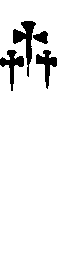

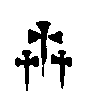

Results:
NCC mode:
1. :8/v scores: 1.0
2. :5/o scores: 0.902502173838
3. :18/x scores: 0.89911893668
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuv
Processed: 253/715
Processing:


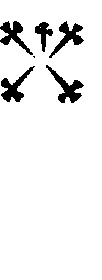

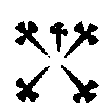

Results:
NCC mode:
1. :8/o scores: 1.0
2. :27/r scores: 0.94850762713
3. :27/w scores: 0.9304392802
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvo
Processed: 254/715
Processing:


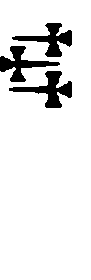

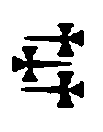

Results:
NCC mode:
1. :8/d scores: 1.0
2. :8/i scores: 0.924118895745
3. :8/y scores: 0.902015477636
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvod
Processed: 255/715
Processing:


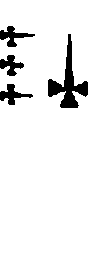

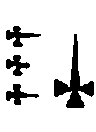

Results:
NCC mode:
1. :8/n scores: 1.0
2. :6/w scores: 0.928619754221
3. :6/b scores: 0.927205740184
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodn
Processed: 256/715
Processing:


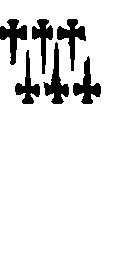

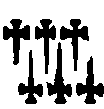

Results:
NCC mode:
1. :8/w scores: 1.0
2. :26/f scores: 0.916209998711
3. :26/n scores: 0.911444216673
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnw
Processed: 257/715
Processing:


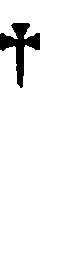

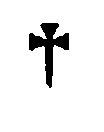

Results:
NCC mode:
1. :8/c scores: 1.0
2. :30/z scores: 0.915501391952
3. :14/r scores: 0.914460023539
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwc
Processed: 258/715
Processing:


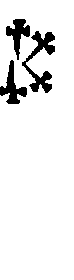

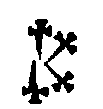

Results:
NCC mode:
1. :8/r scores: 1.0
2. :25/a scores: 0.880655435871
3. :25/v scores: 0.874374459157
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcr
Processed: 259/715
Processing:


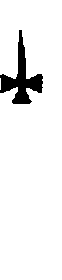

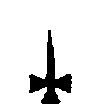

Results:
NCC mode:
1. :8/s scores: 1.0
2. :10/a scores: 0.893574070806
3. :29/g scores: 0.88334335054
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrs
Processed: 260/715
Processing:


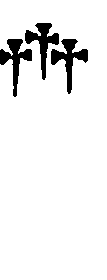

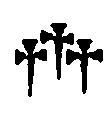

Results:
NCC mode:
1. :8/a scores: 1.0
2. :18/y scores: 0.920421115467
3. :10/w scores: 0.918832443809
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsa
Processed: 261/715
Processing:


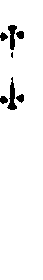

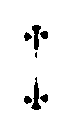

Results:
NCC mode:
1. :8/h scores: 1.0
2. :28/s scores: 0.905155924862
3. :28/c scores: 0.902577862748
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsah
Processed: 262/715
Processing:


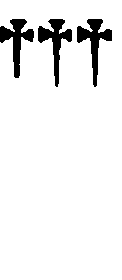

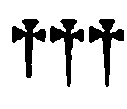

Results:
NCC mode:
1. :8/t scores: 1.0
2. :8/z scores: 0.937049476535
3. :8/k scores: 0.923812566223
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsaht
Processed: 263/715
Processing:


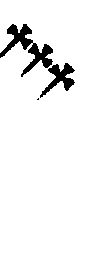

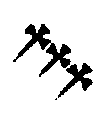

Results:
NCC mode:
1. :8/e scores: 0.988561206818
2. :15/b scores: 0.931295650835
3. :26/v scores: 0.926000535561
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahte
Processed: 264/715
Processing:


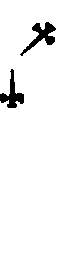

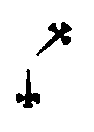

Results:
NCC mode:
1. :8/j scores: 1.0
2. :25/y scores: 0.942111802647
3. :2/c scores: 0.937510172317
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtej
Processed: 265/715
Processing:


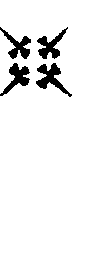

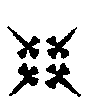

Results:
NCC mode:
1. :8/x scores: 0.99559404713
2. :29/g scores: 0.928556542328
3. :10/m scores: 0.91501847914
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejx
Processed: 266/715
Processing:


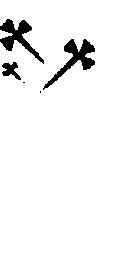

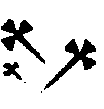

Results:
NCC mode:
1. :8/q scores: 1.0
2. :8/p scores: 0.946968421397
3. :6/d scores: 0.944821872642
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxq
Processed: 267/715
Processing:


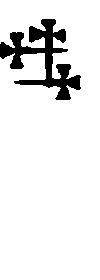

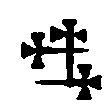

Results:
NCC mode:
1. :8/p scores: 1.0
2. :26/f scores: 0.913561581846
3. :25/h scores: 0.913217130072
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqp
Processed: 268/715
Processing:


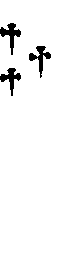

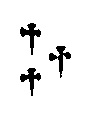

Results:
NCC mode:
1. :8/g scores: 1.0
2. :6/m scores: 0.937947487382
3. :6/u scores: 0.936516054586
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpg
Processed: 269/715
Processing:


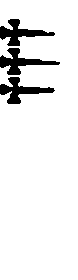

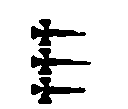

Results:
NCC mode:
1. :8/z scores: 1.0
2. :11/q scores: 0.893926976086
3. :2/f scores: 0.88353973225
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgz
Processed: 270/715
Processing:


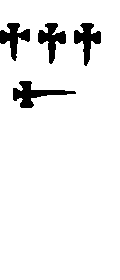

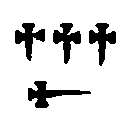

Results:
NCC mode:
1. :8/l scores: 1.0
2. :8/j scores: 0.934168189676
3. :8/t scores: 0.931406547284
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 271/715
Processing:


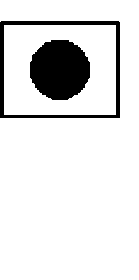

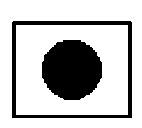

Results:
NCC mode:
1. :7/i scores: 1.0
2. :7/r scores: 0.962506674836
3. :5/p scores: 0.927566105165
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzli
Processed: 272/715
Processing:


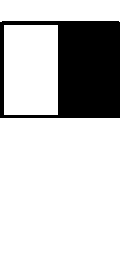

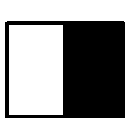

Results:
NCC mode:
1. :7/k scores: 1.0
2. :7/a scores: 0.995750274183
3. :7/s scores: 0.909294129616
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlik
Processed: 273/715
Processing:


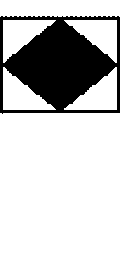

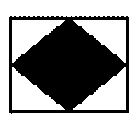

Results:
NCC mode:
1. :7/f scores: 1.0
2. :30/s scores: 0.901152810958
3. :30/n scores: 0.900922458696
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikf
Processed: 274/715
Processing:


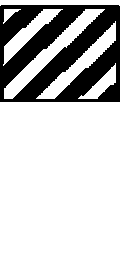

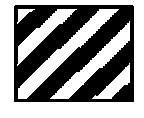

Results:
NCC mode:
1. :7/y scores: 1.0
2. :7/j scores: 0.778662006727
3. :6/i scores: 0.77574915317
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfy
Processed: 275/715
Processing:


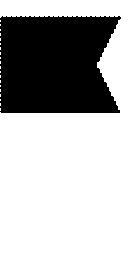

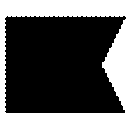

Results:
NCC mode:
1. :7/b scores: 1.0
2. :7/t scores: 0.622475555517
3. :15/a scores: 0.551030488435
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfyb
Processed: 276/715
Processing:


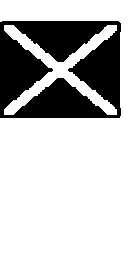

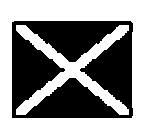

Results:
NCC mode:
1. :7/m scores: 1.0
2. :18/a scores: 0.735528108628
3. :10/n scores: 0.721324304713
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybm
Processed: 277/715
Processing:


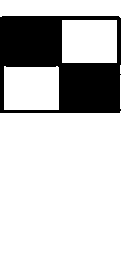

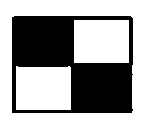

Results:
NCC mode:
1. :7/u scores: 1.0
2. :15/g scores: 0.873853839937
3. :15/o scores: 0.859215615263
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmu
Processed: 278/715
Processing:


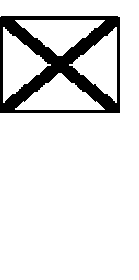

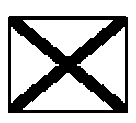

Results:
NCC mode:
1. :7/v scores: 1.0
2. :16/x scores: 0.989587820266
3. :29/g scores: 0.959987448687
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuv
Processed: 279/715
Processing:


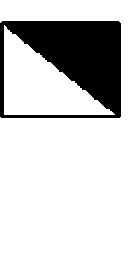

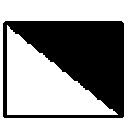

Results:
NCC mode:
1. :7/o scores: 1.0
2. :27/t scores: 0.859398292928
3. :1/a scores: 0.844053676403
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvo
Processed: 280/715
Processing:


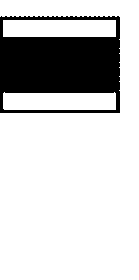

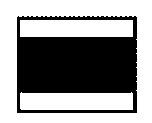

Results:
NCC mode:
1. :7/d scores: 1.0
2. :18/t scores: 0.838812282007
3. :23/r scores: 0.834605154498
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvod
Processed: 281/715
Processing:


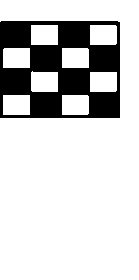

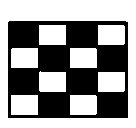

Results:
NCC mode:
1. :7/n scores: 1.0
2. :16/g scores: 0.766137901879
3. :10/c scores: 0.763789735107
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodn
Processed: 282/715
Processing:


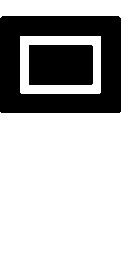

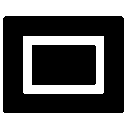

Results:
NCC mode:
1. :7/w scores: 1.0
2. :12/y scores: 0.90369497193
3. :12/r scores: 0.899723976386
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnw
Processed: 283/715
Processing:


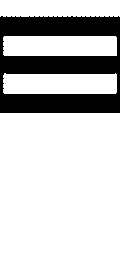

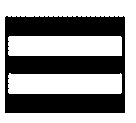

Results:
NCC mode:
1. :7/c scores: 1.0
2. :27/j scores: 0.984352084019
3. :2/k scores: 0.835259954214
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwc
Processed: 284/715
Processing:


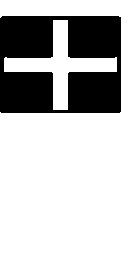

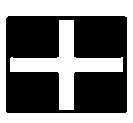

Results:
NCC mode:
1. :7/r scores: 1.0
2. :7/e scores: 0.815597419188
3. :22/z scores: 0.781478655141
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcr
Processed: 285/715
Processing:


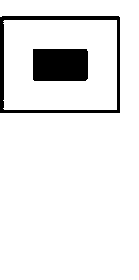

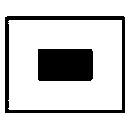

Results:
NCC mode:
1. :7/s scores: 1.0
2. :7/i scores: 0.962506674836
3. :28/y scores: 0.933567489967
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrs
Processed: 286/715
Processing:


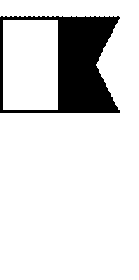

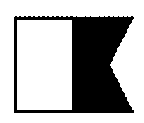

Results:
NCC mode:
1. :7/a scores: 1.0
2. :7/k scores: 0.909294129616
3. :7/s scores: 0.906359314048
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsa
Processed: 287/715
Processing:


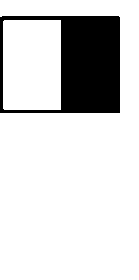

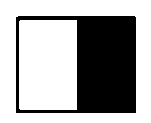

Results:
NCC mode:
1. :7/h scores: 1.0
2. :7/k scores: 0.995750274183
3. :27/g scores: 0.909206747222
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsah
Processed: 288/715
Processing:


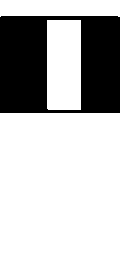

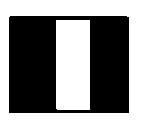

Results:
NCC mode:
1. :7/t scores: 1.0
2. :27/y scores: 0.953097437231
3. :26/z scores: 0.895660921877
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaht
Processed: 289/715
Processing:


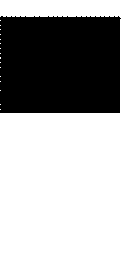

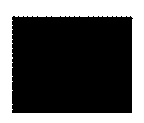

Results:
NCC mode:
1. :7/e scores: 1.0
2. :15/h scores: 0.749275306936
3. :4/z scores: 0.655539688711
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahte
Processed: 290/715
Processing:


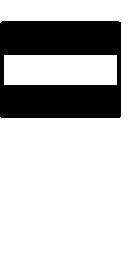

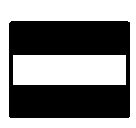

Results:
NCC mode:
1. :7/j scores: 1.0
2. :27/i scores: 0.928121777551
3. :7/c scores: 0.815597419188
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtej
Processed: 291/715
Processing:


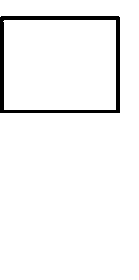

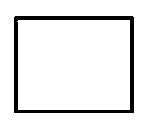

Results:
NCC mode:
1. :7/q scores: 1.0
2. :6/e scores: 0.99568856393
3. :6/i scores: 0.993538855451
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejq
Processed: 292/715
Processing:


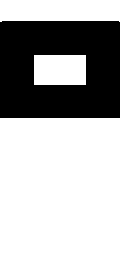

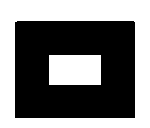

Results:
NCC mode:
1. :7/p scores: 1.0
2. :23/p scores: 0.79465329596
3. :23/p scores: 0.776328879427
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqp
Processed: 293/715
Processing:


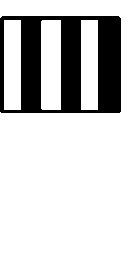

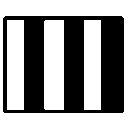

Results:
NCC mode:
1. :7/g scores: 1.0
2. :12/q scores: 0.812380061924
3. :12/n scores: 0.804555662834
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpg
Processed: 294/715
Processing:


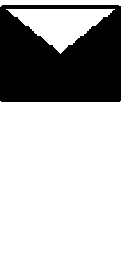

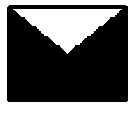

Results:
NCC mode:
1. :7/z scores: 1.0
2. :17/v scores: 0.717477617006
3. :23/y scores: 0.696014706447
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgz
Processed: 295/715
Processing:


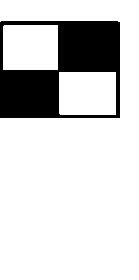

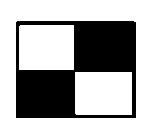

Results:
NCC mode:
1. :7/l scores: 1.0
2. :15/s scores: 0.873101413665
3. :15/m scores: 0.842632188139
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzl
Processed: 296/715
Processing:


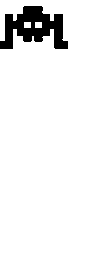

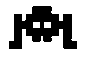

Results:
NCC mode:
1. :4/i scores: 1.0
2. :4/p scores: 0.875060617251
3. :4/y scores: 0.858691139618
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzli
Processed: 297/715
Processing:


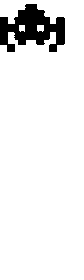

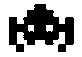

Results:
NCC mode:
1. :4/k scores: 1.0
2. :4/b scores: 0.889010192042
3. :4/p scores: 0.851118258179
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlik
Processed: 298/715
Processing:


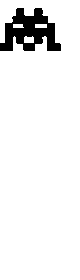

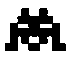

Results:
NCC mode:
1. :4/f scores: 1.0
2. :4/p scores: 0.934925157457
3. :4/y scores: 0.897541824414
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikf
Processed: 299/715
Processing:


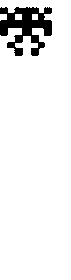

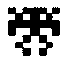

Results:
NCC mode:
1. :4/y scores: 1.0
2. :19/v scores: 0.848750507501
3. :3/c scores: 0.832767285567
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfy
Processed: 300/715
Processing:


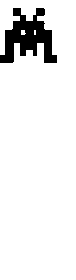

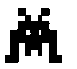

Results:
NCC mode:
1. :4/b scores: 1.0
2. :4/w scores: 0.960248516878
3. :4/o scores: 0.939249040776
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfyb
Processed: 301/715
Processing:


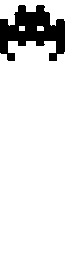

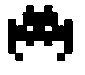

Results:
NCC mode:
1. :4/m scores: 1.0
2. :4/k scores: 0.883546782833
3. :4/u scores: 0.847589960634
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybm
Processed: 302/715
Processing:


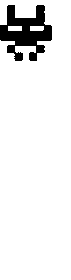

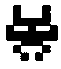

Results:
NCC mode:
1. :4/u scores: 1.0
2. :4/u scores: 0.907801702009
3. :5/q scores: 0.843023028297
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmu
Processed: 303/715
Processing:


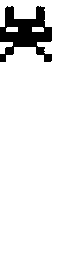

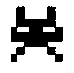

Results:
NCC mode:
1. :4/v scores: 1.0
2. :4/u scores: 0.907801702009
3. :4/r scores: 0.851097268861
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuv
Processed: 304/715
Processing:


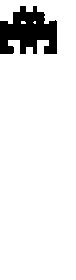

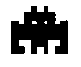

Results:
NCC mode:
1. :4/o scores: 1.0
2. :4/a scores: 0.864045803084
3. :4/t scores: 0.856996056203
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvo
Processed: 305/715
Processing:


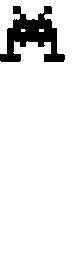

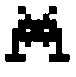

Results:
NCC mode:
1. :4/d scores: 1.0
2. :4/w scores: 0.975847402432
3. :4/b scores: 0.939491538562
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvod
Processed: 306/715
Processing:


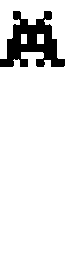

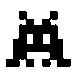

Results:
NCC mode:
1. :4/n scores: 1.0
2. :4/w scores: 0.904606651571
3. :4/d scores: 0.900016018171
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodn
Processed: 307/715
Processing:


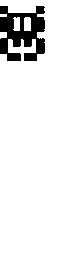

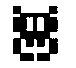

Results:
NCC mode:
1. :4/w scores: 1.0
2. :13/g scores: 0.757564732128
3. :18/n scores: 0.754075108928
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnw
Processed: 308/715
Processing:


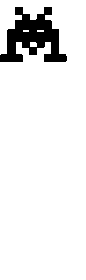

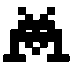

Results:
NCC mode:
1. :4/c scores: 1.0
2. :4/d scores: 0.975847402432
3. :4/b scores: 0.96043421218
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwc
Processed: 309/715
Processing:


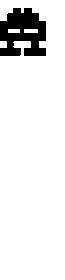

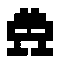

Results:
NCC mode:
1. :4/r scores: 1.0
2. :5/t scores: 0.735635231051
3. :4/e scores: 0.733394965584
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcr
Processed: 310/715
Processing:


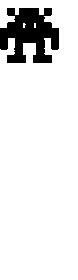

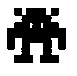

Results:
NCC mode:
1. :4/s scores: 1.0
2. :4/g scores: 0.828027403564
3. :5/g scores: 0.775628409783
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrs
Processed: 311/715
Processing:


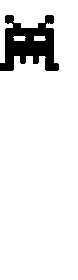

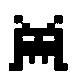

Results:
NCC mode:
1. :4/a scores: 1.0
2. :4/v scores: 0.85905366635
3. :4/b scores: 0.855854700918
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsa
Processed: 312/715
Processing:


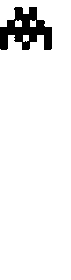

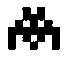

Results:
NCC mode:
1. :4/h scores: 1.0
2. :4/f scores: 0.86618774458
3. :4/v scores: 0.864045803084
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsah
Processed: 313/715
Processing:


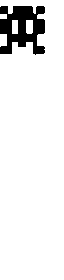

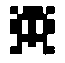

Results:
NCC mode:
1. :4/t scores: 1.0
2. :4/j scores: 0.762573173168
3. :8/a scores: 0.751902810574
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsaht
Processed: 314/715
Processing:


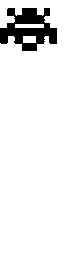

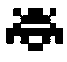

Results:
NCC mode:
1. :4/e scores: 1.0
2. :18/k scores: 0.851943142278
3. :30/n scores: 0.849345058101
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahte
Processed: 315/715
Processing:


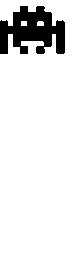

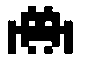

Results:
NCC mode:
1. :4/j scores: 1.0
2. :4/o scores: 0.854750564085
3. :4/m scores: 0.835565624392
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtej
Processed: 316/715
Processing:


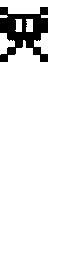

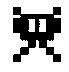

Results:
NCC mode:
1. :4/x scores: 1.0
2. :17/i scores: 0.82234587134
3. :30/u scores: 0.795500214732
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejx
Processed: 317/715
Processing:


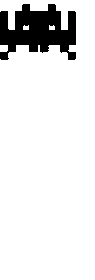

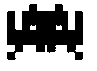

Results:
NCC mode:
1. :4/q scores: 1.0
2. :7/d scores: 0.831972009931
3. :4/v scores: 0.815988174874
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxq
Processed: 318/715
Processing:


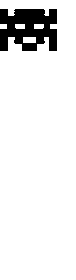

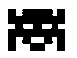

Results:
NCC mode:
1. :4/p scores: 1.0
2. :4/h scores: 0.762450931114
3. :18/i scores: 0.749991236423
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqp
Processed: 319/715
Processing:


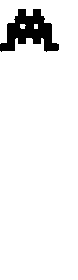

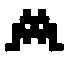

Results:
NCC mode:
1. :4/g scores: 1.0
2. :4/f scores: 0.934925157457
3. :4/y scores: 0.930898743751
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 320/715
Processing:


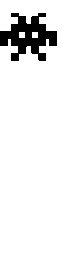

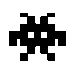

Results:
NCC mode:
1. :4/z scores: 1.0
2. :5/z scores: 0.85977210817
3. :7/f scores: 0.857882832704
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgz
Processed: 321/715
Processing:


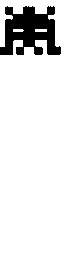

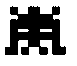

Results:
NCC mode:
1. :4/l scores: 1.0
2. :4/a scores: 0.867781768747
3. :4/i scores: 0.83750339138
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 322/715
Processing:


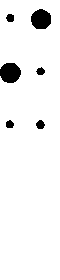

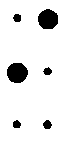

Results:
NCC mode:
1. :2/i scores: 1.0
2. :2/e scores: 0.980055489479
3. :2/k scores: 0.977648383897
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzli
Processed: 323/715
Processing:


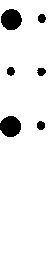

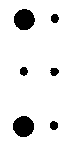

Results:
NCC mode:
1. :2/k scores: 1.0
2. :2/z scores: 0.976457639097
3. :2/b scores: 0.966553198507
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlik
Processed: 324/715
Processing:


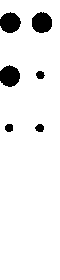

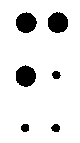

Results:
NCC mode:
1. :2/f scores: 1.0
2. :2/w scores: 0.980010939531
3. :2/q scores: 0.979721667073
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikf
Processed: 325/715
Processing:


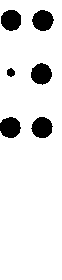

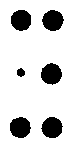

Results:
NCC mode:
1. :2/y scores: 1.0
2. :2/d scores: 0.978918465818
3. :2/e scores: 0.978836261022
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfy
Processed: 326/715
Processing:


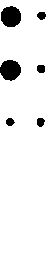

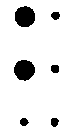

Results:
NCC mode:
1. :2/b scores: 1.0
2. :2/s scores: 0.976608116641
3. :2/s scores: 0.960696981526
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfyb
Processed: 327/715
Processing:


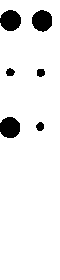

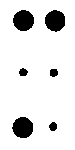

Results:
NCC mode:
1. :2/m scores: 0.999145893876
2. :2/d scores: 0.98091772987
3. :2/e scores: 0.979251200789
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybm
Processed: 328/715
Processing:


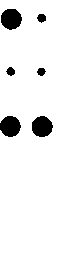

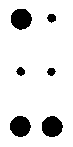

Results:
NCC mode:
1. :2/u scores: 1.0
2. :2/g scores: 0.980174214707
3. :2/u scores: 0.979978666434
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmu
Processed: 329/715
Processing:


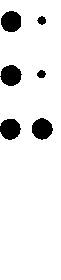

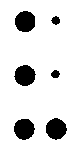

Results:
NCC mode:
1. :2/v scores: 1.0
2. :2/u scores: 0.979978666434
3. :2/g scores: 0.960038227336
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuv
Processed: 330/715
Processing:


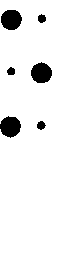

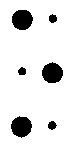

Results:
NCC mode:
1. :2/o scores: 1.0
2. :2/c scores: 0.979665288736
3. :2/p scores: 0.977899316157
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvo
Processed: 331/715
Processing:


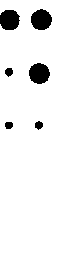

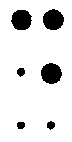

Results:
NCC mode:
1. :2/d scores: 0.999269605581
2. :2/w scores: 0.97918917775
3. :2/q scores: 0.97729817844
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvod
Processed: 332/715
Processing:


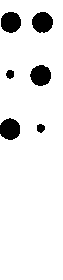

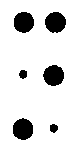

Results:
NCC mode:
1. :2/n scores: 1.0
2. :2/m scores: 0.979912014367
3. :2/j scores: 0.978262670891
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodn
Processed: 333/715
Processing:


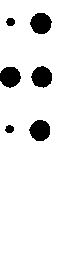

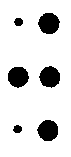

Results:
NCC mode:
1. :2/w scores: 1.0
2. :2/h scores: 0.957135693126
3. :2/t scores: 0.955413816193
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnw
Processed: 334/715
Processing:


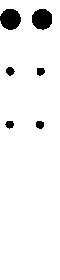

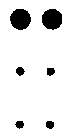

Results:
NCC mode:
1. :2/c scores: 1.0
2. :2/d scores: 0.980658622428
3. :2/f scores: 0.980010939531
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwc
Processed: 335/715
Processing:


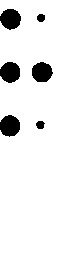

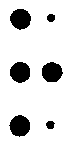

Results:
NCC mode:
1. :2/r scores: 0.998915549734
2. :2/o scores: 0.978150353166
3. :2/j scores: 0.9774533996
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcr
Processed: 336/715
Processing:


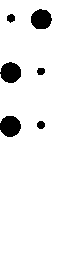

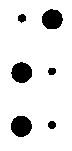

Results:
NCC mode:
1. :2/s scores: 1.0
2. :2/h scores: 0.978600378416
3. :2/x scores: 0.977858805253
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrs
Processed: 337/715
Processing:


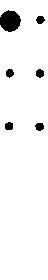

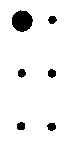

Results:
NCC mode:
1. :2/a scores: 1.0
2. :2/b scores: 0.976608116641
3. :2/h scores: 0.968681499718
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsa
Processed: 338/715
Processing:


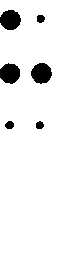

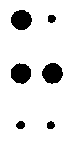

Results:
NCC mode:
1. :2/h scores: 1.0
2. :2/t scores: 0.979613345861
3. :2/q scores: 0.978447763279
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsah
Processed: 339/715
Processing:


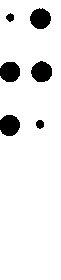

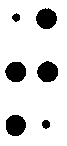

Results:
NCC mode:
1. :2/t scores: 0.999152255586
2. :2/x scores: 0.977672909825
3. :2/s scores: 0.977192807899
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaht
Processed: 340/715
Processing:


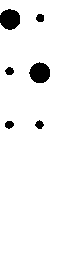

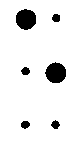

Results:
NCC mode:
1. :2/e scores: 1.0
2. :2/h scores: 0.979124111185
3. :2/d scores: 0.975450103883
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahte
Processed: 341/715
Processing:


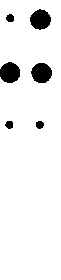

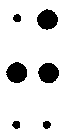

Results:
NCC mode:
1. :2/j scores: 0.999293448916
2. :2/i scores: 0.978911950481
3. :2/q scores: 0.977671772232
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtej
Processed: 342/715
Processing:


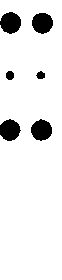

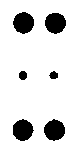

Results:
NCC mode:
1. :2/x scores: 1.0
2. :2/u scores: 0.979079747312
3. :2/y scores: 0.979023221357
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejx
Processed: 343/715
Processing:


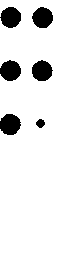

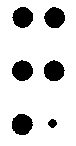

Results:
NCC mode:
1. :2/q scores: 1.0
2. :2/q scores: 0.978831360361
3. :2/n scores: 0.978262670891
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxq
Processed: 344/715
Processing:


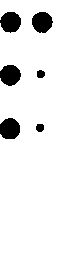

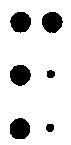

Results:
NCC mode:
1. :2/p scores: 1.0
2. :2/q scores: 0.979059385995
3. :2/m scores: 0.978732839645
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqp
Processed: 345/715
Processing:


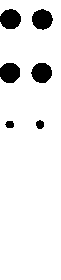

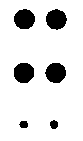

Results:
NCC mode:
1. :2/g scores: 1.0
2. :2/f scores: 0.979326300755
3. :2/a scores: 0.978447763279
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 346/715
Processing:


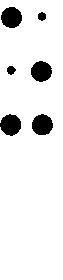

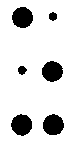

Results:
NCC mode:
1. :2/z scores: 1.0
2. :2/u scores: 0.980174214707
3. :2/v scores: 0.977899316157
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgz
Processed: 347/715
Processing:


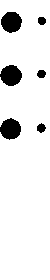

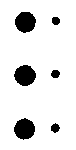

Results:
NCC mode:
1. :2/l scores: 1.0
2. :2/k scores: 0.976457639097
3. :2/c scores: 0.960768895564
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 348/715
Processing:


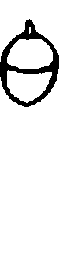

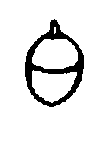

Results:
NCC mode:
1. :18/i scores: 1.0
2. :12/a scores: 0.953843519196
3. :28/v scores: 0.91849723778
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzli
Processed: 349/715
Processing:


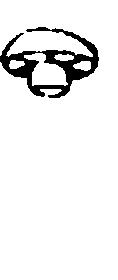

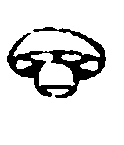

Results:
NCC mode:
1. :18/k scores: 1.0
2. :6/q scores: 0.93756920596
3. :18/f scores: 0.935975844478
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlik
Processed: 350/715
Processing:


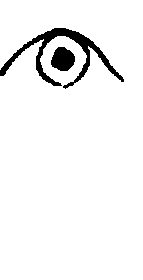

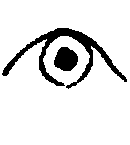

Results:
NCC mode:
1. :18/f scores: 0.999853407157
2. :13/w scores: 0.975254578134
3. :18/f scores: 0.97506919934
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikf
Processed: 351/715
Processing:


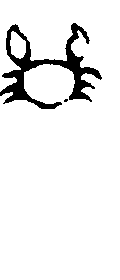

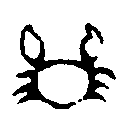

Results:
NCC mode:
1. :18/y scores: 0.99801223915
2. :6/z scores: 0.93760163398
3. :6/v scores: 0.936862477631
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfy
Processed: 352/715
Processing:


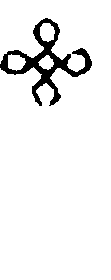

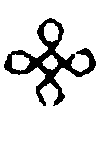

Results:
NCC mode:
1. :18/b scores: 1.0
2. :13/f scores: 0.947418470501
3. :29/x scores: 0.945500055268
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfyb
Processed: 353/715
Processing:


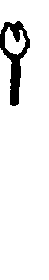

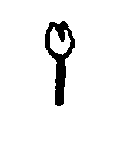

Results:
NCC mode:
1. :18/m scores: 1.0
2. :14/u scores: 0.880430584421
3. :5/b scores: 0.872221812962
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybm
Processed: 354/715
Processing:


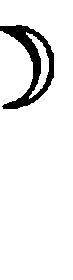

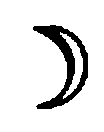

Results:
NCC mode:
1. :18/u scores: 0.999121761265
2. :6/s scores: 0.867906941644
3. :6/g scores: 0.867055894436
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmu
Processed: 355/715
Processing:


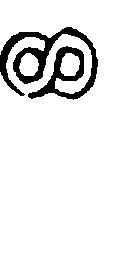

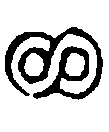

Results:
NCC mode:
1. :18/v scores: 1.0
2. :6/m scores: 0.945979188103
3. :6/f scores: 0.94552824409
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuv
Processed: 356/715
Processing:


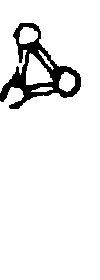

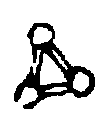

Results:
NCC mode:
1. :18/o scores: 1.0
2. :15/b scores: 0.908895398545
3. :8/u scores: 0.906707769947
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvo
Processed: 357/715
Processing:


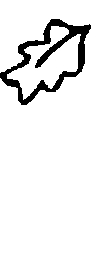

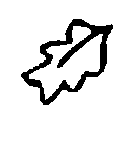

Results:
NCC mode:
1. :18/d scores: 0.999669387904
2. :25/y scores: 0.947831315078
3. :6/y scores: 0.946856282792
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvod
Processed: 358/715
Processing:


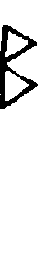

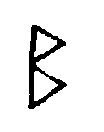

Results:
NCC mode:
1. :18/n scores: 0.992674037481
2. :29/b scores: 0.931830284709
3. :29/uv scores: 0.894433718358
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodn
Processed: 359/715
Processing:


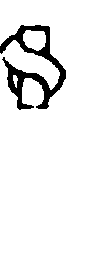

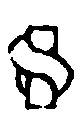

Results:
NCC mode:
1. :18/w scores: 1.0
2. :6/v scores: 0.904768055486
3. :6/e scores: 0.904379576103
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnw
Processed: 360/715
Processing:


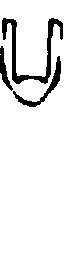

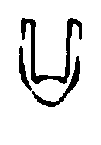

Results:
NCC mode:
1. :18/c scores: 1.0
2. :6/d scores: 0.936500958559
3. :6/m scores: 0.933074387159
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwc
Processed: 361/715
Processing:


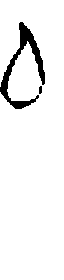

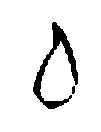

Results:
NCC mode:
1. :18/r scores: 1.0
2. :28/o scores: 0.900102464492
3. :12/a scores: 0.89955151981
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcr
Processed: 362/715
Processing:


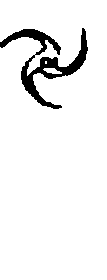

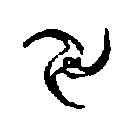

Results:
NCC mode:
1. :18/s scores: 1.0
2. :6/q scores: 0.92912188692
3. :6/m scores: 0.92855684144
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrs
Processed: 363/715
Processing:


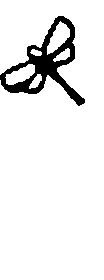

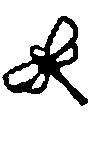

Results:
NCC mode:
1. :18/a scores: 0.999762189115
2. :25/n scores: 0.929227204961
3. :29/g scores: 0.925628712738
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsa
Processed: 364/715
Processing:


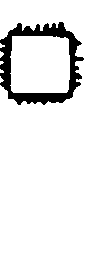

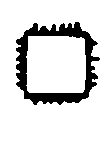

Results:
NCC mode:
1. :18/h scores: 1.0
2. :19/o scores: 0.958286715268
3. :12/d scores: 0.942772003482
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsah
Processed: 365/715
Processing:


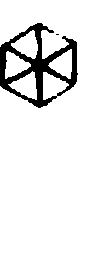

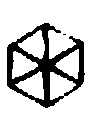

Results:
NCC mode:
1. :18/t scores: 1.0
2. :10/q scores: 0.947174054281
3. :29/e scores: 0.937422486583
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaht
Processed: 366/715
Processing:


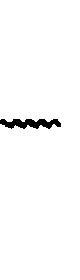

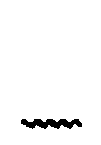

Results:
NCC mode:
1. :18/e scores: 1.0
2. :1/r scores: 0.996770070632
3. :1/p scores: 0.996470289751
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahte
Processed: 367/715
Processing:


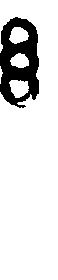

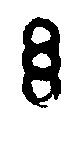

Results:
NCC mode:
1. :18/j scores: 1.0
2. :18/z scores: 0.766074907985
3. :19/w scores: 0.762223064846
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtej
Processed: 368/715
Processing:


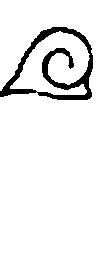

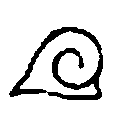

Results:
NCC mode:
1. :18/x scores: 0.999517066363
2. :28/i scores: 0.950711106265
3. :6/n scores: 0.949299009975
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejx
Processed: 369/715
Processing:


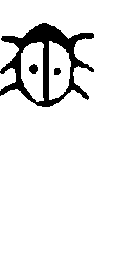

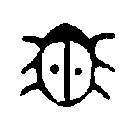

Results:
NCC mode:
1. :18/q scores: 0.999315060735
2. :13/n scores: 0.931116665783
3. :18/k scores: 0.924915266797
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxq
Processed: 370/715
Processing:


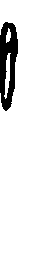

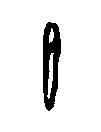

Results:
NCC mode:
1. :18/p scores: 1.0
2. :3/o scores: 0.718793723269
3. :25/k scores: 0.704814441324
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqp
Processed: 371/715
Processing:


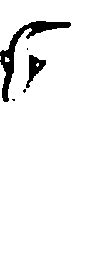

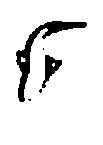

Results:
NCC mode:
1. :18/g scores: 1.0
2. :28/f scores: 0.934782544315
3. :28/r scores: 0.92442038508
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 372/715
Processing:


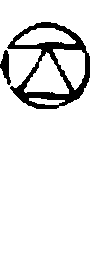

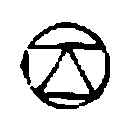

Results:
NCC mode:
1. :18/z scores: 1.0
2. :19/f scores: 0.934787497836
3. :25/d scores: 0.934449561987
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgz
Processed: 373/715
Processing:


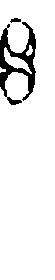

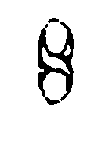

Results:
NCC mode:
1. :18/l scores: 1.0
2. :19/c scores: 0.867290178485
3. :19/o scores: 0.854869475551
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 374/715
Processing:


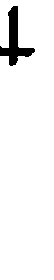

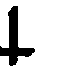

Results:
NCC mode:
1. :9/i scores: 1.0
2. :11/4 scores: 0.88225762502
3. :17/r scores: 0.873433256489
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzli
Processed: 375/715
Processing:


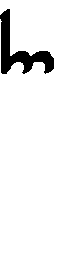

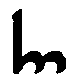

Results:
NCC mode:
1. :9/k scores: 1.0
2. :9/s scores: 0.97360840724
3. :9/g scores: 0.92696618907
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlik
Processed: 376/715
Processing:


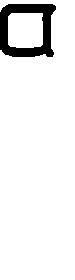

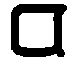

Results:
NCC mode:
1. :9/f scores: 1.0
2. :9/j scores: 0.999460685578
3. :18/h scores: 0.915126180384
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikf
Processed: 377/715
Processing:


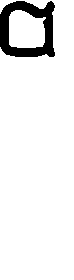

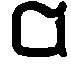

Results:
NCC mode:
1. :9/b scores: 1.0
2. :9/u scores: 0.996956940178
3. :9/e scores: 0.90837371777
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfb
Processed: 378/715
Processing:


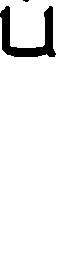

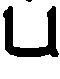

Results:
NCC mode:
1. :9/m scores: 1.0
2. :9/m scores: 0.973986881645
3. :1/b scores: 0.928363405649
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbm
Processed: 379/715
Processing:


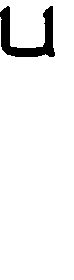

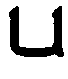

Results:
NCC mode:
1. :9/u scores: 1.0
2. :9/m scores: 0.974783116286
3. :1/b scores: 0.961582271774
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmu
Processed: 380/715
Processing:


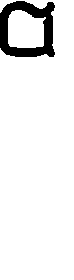

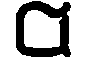

Results:
NCC mode:
1. :9/v scores: 1.0
2. :9/b scores: 0.996956940178
3. :9/e scores: 0.91484395568
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuv
Processed: 381/715
Processing:


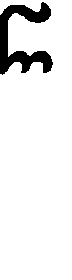

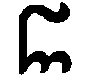

Results:
NCC mode:
1. :9/o scores: 1.0
2. :9/ch scores: 0.970765480417
3. :9/g scores: 0.910497989982
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvo
Processed: 382/715
Processing:


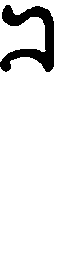

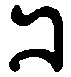

Results:
NCC mode:
1. :9/d scores: 1.0
2. :9/g scores: 0.998693688801
3. :9/r scores: 0.92445513864
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvod
Processed: 383/715
Processing:


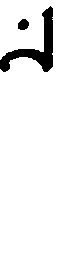

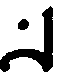

Results:
NCC mode:
1. :9/n scores: 1.0
2. :9/t scores: 0.986302404974
3. :9/h scores: 0.906030288842
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodn
Processed: 384/715
Processing:


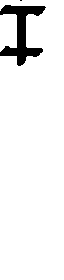

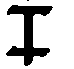

Results:
NCC mode:
1. :9/ch scores: 0.998162818217
2. :9/e scores: 0.928031047539
3. :29/t scores: 0.890658659977
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnch
Processed: 385/715
Processing:


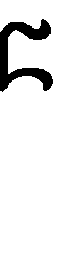

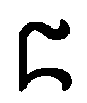

Results:
NCC mode:
1. :9/r scores: 1.0
2. :9/o scores: 0.970765480417
3. :9/s scores: 0.913771950136
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchr
Processed: 386/715
Processing:


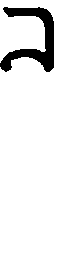

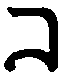

Results:
NCC mode:
1. :9/s scores: 1.0
2. :9/h scores: 0.998621596399
3. :9/d scores: 0.92445513864
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrs
Processed: 387/715
Processing:


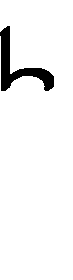

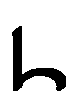

Results:
NCC mode:
1. :9/a scores: 1.0
2. :9/k scores: 0.97360840724
3. :9/s scores: 0.931932016594
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsa
Processed: 388/715
Processing:


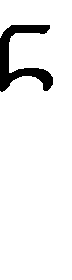

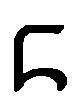

Results:
NCC mode:
1. :9/h scores: 1.0
2. :9/z scores: 0.968407610595
3. :9/a scores: 0.931932016594
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsah
Processed: 389/715
Processing:


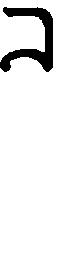

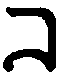

Results:
NCC mode:
1. :9/t scores: 1.0
2. :9/s scores: 0.998621596399
3. :9/d scores: 0.924185579408
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsaht
Processed: 390/715
Processing:


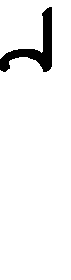

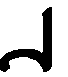

Results:
NCC mode:
1. :9/e scores: 1.0
2. :9/n scores: 0.986302404974
3. :9/h scores: 0.921957473438
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahte
Processed: 391/715
Processing:


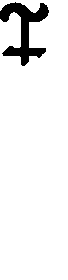

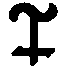

Results:
NCC mode:
1. :9/j scores: 1.0
2. :9/ch scores: 0.933231965702
3. :15/z scores: 0.868049760466
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtej
Processed: 392/715
Processing:


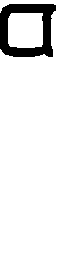

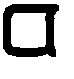

Results:
NCC mode:
1. :9/p scores: 1.0
2. :9/f scores: 0.999460685578
3. :9/u scores: 0.916829685046
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejp
Processed: 393/715
Processing:


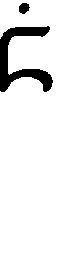

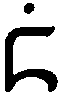

Results:
NCC mode:
1. :9/g scores: 1.0
2. :27/w scores: 0.872208049614
3. :8/b scores: 0.868961858365
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpg
Processed: 394/715
Processing:


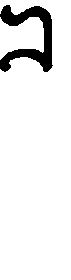

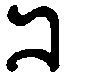

Results:
NCC mode:
1. :9/z scores: 0.998039666552
2. :9/d scores: 0.995947348846
3. :9/r scores: 0.916640845846
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgz
Processed: 395/715
Processing:


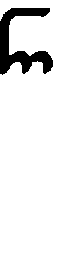

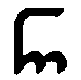

Results:
NCC mode:
1. :9/l scores: 1.0
2. :9/h scores: 0.968407610595
3. :9/k scores: 0.92696618907
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl
Processed: 396/715
Processing:


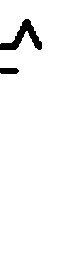

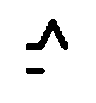

Results:
NCC mode:
1. :20/i scores: 1.0
2. :18/r scores: 0.901063916778
3. :25/y scores: 0.899441763874
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i
Processed: 397/715
Processing:


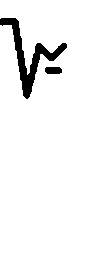

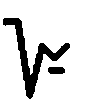

Results:
NCC mode:
1. :20/k scores: 1.0
2. :14/v scores: 0.927211682422
3. :6/q scores: 0.91229065689
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k
Processed: 398/715
Processing:


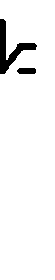

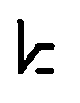

Results:
NCC mode:
1. :20/f scores: 0.99262736817
2. :12/o scores: 0.90833087616
3. :16/z scores: 0.895860928754
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f
Processed: 399/715
Processing:


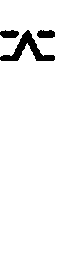

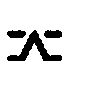

Results:
NCC mode:
1. :20/y scores: 1.0
2. :8/o scores: 0.88337498374
3. :7/u scores: 0.881174929586
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y
Processed: 400/715
Processing:


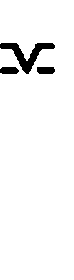

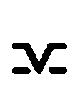

Results:
NCC mode:
1. :20/b scores: 1.0
2. :23/n scores: 0.901145942076
3. :7/u scores: 0.876156972586
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b
Processed: 401/715
Processing:


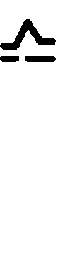

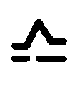

Results:
NCC mode:
1. :20/m scores: 1.0
2. :20/s scores: 0.932943500029
3. :12/m scores: 0.928595570313
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m
Processed: 402/715
Processing:


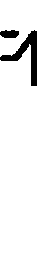

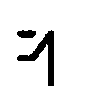

Results:
NCC mode:
1. :20/u scores: 1.0
2. :12/q scores: 0.901538271251
3. :16/h scores: 0.893571972945
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u
Processed: 403/715
Processing:


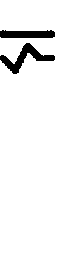

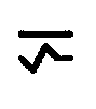

Results:
NCC mode:
1. :20/v scores: 1.0
2. :20/r scores: 0.872441214262
3. :2/c scores: 0.870255284299
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v
Processed: 404/715
Processing:


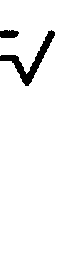

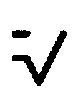

Results:
NCC mode:
1. :20/o scores: 1.0
2. :24/e scores: 0.944315168161
3. :20/d scores: 0.920145542842
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o
Processed: 405/715
Processing:


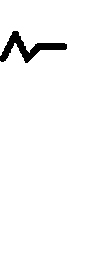

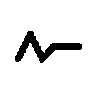

Results:
NCC mode:
1. :20/d scores: 1.0
2. :20/k scores: 0.945433387251
3. :5/q scores: 0.927448421586
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d
Processed: 406/715
Processing:


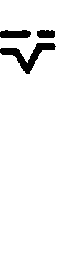

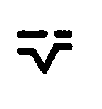

Results:
NCC mode:
1. :20/n scores: 1.0
2. :20/o scores: 0.935146334515
3. :20/p scores: 0.926668828444
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n
Processed: 407/715
Processing:


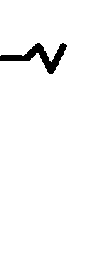

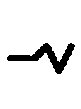

Results:
NCC mode:
1. :20/w scores: 0.999635230625
2. :20/q scores: 0.941336918131
3. :3/c scores: 0.92645105064
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w
Processed: 408/715
Processing:


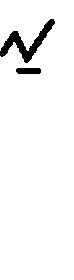

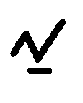

Results:
NCC mode:
1. :20/c scores: 0.998184356244
2. :14/q scores: 0.921927998896
3. :14/u scores: 0.905810718117
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c
Processed: 409/715
Processing:


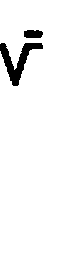

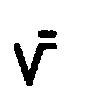

Results:
NCC mode:
1. :20/r scores: 1.0
2. :24/r scores: 0.889582733131
3. :24/b scores: 0.888292740571
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r
Processed: 410/715
Processing:


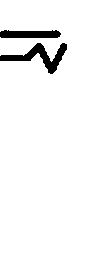

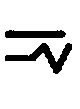

Results:
NCC mode:
1. :20/s scores: 1.0
2. :2/d scores: 0.888573586051
3. :2/t scores: 0.886515260906
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s
Processed: 411/715
Processing:


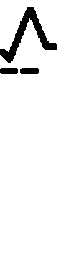

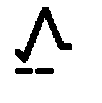

Results:
NCC mode:
1. :20/a scores: 1.0
2. :24/t scores: 0.916951379605
3. :20/m scores: 0.916335601364
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a
Processed: 412/715
Processing:


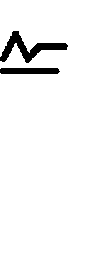

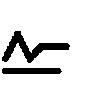

Results:
NCC mode:
1. :20/h scores: 1.0
2. :25/x scores: 0.901963325904
3. :25/k scores: 0.890311345077
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h
Processed: 413/715
Processing:


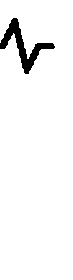

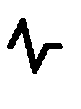

Results:
NCC mode:
1. :20/t scores: 0.997794439482
2. :1/l scores: 0.918587920718
3. :24/w scores: 0.917616315427
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t
Processed: 414/715
Processing:


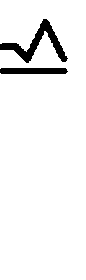

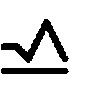

Results:
NCC mode:
1. :20/e scores: 1.0
2. :24/r scores: 0.897106653297
3. :13/f scores: 0.894626468595
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e
Processed: 415/715
Processing:


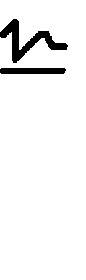

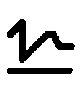

Results:
NCC mode:
1. :20/j scores: 1.0
2. :2/u scores: 0.881553133271
3. :2/g scores: 0.878169366796
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j
Processed: 416/715
Processing:


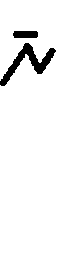

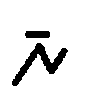

Results:
NCC mode:
1. :20/x scores: 1.0
2. :13/s scores: 0.892847947603
3. :6/m scores: 0.89043600645
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x
Processed: 417/715
Processing:


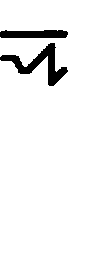

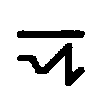

Results:
NCC mode:
1. :20/q scores: 1.0
2. :2/c scores: 0.890855566168
3. :2/f scores: 0.883729979384
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q
Processed: 418/715
Processing:


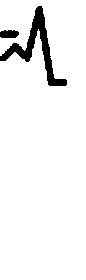

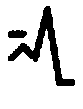

Results:
NCC mode:
1. :20/p scores: 1.0
2. :25/o scores: 0.912686225431
3. :25/g scores: 0.909746628136
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p
Processed: 419/715
Processing:


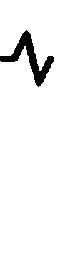

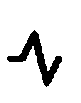

Results:
NCC mode:
1. :20/g scores: 0.998913938685
2. :25/e scores: 0.906843050856
3. :24/x scores: 0.905685565457
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g
Processed: 420/715
Processing:


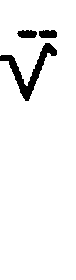

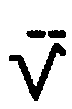

Results:
NCC mode:
1. :20/z scores: 1.0
2. :20/o scores: 0.912028458194
3. :6/q scores: 0.911562033942
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z
Processed: 421/715
Processing:


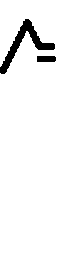

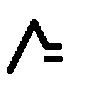

Results:
NCC mode:
1. :20/l scores: 1.0
2. :24/t scores: 0.940604897739
3. :20/a scores: 0.916051427839
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0l
Processed: 422/715
Processing:


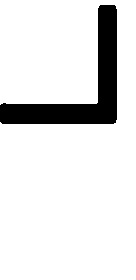

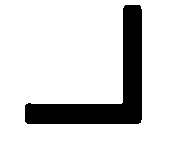

Results:
NCC mode:
1. :1/i scores: 1.0
2. :16/j scores: 0.97092867142
3. :12/n scores: 0.969613956376
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0li
Processed: 423/715
Processing:


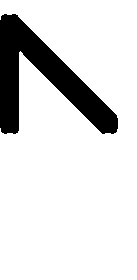

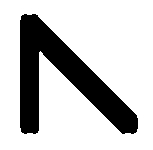

Results:
NCC mode:
1. :1/f scores: 1.0
2. :1/y scores: 0.918702181112
3. :1/o scores: 0.90943904229
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lif
Processed: 424/715
Processing:


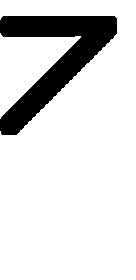

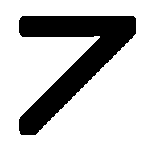

Results:
NCC mode:
1. :1/y scores: 1.0
2. :1/e scores: 0.926498639413
3. :27/x scores: 0.915681356908
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lify
Processed: 425/715
Processing:


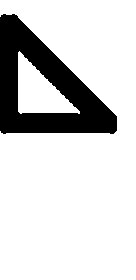

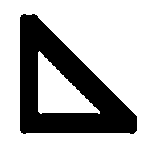

Results:
NCC mode:
1. :1/b scores: 1.0
2. :1/f scores: 0.918702181112
3. :16/s scores: 0.894249209764
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifyb
Processed: 426/715
Processing:


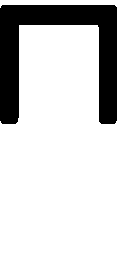

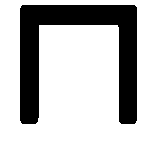

Results:
NCC mode:
1. :1/m scores: 1.0
2. :3/w scores: 0.95246291622
3. :12/r scores: 0.921458020737
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybm
Processed: 427/715
Processing:


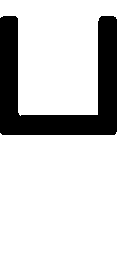

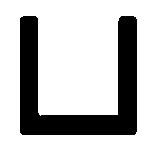

Results:
NCC mode:
1. :1/u scores: 1.0
2. :16/u scores: 0.963312019512
3. :9/m scores: 0.960938488456
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmu
Processed: 428/715
Processing:


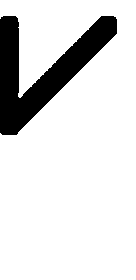

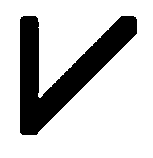

Results:
NCC mode:
1. :1/v scores: 1.0
2. :16/v scores: 0.967956129107
3. :1/t scores: 0.921570289497
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuv
Processed: 429/715
Processing:


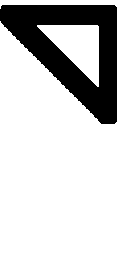

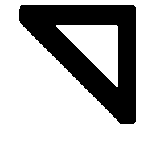

Results:
NCC mode:
1. :1/o scores: 1.0
2. :1/t scores: 0.933343747415
3. :1/n scores: 0.921524616122
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvo
Processed: 430/715
Processing:


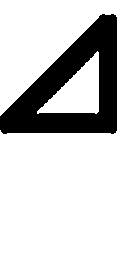

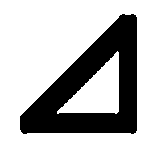

Results:
NCC mode:
1. :1/d scores: 1.0
2. :16/d scores: 0.93884395998
3. :1/r scores: 0.916800588661
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvod
Processed: 431/715
Processing:


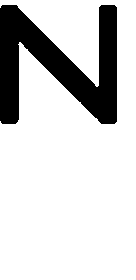

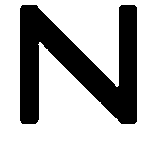

Results:
NCC mode:
1. :1/n scores: 1.0
2. :16/n scores: 0.948331650759
3. :1/i scores: 0.90943904229
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodn
Processed: 432/715
Processing:


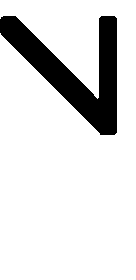

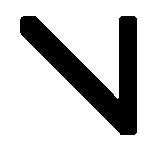

Results:
NCC mode:
1. :1/w scores: 1.0
2. :1/o scores: 0.921524616122
3. :1/d scores: 0.903816595345
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnw
Processed: 433/715
Processing:


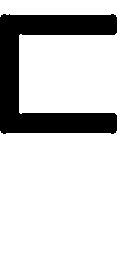

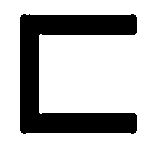

Results:
NCC mode:
1. :1/c scores: 1.0
2. :16/e scores: 0.930431727176
3. :27/e scores: 0.916224587149
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwc
Processed: 434/715
Processing:


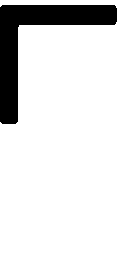

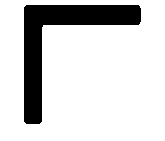

Results:
NCC mode:
1. :1/r scores: 1.0
2. :12/p scores: 0.973689071731
3. :16/k scores: 0.973139817969
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcr
Processed: 435/715
Processing:


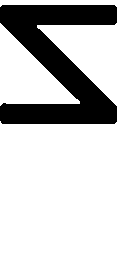

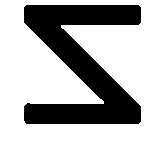

Results:
NCC mode:
1. :1/s scores: 1.0
2. :1/t scores: 0.892070625364
3. :16/s scores: 0.869568222545
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrs
Processed: 436/715
Processing:


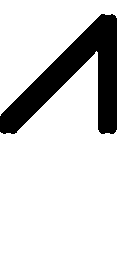

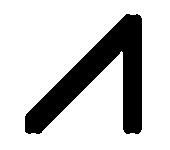

Results:
NCC mode:
1. :1/a scores: 1.0
2. :16/a scores: 0.959066209357
3. :23/a scores: 0.918381849226
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsa
Processed: 437/715
Processing:


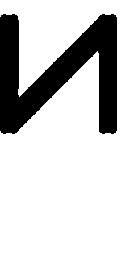

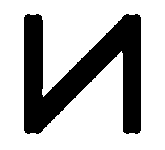

Results:
NCC mode:
1. :1/h scores: 1.0
2. :1/v scores: 0.909726030622
3. :1/s scores: 0.904388427825
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsah
Processed: 438/715
Processing:


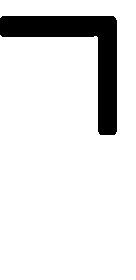

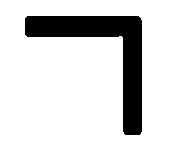

Results:
NCC mode:
1. :1/t scores: 1.0
2. :16/t scores: 0.961968629679
3. :12/q scores: 0.960954622521
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsaht
Processed: 439/715
Processing:


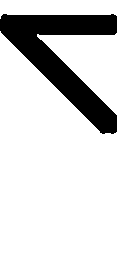

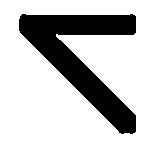

Results:
NCC mode:
1. :1/e scores: 1.0
2. :16/g scores: 0.955082585326
3. :1/v scores: 0.933343747415
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahte
Processed: 440/715
Processing:


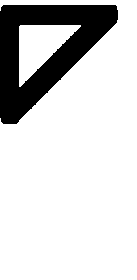

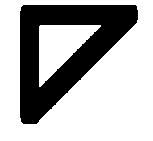

Results:
NCC mode:
1. :1/p scores: 1.0
2. :16/p scores: 0.95421009303
3. :1/f scores: 0.926498639413
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtep
Processed: 441/715
Processing:


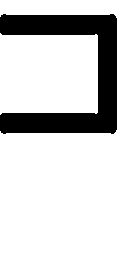

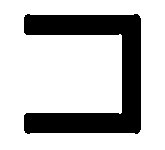

Results:
NCC mode:
1. :1/g scores: 1.0
2. :27/m scores: 0.904512096711
3. :20/l scores: 0.898382136614
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepg
Processed: 442/715
Processing:


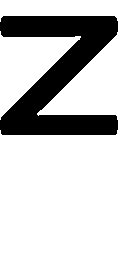

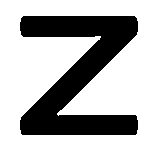

Results:
NCC mode:
1. :1/z scores: 1.0
2. :16/z scores: 0.93106517373
3. :1/f scores: 0.895805513554
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgz
Processed: 443/715
Processing:


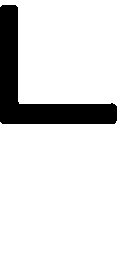

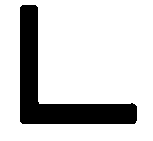

Results:
NCC mode:
1. :1/l scores: 1.0
2. :16/l scores: 0.975367668843
3. :12/o scores: 0.973425209303
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzl
Processed: 444/715
Processing:


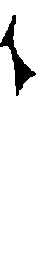

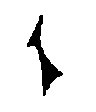

Results:
NCC mode:
1. :21/i scores: 1.0
2. :20/t scores: 0.914570031588
3. :5/n scores: 0.900668660972
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzli
Processed: 445/715
Processing:


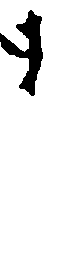

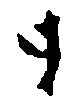

Results:
NCC mode:
1. :21/k scores: 0.998544161478
2. :5/j scores: 0.85786264976
3. :8/i scores: 0.847018370308
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlik
Processed: 446/715
Processing:


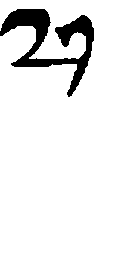

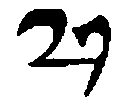

Results:
NCC mode:
1. :21/f scores: 1.0
2. :2/a scores: 0.888718488848
3. :26/x scores: 0.888202065621
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikf
Processed: 447/715
Processing:


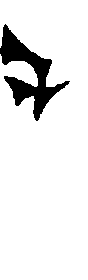

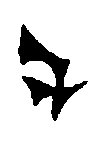

Results:
NCC mode:
1. :21/y scores: 1.0
2. :21/v scores: 0.873404628077
3. :14/y scores: 0.871060874495
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfy
Processed: 448/715
Processing:


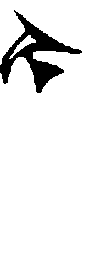

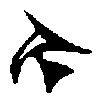

Results:
NCC mode:
1. :21/b scores: 1.0
2. :14/q scores: 0.907606893561
3. :5/n scores: 0.903109812794
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfyb
Processed: 449/715
Processing:


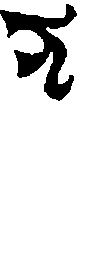

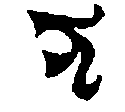

Results:
NCC mode:
1. :21/m scores: 0.999329728642
2. :11/p scores: 0.884209215677
3. :26/q scores: 0.859513405261
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybm
Processed: 450/715
Processing:


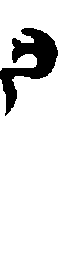

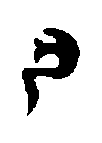

Results:
NCC mode:
1. :21/u scores: 1.0
2. :25/v scores: 0.860180954267
3. :8/s scores: 0.853038870499
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmu
Processed: 451/715
Processing:


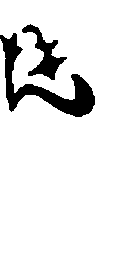

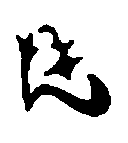

Results:
NCC mode:
1. :21/v scores: 1.0
2. :26/t scores: 0.915429518143
3. :26/f scores: 0.909930099297
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuv
Processed: 452/715
Processing:


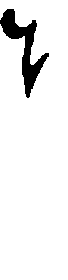

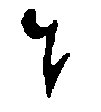

Results:
NCC mode:
1. :21/d scores: 1.0
2. :24/l scores: 0.891897324513
3. :8/e scores: 0.876971204409
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvd
Processed: 453/715
Processing:


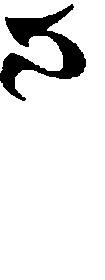

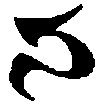

Results:
NCC mode:
1. :21/n scores: 1.0
2. :20/l scores: 0.87729650786
3. :15/y scores: 0.867080948891
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdn
Processed: 454/715
Processing:


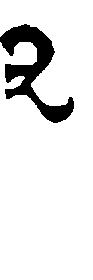

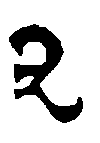

Results:
NCC mode:
1. :21/w scores: 1.0
2. :26/w scores: 0.895504833512
3. :26/n scores: 0.879790407691
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnw
Processed: 455/715
Processing:


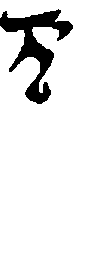

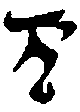

Results:
NCC mode:
1. :21/c scores: 0.99917140154
2. :14/u scores: 0.893071337492
3. :29/t scores: 0.890355489115
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwc
Processed: 456/715
Processing:


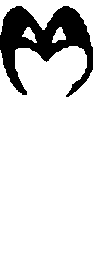

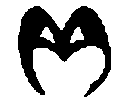

Results:
NCC mode:
1. :21/r scores: 1.0
2. :3/v scores: 0.88319512247
3. :8/y scores: 0.838158097182
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcr
Processed: 457/715
Processing:


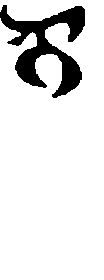

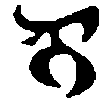

Results:
NCC mode:
1. :21/s scores: 0.999258462498
2. :25/l scores: 0.864396297163
3. :25/m scores: 0.86024377935
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrs
Processed: 458/715
Processing:


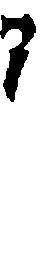

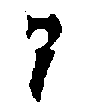

Results:
NCC mode:
1. :21/a scores: 0.965347821268
2. :27/x scores: 0.878404591316
3. :1/f scores: 0.868675921761
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsa
Processed: 459/715
Processing:


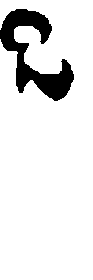

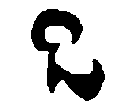

Results:
NCC mode:
1. :21/h scores: 1.0
2. :26/t scores: 0.873659030381
3. :26/h scores: 0.870832951276
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsah
Processed: 460/715
Processing:


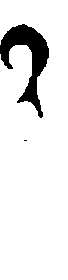

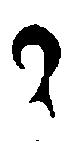

Results:
NCC mode:
1. :21/t scores: 1.0
2. :25/u scores: 0.866215838235
3. :25/u scores: 0.864842198213
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsaht
Processed: 461/715
Processing:


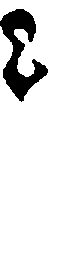

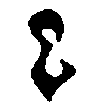

Results:
NCC mode:
1. :21/e scores: 1.0
2. :11/o scores: 0.841995613785
3. :18/l scores: 0.824734301146
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahte
Processed: 462/715
Processing:


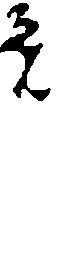

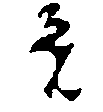

Results:
NCC mode:
1. :21/j scores: 0.994470374138
2. :29/n scores: 0.884465036815
3. :10/g scores: 0.882211110792
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtej
Processed: 463/715
Processing:


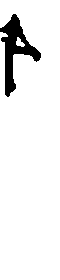

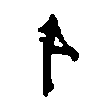

Results:
NCC mode:
1. :21/q scores: 1.0
2. :5/q scores: 0.874538001955
3. :11/q scores: 0.870895128664
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejq
Processed: 464/715
Processing:


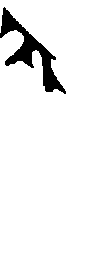

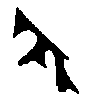

Results:
NCC mode:
1. :21/p scores: 1.0
2. :26/y scores: 0.911931215353
3. :26/w scores: 0.911270554245
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqp
Processed: 465/715
Processing:


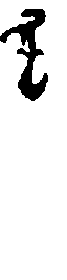

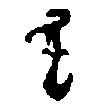

Results:
NCC mode:
1. :21/g scores: 1.0
2. :26/f scores: 0.875224305798
3. :11/c scores: 0.867467453336
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpg
Processed: 466/715
Processing:


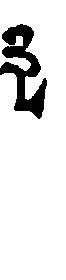

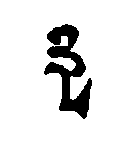

Results:
NCC mode:
1. :21/z scores: 0.997403301402
2. :26/w scores: 0.845758520272
3. :26/n scores: 0.841357317204
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgz
Processed: 467/715
Processing:


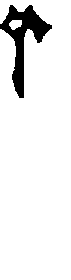

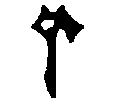

Results:
NCC mode:
1. :21/l scores: 0.997915229471
2. :29/t scores: 0.901733942933
3. :11/o scores: 0.894886628711
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzl
Processed: 468/715
Processing:


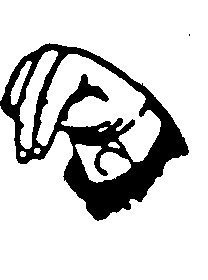

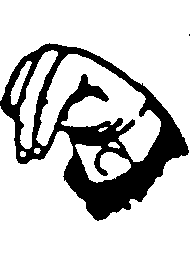

Results:
NCC mode:
1. :26/i scores: 1.0
2. :26/a scores: 0.979827850177
3. :8/f scores: 0.931200987849
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzli
Processed: 469/715
Processing:


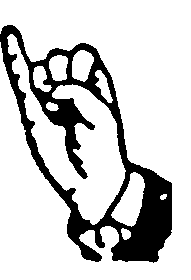

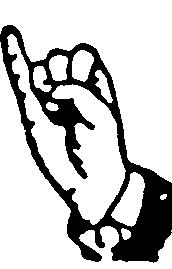

Results:
NCC mode:
1. :26/k scores: 1.0
2. :26/t scores: 0.975241269942
3. :26/n scores: 0.972517423729
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlik
Processed: 470/715
Processing:


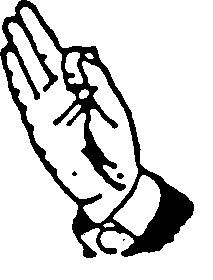

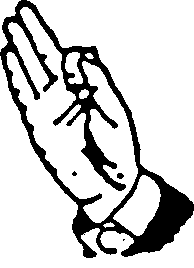

Results:
NCC mode:
1. :26/f scores: 1.0
2. :26/n scores: 0.977678831477
3. :26/m scores: 0.977198462542
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikf
Processed: 471/715
Processing:


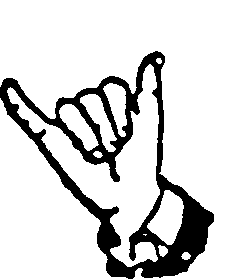

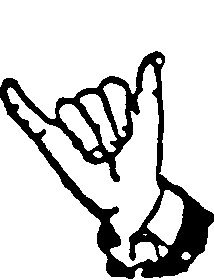

Results:
NCC mode:
1. :26/y scores: 1.0
2. :26/t scores: 0.971403301335
3. :26/k scores: 0.968435930207
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfy
Processed: 472/715
Processing:


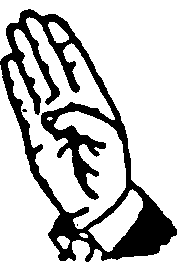

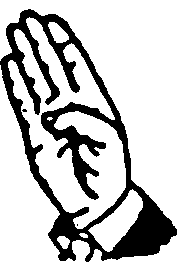

Results:
NCC mode:
1. :26/b scores: 1.0
2. :26/o scores: 0.9767887998
3. :26/m scores: 0.974069520125
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfyb
Processed: 473/715
Processing:


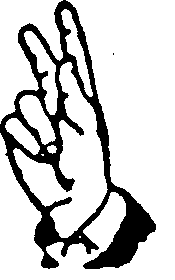

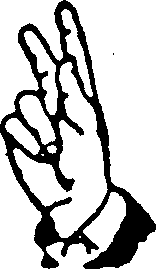

Results:
NCC mode:
1. :26/m scores: 1.0
2. :26/o scores: 0.973743123341
3. :26/o scores: 0.969816036483
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybm
Processed: 474/715
Processing:


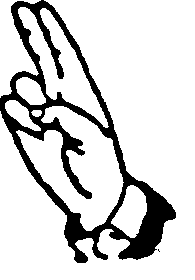

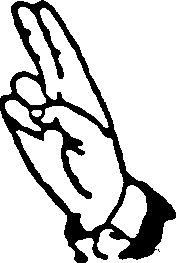

Results:
NCC mode:
1. :26/u scores: 1.0
2. :26/u scores: 0.978504224718
3. :26/v scores: 0.977118291422
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmu
Processed: 475/715
Processing:


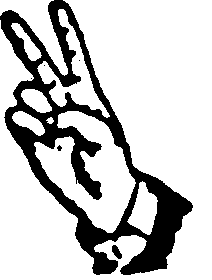

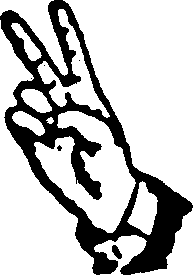

Results:
NCC mode:
1. :26/v scores: 1.0
2. :26/u scores: 0.978504224718
3. :26/p scores: 0.975394600101
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuv
Processed: 476/715
Processing:


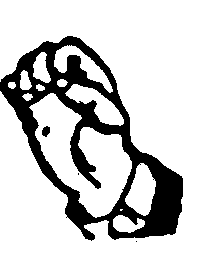

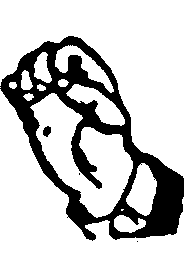

Results:
NCC mode:
1. :26/o scores: 0.999858668184
2. :26/t scores: 0.969449181049
3. :26/n scores: 0.96907498588
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvo
Processed: 477/715
Processing:


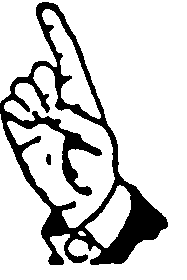

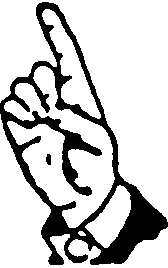

Results:
NCC mode:
1. :26/d scores: 1.0
2. :26/d scores: 0.976556614956
3. :26/b scores: 0.976364436389
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvod
Processed: 478/715
Processing:


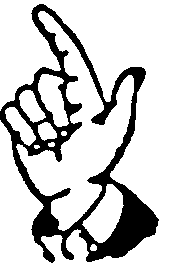

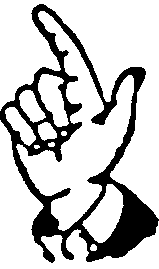

Results:
NCC mode:
1. :26/n scores: 1.0
2. :26/d scores: 0.974904124856
3. :26/m scores: 0.971137986364
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodn
Processed: 479/715
Processing:


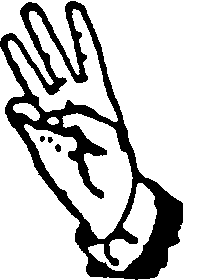

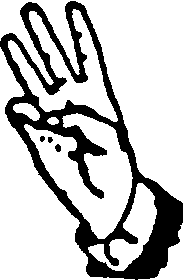

Results:
NCC mode:
1. :26/w scores: 1.0
2. :26/g scores: 0.977647449451
3. :26/f scores: 0.976219640424
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnw
Processed: 480/715
Processing:


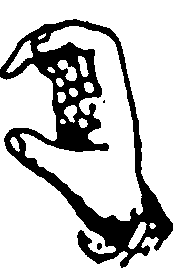

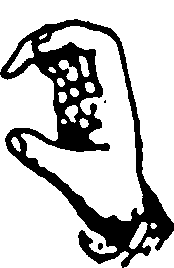

Results:
NCC mode:
1. :26/c scores: 0.999910938443
2. :26/z scores: 0.956391407486
3. :26/t scores: 0.949191426051
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwc
Processed: 481/715
Processing:


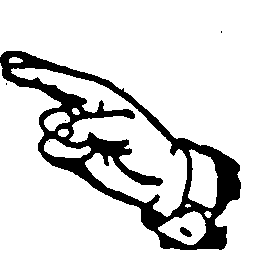

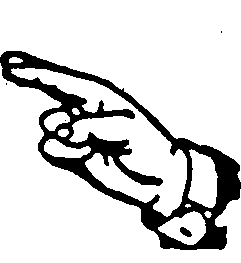

Results:
NCC mode:
1. :26/r scores: 1.0
2. :26/p scores: 0.973519107611
3. :26/g scores: 0.963767978032
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcr
Processed: 482/715
Processing:


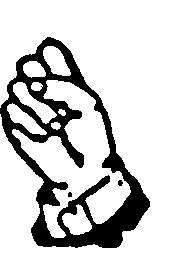

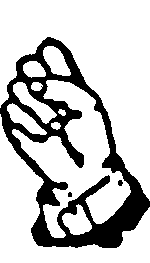

Results:
NCC mode:
1. :26/s scores: 1.0
2. :26/h scores: 0.967468804592
3. :26/h scores: 0.958631004174
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrs
Processed: 483/715
Processing:


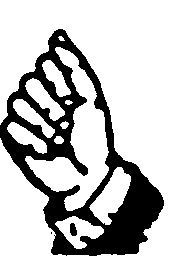

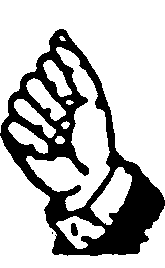

Results:
NCC mode:
1. :26/a scores: 0.999845018125
2. :26/h scores: 0.978208006559
3. :26/e scores: 0.967111610319
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsa
Processed: 484/715
Processing:


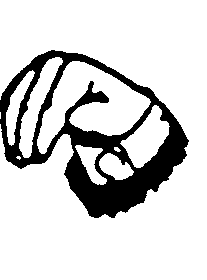

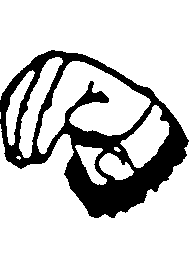

Results:
NCC mode:
1. :26/h scores: 1.0
2. :26/i scores: 0.981886664936
3. :6/v scores: 0.929085298732
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsah
Processed: 485/715
Processing:


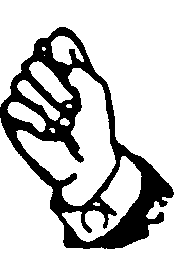

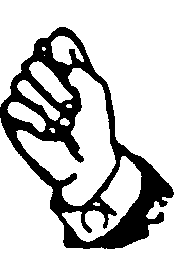

Results:
NCC mode:
1. :26/t scores: 1.0
2. :26/a scores: 0.978750631772
3. :26/s scores: 0.970950412537
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsaht
Processed: 486/715
Processing:


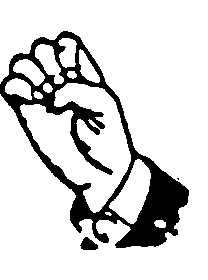

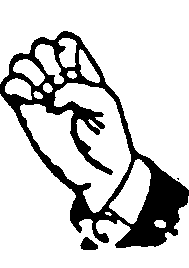

Results:
NCC mode:
1. :26/e scores: 1.0
2. :26/f scores: 0.979885743056
3. :26/k scores: 0.977517351884
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahte
Processed: 487/715
Processing:


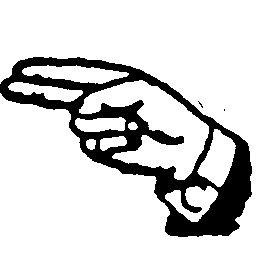

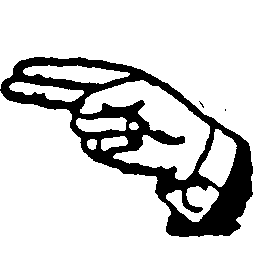

Results:
NCC mode:
1. :26/j scores: 0.999979574445
2. :26/p scores: 0.977462953385
3. :26/r scores: 0.963961996859
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtej
Processed: 488/715
Processing:


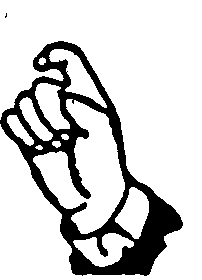

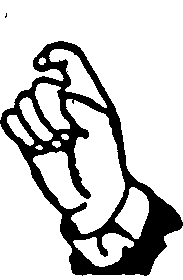

Results:
NCC mode:
1. :26/x scores: 1.0
2. :26/g scores: 0.977686059396
3. :26/u scores: 0.974788076331
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejx
Processed: 489/715
Processing:


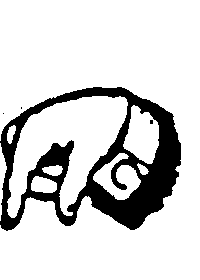

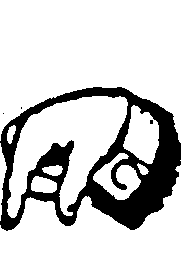

Results:
NCC mode:
1. :26/q scores: 1.0
2. :13/q scores: 0.926197420634
3. :25/e scores: 0.923556810435
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxq
Processed: 490/715
Processing:


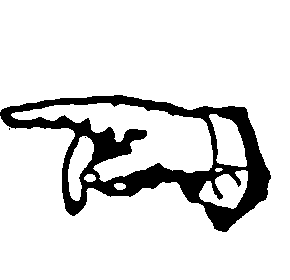

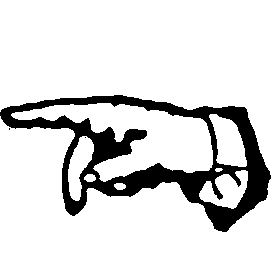

Results:
NCC mode:
1. :26/p scores: 1.0
2. :26/p scores: 0.967309723018
3. :26/j scores: 0.962634086006
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqp
Processed: 491/715
Processing:


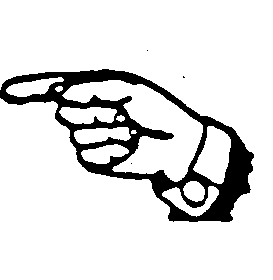

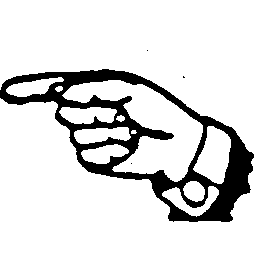

Results:
NCC mode:
1. :26/g scores: 1.0
2. :26/r scores: 0.98689889209
3. :26/e scores: 0.984195398605
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 492/715
Processing:


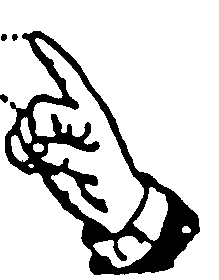

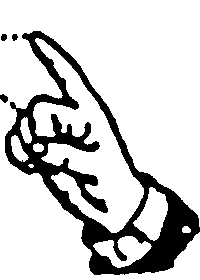

Results:
NCC mode:
1. :26/z scores: 1.0
2. :26/u scores: 0.979793009298
3. :26/n scores: 0.979579879973
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgz
Processed: 493/715
Processing:


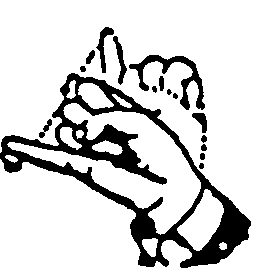

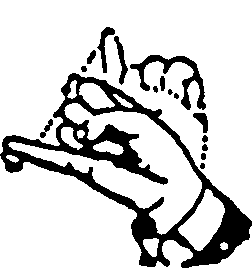

Results:
NCC mode:
1. :26/l scores: 0.99998650693
2. :26/y scores: 0.966753869187
3. :25/z scores: 0.964217426259
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 494/715
Processing:


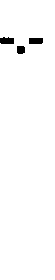

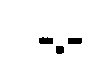

Results:
NCC mode:
1. :15/k scores: 1.0
2. :8/k scores: 0.9573202656
3. :14/u scores: 0.945220856265
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlk
Processed: 495/715
Processing:


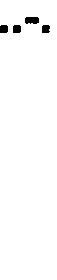

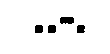

Results:
NCC mode:
1. :15/f scores: 1.0
2. :20/e scores: 0.926651194362
3. :13/k scores: 0.913566518289
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkf
Processed: 496/715
Processing:


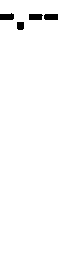

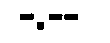

Results:
NCC mode:
1. :15/y scores: 1.0
2. :22/n scores: 0.945282950558
3. :8/z scores: 0.943341328749
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfy
Processed: 497/715
Processing:


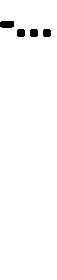

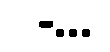

Results:
NCC mode:
1. :15/b scores: 1.0
2. :26/u scores: 0.91722166627
3. :26/v scores: 0.917092069701
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfyb
Processed: 498/715
Processing:


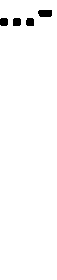

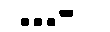

Results:
NCC mode:
1. :15/v scores: 1.0
2. :16/c scores: 0.910627015356
3. :14/q scores: 0.909346880694
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybv
Processed: 499/715
Processing:


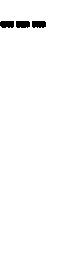

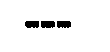

Results:
NCC mode:
1. :15/o scores: 1.0
2. :15/r scores: 0.92843985058
3. :23/z scores: 0.913635301347
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvo
Processed: 500/715
Processing:


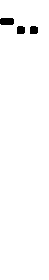

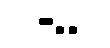

Results:
NCC mode:
1. :15/d scores: 1.0
2. :26/w scores: 0.90156605603
3. :14/y scores: 0.901289145103
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvod
Processed: 501/715
Processing:


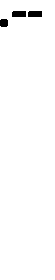

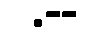

Results:
NCC mode:
1. :15/w scores: 1.0
2. :15/e scores: 0.962200773775
3. :15/s scores: 0.917154949132
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodw
Processed: 502/715
Processing:


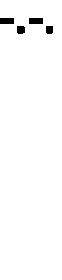

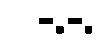

Results:
NCC mode:
1. :15/c scores: 1.0
2. :7/n scores: 0.927714377984
3. :24/c scores: 0.911891672825
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwc
Processed: 503/715
Processing:


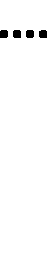

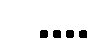

Results:
NCC mode:
1. :15/h scores: 1.0
2. :23/k scores: 0.92156941059
3. :7/n scores: 0.910862589501
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwch
Processed: 504/715
Processing:


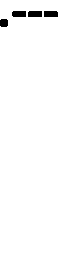

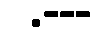

Results:
NCC mode:
1. :15/j scores: 1.0
2. :15/w scores: 0.970712375552
3. :23/s scores: 0.965916685602
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchj
Processed: 505/715
Processing:


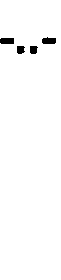

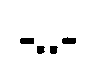

Results:
NCC mode:
1. :15/x scores: 1.0
2. :24/e scores: 0.953456273661
3. :8/k scores: 0.949055447277
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjx
Processed: 506/715
Processing:


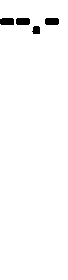

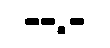

Results:
NCC mode:
1. :15/q scores: 1.0
2. :21/f scores: 0.922007752214
3. :20/n scores: 0.920565689614
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxq
Processed: 507/715
Processing:


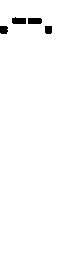

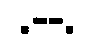

Results:
NCC mode:
1. :15/p scores: 1.0
2. :15/r scores: 0.941509295583
3. :24/h scores: 0.927690019213
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqp
Processed: 508/715
Processing:


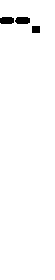

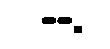

Results:
NCC mode:
1. :15/g scores: 1.0
2. :15/n scores: 0.908699217843
3. :14/s scores: 0.899358855646
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpg
Processed: 509/715
Processing:


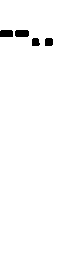

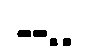

Results:
NCC mode:
1. :15/z scores: 0.999050908501
2. :26/j scores: 0.93692913147
3. :15/d scores: 0.935472161994
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgz
Processed: 510/715
Processing:


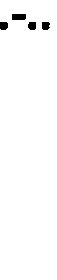

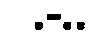

Results:
NCC mode:
1. :15/l scores: 1.0
2. :14/o scores: 0.918493614041
3. :24/s scores: 0.915921329453
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzl
Processed: 511/715
Processing:


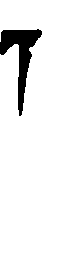

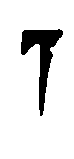

Results:
NCC mode:
1. :3/i scores: 1.0
2. :3/z scores: 0.895922540186
3. :8/y scores: 0.885011330447
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzli
Processed: 512/715
Processing:


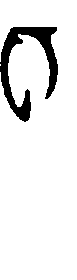

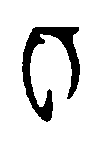

Results:
NCC mode:
1. :3/k scores: 1.0
2. :19/o scores: 0.901276471823
3. :3/u scores: 0.901257796187
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlik
Processed: 513/715
Processing:


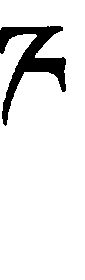

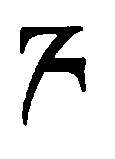

Results:
NCC mode:
1. :3/f scores: 1.0
2. :6/v scores: 0.859584788423
3. :6/f scores: 0.857890783376
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikf
Processed: 514/715
Processing:


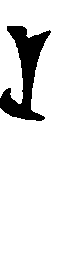

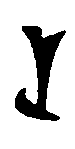

Results:
NCC mode:
1. :3/y scores: 1.0
2. :11/w scores: 0.868227160281
3. :11/p scores: 0.861645845992
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfy
Processed: 515/715
Processing:


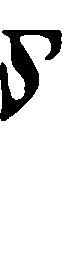

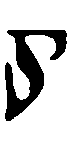

Results:
NCC mode:
1. :3/b scores: 1.0
2. :14/l scores: 0.862563540486
3. :18/p scores: 0.860391777305
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfyb
Processed: 516/715
Processing:


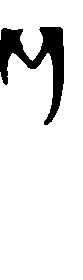

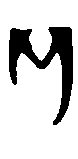

Results:
NCC mode:
1. :3/m scores: 1.0
2. :3/v scores: 0.899060499523
3. :3/t scores: 0.888042240379
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybm
Processed: 517/715
Processing:


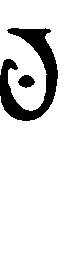

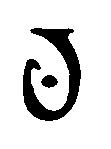

Results:
NCC mode:
1. :3/u scores: 1.0
2. :3/u scores: 0.889356026525
3. :12/a scores: 0.882059065128
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmu
Processed: 518/715
Processing:


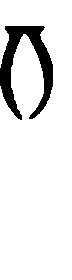

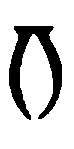

Results:
NCC mode:
1. :3/v scores: 1.0
2. :12/d scores: 0.907526933992
3. :12/t scores: 0.903824303979
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuv
Processed: 519/715
Processing:


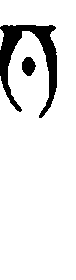

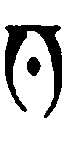

Results:
NCC mode:
1. :3/o scores: 1.0
2. :3/k scores: 0.901257796187
3. :3/b scores: 0.897999198719
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvo
Processed: 520/715
Processing:


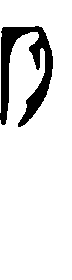

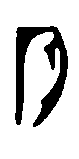

Results:
NCC mode:
1. :3/d scores: 1.0
2. :12/p scores: 0.855336933436
3. :13/x scores: 0.851912383599
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvod
Processed: 521/715
Processing:


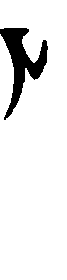

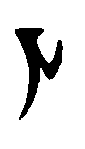

Results:
NCC mode:
1. :3/n scores: 1.0
2. :18/s scores: 0.854266130183
3. :20/i scores: 0.853603883143
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodn
Processed: 522/715
Processing:


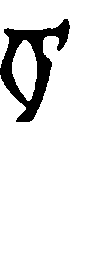

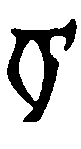

Results:
NCC mode:
1. :3/w scores: 1.0
2. :3/a scores: 0.881843632442
3. :25/y scores: 0.877967966817
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnw
Processed: 523/715
Processing:


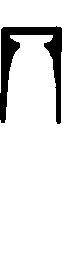

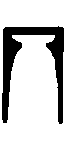

Results:
NCC mode:
1. :3/c scores: 1.0
2. :1/m scores: 0.948388753456
3. :16/h scores: 0.929179523814
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwc
Processed: 524/715
Processing:


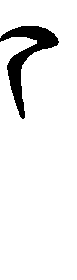

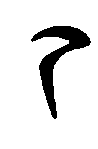

Results:
NCC mode:
1. :3/r scores: 0.99865290745
2. :8/j scores: 0.891249378272
3. :11/v scores: 0.882114019201
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcr
Processed: 525/715
Processing:


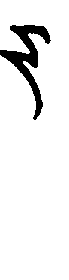

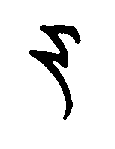

Results:
NCC mode:
1. :3/s scores: 0.999163963601
2. :16/g scores: 0.884878761846
3. :25/m scores: 0.8811002567
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrs
Processed: 526/715
Processing:


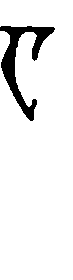

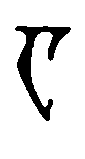

Results:
NCC mode:
1. :3/a scores: 0.99773151414
2. :6/m scores: 0.887167528832
3. :6/u scores: 0.886961099646
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsa
Processed: 527/715
Processing:


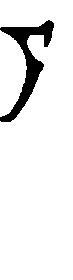

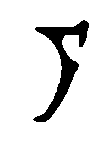

Results:
NCC mode:
1. :3/h scores: 0.995832719962
2. :11/e scores: 0.891897719525
3. :13/q scores: 0.888479451125
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsah
Processed: 528/715
Processing:


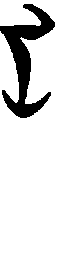

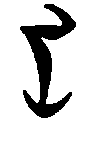

Results:
NCC mode:
1. :3/t scores: 0.998188474371
2. :27/a scores: 0.857847904503
3. :14/z scores: 0.855377046288
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsaht
Processed: 529/715
Processing:


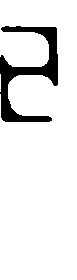

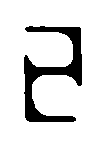

Results:
NCC mode:
1. :3/e scores: 1.0
2. :12/s scores: 0.884652683645
3. :7/j scores: 0.877413971869
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahte
Processed: 530/715
Processing:


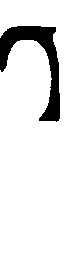

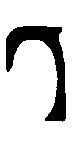

Results:
NCC mode:
1. :3/j scores: 1.0
2. :1/t scores: 0.933678656717
3. :12/q scores: 0.908204676342
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtej
Processed: 531/715
Processing:


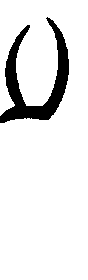

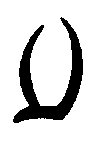

Results:
NCC mode:
1. :3/x scores: 0.998443600752
2. :28/j scores: 0.869966726268
3. :13/d scores: 0.867625343951
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejx
Processed: 532/715
Processing:


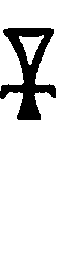

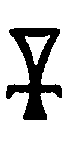

Results:
NCC mode:
1. :3/q scores: 1.0
2. :3/z scores: 0.898995929721
3. :3/q scores: 0.841136754063
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxq
Processed: 533/715
Processing:


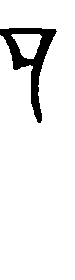

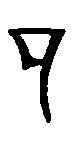

Results:
NCC mode:
1. :3/p scores: 0.998821039119
2. :14/t scores: 0.895534505299
3. :8/i scores: 0.887534550751
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqp
Processed: 534/715
Processing:


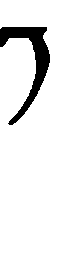

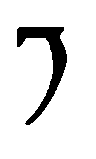

Results:
NCC mode:
1. :3/g scores: 1.0
2. :6/o scores: 0.889043850862
3. :6/y scores: 0.888219761009
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 535/715
Processing:


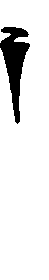

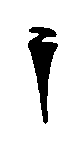

Results:
NCC mode:
1. :3/z scores: 1.0
2. :30/z scores: 0.897692914148
3. :15/l scores: 0.85629857438
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgz
Processed: 536/715
Processing:


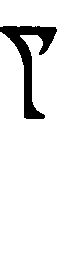

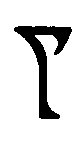

Results:
NCC mode:
1. :3/l scores: 0.998805630202
2. :28/t scores: 0.90266770777
3. :3/x scores: 0.901552074543
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 537/715
Processing:


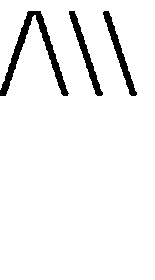

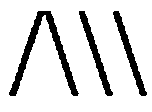

Results:
NCC mode:
1. :24/i scores: 0.999764405394
2. :24/n scores: 0.97913184449
3. :24/p scores: 0.978172443487
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzli
Processed: 538/715
Processing:


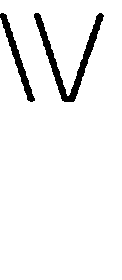

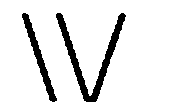

Results:
NCC mode:
1. :24/k scores: 1.0
2. :24/v scores: 0.961337401258
3. :24/b scores: 0.957166266381
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlik
Processed: 539/715
Processing:


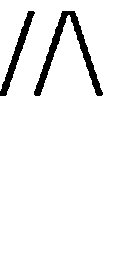

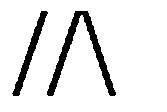

Results:
NCC mode:
1. :24/f scores: 0.999420919581
2. :24/w scores: 0.960992963273
3. :24/c scores: 0.9608092276
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikf
Processed: 540/715
Processing:


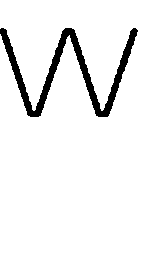

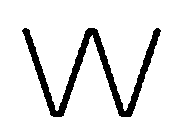

Results:
NCC mode:
1. :24/y scores: 0.999789850307
2. :24/z scores: 0.97974035967
3. :24/d scores: 0.978879339901
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfy
Processed: 541/715
Processing:


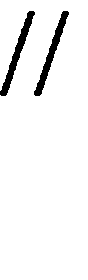

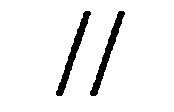

Results:
NCC mode:
1. :24/b scores: 1.0
2. :24/e scores: 0.921587820731
3. :6/q scores: 0.920834294688
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfyb
Processed: 542/715
Processing:


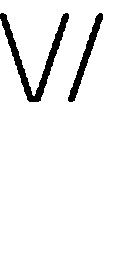

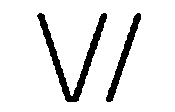

Results:
NCC mode:
1. :24/m scores: 0.999520601753
2. :24/r scores: 0.96149536316
3. :24/w scores: 0.961012394868
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybm
Processed: 543/715
Processing:


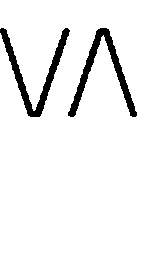

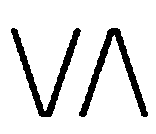

Results:
NCC mode:
1. :24/u scores: 1.0
2. :24/u scores: 0.979513495987
3. :24/a scores: 0.97891658194
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmu
Processed: 544/715
Processing:


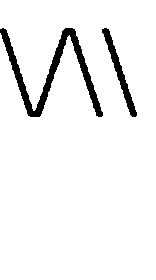

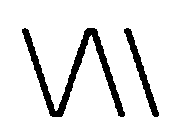

Results:
NCC mode:
1. :24/v scores: 1.0
2. :24/u scores: 0.979513495987
3. :24/y scores: 0.978609216777
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuv
Processed: 545/715
Processing:


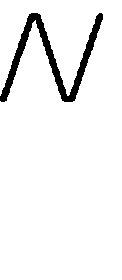

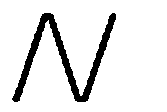

Results:
NCC mode:
1. :24/o scores: 0.999532053334
2. :24/k scores: 0.961958309795
3. :24/s scores: 0.961673363435
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvo
Processed: 546/715
Processing:


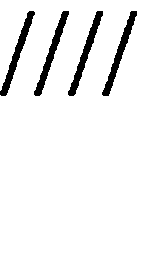

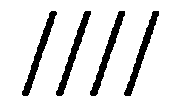

Results:
NCC mode:
1. :24/d scores: 1.0
2. :24/c scores: 0.978063474914
3. :24/x scores: 0.977855081224
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvod
Processed: 547/715
Processing:


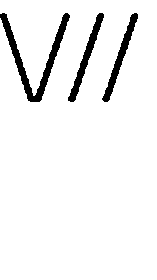

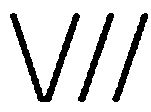

Results:
NCC mode:
1. :24/n scores: 1.0
2. :24/j scores: 0.979609010979
3. :24/y scores: 0.979071729961
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodn
Processed: 548/715
Processing:


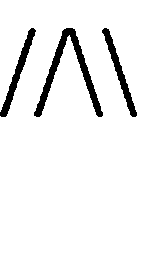

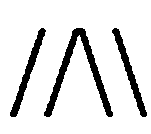

Results:
NCC mode:
1. :24/w scores: 1.0
2. :24/i scores: 0.978583185954
3. :24/q scores: 0.978110371291
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnw
Processed: 549/715
Processing:


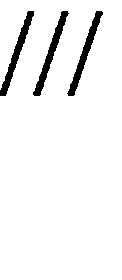

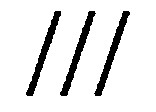

Results:
NCC mode:
1. :24/c scores: 0.99939407741
2. :24/m scores: 0.960826125832
3. :24/f scores: 0.960069885443
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwc
Processed: 550/715
Processing:


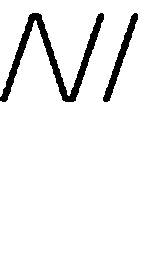

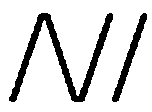

Results:
NCC mode:
1. :24/r scores: 1.0
2. :24/x scores: 0.979327222801
3. :24/p scores: 0.978644648841
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcr
Processed: 551/715
Processing:


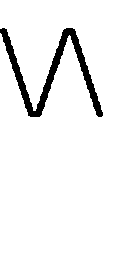

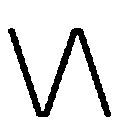

Results:
NCC mode:
1. :24/s scores: 1.0
2. :24/m scores: 0.962629189862
3. :24/f scores: 0.960436340294
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrs
Processed: 552/715
Processing:


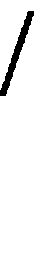

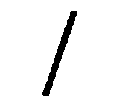

Results:
NCC mode:
1. :24/a scores: 0.997343899077
2. :16/i scores: 0.980714641239
3. :27/x scores: 0.952983327348
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsa
Processed: 553/715
Processing:


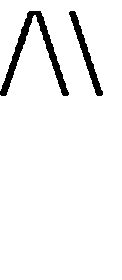

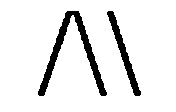

Results:
NCC mode:
1. :24/h scores: 1.0
2. :24/o scores: 0.961607834991
3. :24/f scores: 0.958918746386
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsah
Processed: 554/715
Processing:


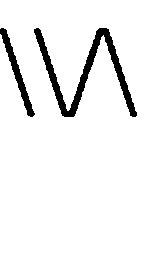

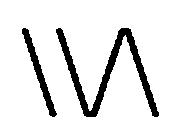

Results:
NCC mode:
1. :24/t scores: 1.0
2. :24/u scores: 0.97891658194
3. :24/p scores: 0.978529420351
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaht
Processed: 555/715
Processing:


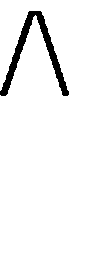

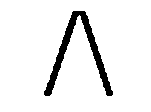

Results:
NCC mode:
1. :24/e scores: 1.0
2. :20/l scores: 0.936437947819
3. :27/w scores: 0.921342090727
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahte
Processed: 556/715
Processing:


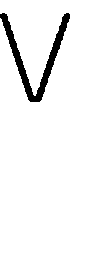

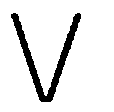

Results:
NCC mode:
1. :24/j scores: 1.0
2. :20/o scores: 0.940433480442
3. :6/q scores: 0.936563534832
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtej
Processed: 557/715
Processing:


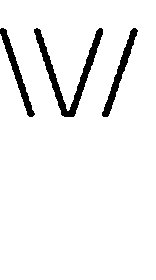

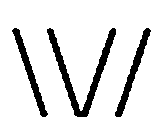

Results:
NCC mode:
1. :24/x scores: 0.999692983606
2. :24/z scores: 0.979196054783
3. :24/n scores: 0.978812922018
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejx
Processed: 558/715
Processing:


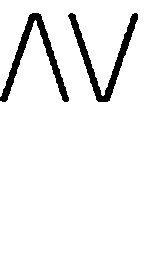

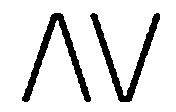

Results:
NCC mode:
1. :24/q scores: 1.0
2. :24/q scores: 0.979417735837
3. :24/r scores: 0.979327222801
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxq
Processed: 559/715
Processing:


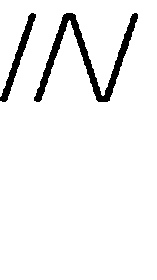

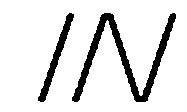

Results:
NCC mode:
1. :24/p scores: 1.0
2. :24/q scores: 0.979417735837
3. :24/y scores: 0.978983468052
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqp
Processed: 560/715
Processing:


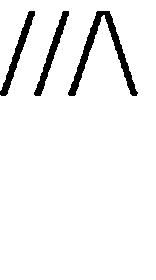

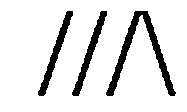

Results:
NCC mode:
1. :24/g scores: 1.0
2. :24/g scores: 0.97859484828
3. :24/w scores: 0.978110371291
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 561/715
Processing:


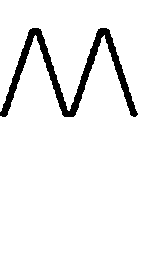

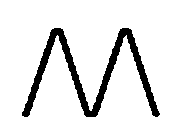

Results:
NCC mode:
1. :24/z scores: 1.0
2. :24/i scores: 0.978811356068
3. :24/c scores: 0.978644648841
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgz
Processed: 562/715
Processing:


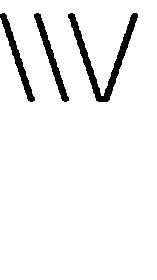

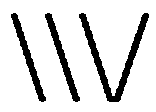

Results:
NCC mode:
1. :24/l scores: 1.0
2. :24/y scores: 0.979417154705
3. :24/j scores: 0.979115191246
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 563/715
Processing:


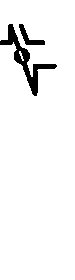

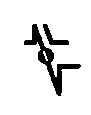

Results:
NCC mode:
1. :5/i scores: 1.0
2. :14/y scores: 0.924048571317
3. :26/c scores: 0.919128000751
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzli
Processed: 564/715
Processing:


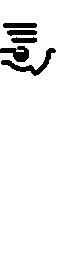

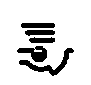

Results:
NCC mode:
1. :5/k scores: 0.998762763286
2. :26/c scores: 0.910789188845
3. :26/m scores: 0.902800657092
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlik
Processed: 565/715
Processing:


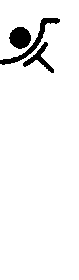

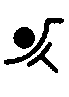

Results:
NCC mode:
1. :5/f scores: 1.0
2. :14/k scores: 0.901421891557
3. :14/z scores: 0.90060073059
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikf
Processed: 566/715
Processing:


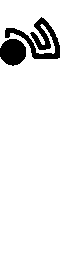

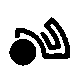

Results:
NCC mode:
1. :5/y scores: 0.99812815982
2. :17/t scores: 0.864077275504
3. :25/h scores: 0.859047795438
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfy
Processed: 567/715
Processing:


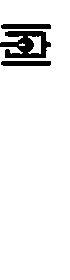

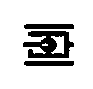

Results:
NCC mode:
1. :5/b scores: 1.0
2. :3/l scores: 0.8610500867
3. :5/v scores: 0.84950851735
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfyb
Processed: 568/715
Processing:


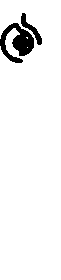

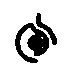

Results:
NCC mode:
1. :5/m scores: 1.0
2. :18/b scores: 0.860317013872
3. :13/p scores: 0.856277318668
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybm
Processed: 569/715
Processing:


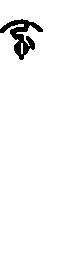

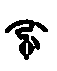

Results:
NCC mode:
1. :5/u scores: 1.0
2. :29/t scores: 0.917935294569
3. :18/b scores: 0.908049933198
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmu
Processed: 570/715
Processing:


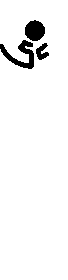

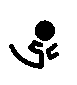

Results:
NCC mode:
1. :5/v scores: 0.998081966082
2. :25/s scores: 0.877960099244
3. :13/k scores: 0.87784612614
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuv
Processed: 571/715
Processing:


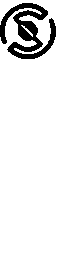

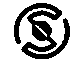

Results:
NCC mode:
1. :5/o scores: 1.0
2. :19/v scores: 0.918668799083
3. :19/j scores: 0.905063549473
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvo
Processed: 572/715
Processing:


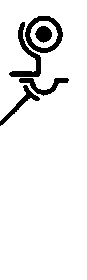

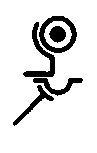

Results:
NCC mode:
1. :5/d scores: 0.999496809503
2. :6/j scores: 0.929256620754
3. :25/b scores: 0.924736374442
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvod
Processed: 573/715
Processing:


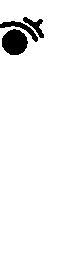

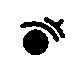

Results:
NCC mode:
1. :5/n scores: 0.995655245595
2. :10/c scores: 0.82926684576
3. :21/s scores: 0.827422684576
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodn
Processed: 574/715
Processing:


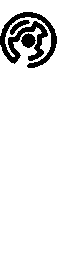

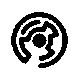

Results:
NCC mode:
1. :5/w scores: 1.0
2. :5/o scores: 0.903563361874
3. :19/v scores: 0.891242102066
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnw
Processed: 575/715
Processing:


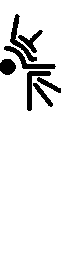

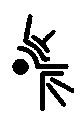

Results:
NCC mode:
1. :5/c scores: 0.998884534372
2. :26/l scores: 0.9311171061
3. :26/z scores: 0.928122243523
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwc
Processed: 576/715
Processing:


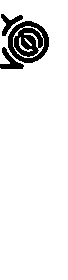

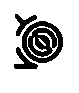

Results:
NCC mode:
1. :5/r scores: 1.0
2. :5/p scores: 0.840776168359
3. :13/p scores: 0.839112855295
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcr
Processed: 577/715
Processing:


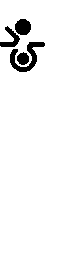

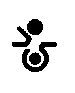

Results:
NCC mode:
1. :5/s scores: 1.0
2. :10/e scores: 0.91052825407
3. :30/r scores: 0.888449863389
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrs
Processed: 578/715
Processing:


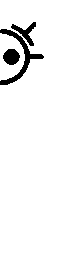

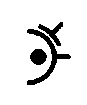

Results:
NCC mode:
1. :5/a scores: 1.0
2. :5/d scores: 0.88214207603
3. :2/h scores: 0.878061513528
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsa
Processed: 579/715
Processing:


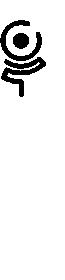

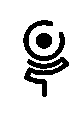

Results:
NCC mode:
1. :5/h scores: 1.0
2. :29/x scores: 0.872411181463
3. :6/q scores: 0.867414544116
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsah
Processed: 580/715
Processing:


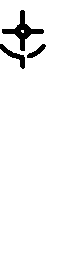

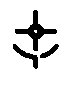

Results:
NCC mode:
1. :5/t scores: 1.0
2. :29/x scores: 0.931072361652
3. :11/b scores: 0.923282057647
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaht
Processed: 581/715
Processing:


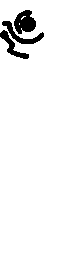

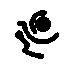

Results:
NCC mode:
1. :5/e scores: 1.0
2. :10/h scores: 0.869989109372
3. :10/a scores: 0.864695028061
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahte
Processed: 582/715
Processing:


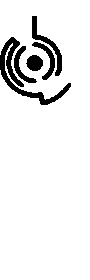

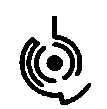

Results:
NCC mode:
1. :5/j scores: 0.999187695108
2. :26/l scores: 0.915814728128
3. :26/n scores: 0.91343378574
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtej
Processed: 583/715
Processing:


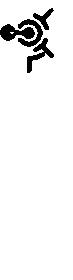

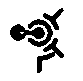

Results:
NCC mode:
1. :5/x scores: 1.0
2. :25/s scores: 0.902349247209
3. :14/h scores: 0.900930225562
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejx
Processed: 584/715
Processing:


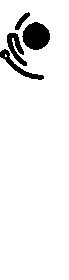

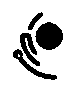

Results:
NCC mode:
1. :5/q scores: 1.0
2. :10/c scores: 0.883053998321
3. :25/w scores: 0.875846900849
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxq
Processed: 585/715
Processing:


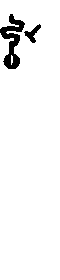

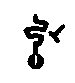

Results:
NCC mode:
1. :5/p scores: 0.995840134375
2. :21/q scores: 0.890647680696
3. :25/v scores: 0.885440636151
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqp
Processed: 586/715
Processing:


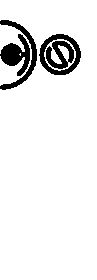

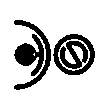

Results:
NCC mode:
1. :5/g scores: 1.0
2. :5/z scores: 0.905987725056
3. :15/m scores: 0.887911292894
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 587/715
Processing:


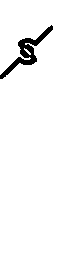

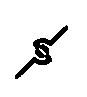

Results:
NCC mode:
1. :5/z scores: 1.0
2. :16/i scores: 0.967814874707
3. :24/s scores: 0.949837808744
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgz
Processed: 588/715
Processing:


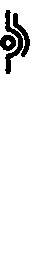

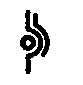

Results:
NCC mode:
1. :5/l scores: 1.0
2. :5/g scores: 0.858855346383
3. :8/v scores: 0.843596476212
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 589/715
Processing:


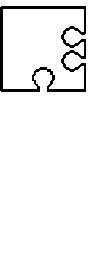

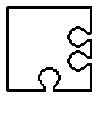

Results:
NCC mode:
1. :6/i scores: 1.0
2. :6/i scores: 0.995726829301
3. :6/h scores: 0.994547400205
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzli
Processed: 590/715
Processing:


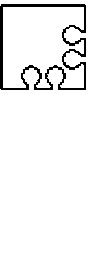

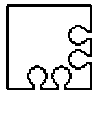

Results:
NCC mode:
1. :6/k scores: 1.0
2. :6/i scores: 0.995726829301
3. :6/o scores: 0.994964639084
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlik
Processed: 591/715
Processing:


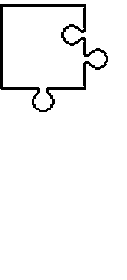

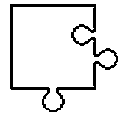

Results:
NCC mode:
1. :6/f scores: 1.0
2. :6/g scores: 0.999056604333
3. :6/u scores: 0.997786793985
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikf
Processed: 592/715
Processing:


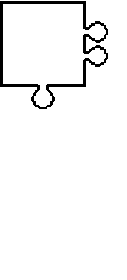

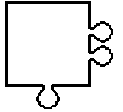

Results:
NCC mode:
1. :6/y scores: 1.0
2. :6/v scores: 0.998743021507
3. :6/y scores: 0.998666143081
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfy
Processed: 593/715
Processing:


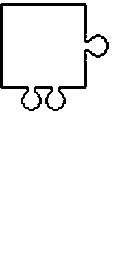

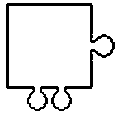

Results:
NCC mode:
1. :6/b scores: 1.0
2. :6/v scores: 0.999064137489
3. :6/y scores: 0.998562506151
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfyb
Processed: 594/715
Processing:


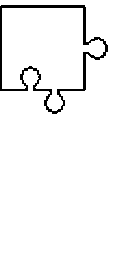

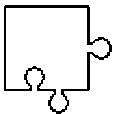

Results:
NCC mode:
1. :6/m scores: 1.0
2. :6/v scores: 0.997853661462
3. :6/j scores: 0.997551342944
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybm
Processed: 595/715
Processing:


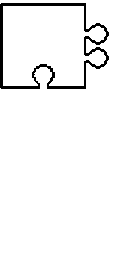

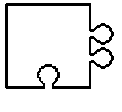

Results:
NCC mode:
1. :6/u scores: 1.0
2. :6/h scores: 0.998584203894
3. :6/c scores: 0.997749520426
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmu
Processed: 596/715
Processing:


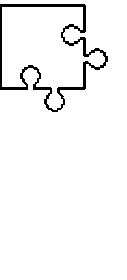

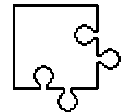

Results:
NCC mode:
1. :6/v scores: 1.0
2. :6/f scores: 0.997786793985
3. :6/p scores: 0.997555628744
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuv
Processed: 597/715
Processing:


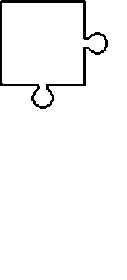

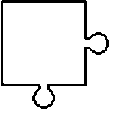

Results:
NCC mode:
1. :6/o scores: 1.0
2. :6/b scores: 0.99904513484
3. :6/y scores: 0.998743021507
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvo
Processed: 598/715
Processing:


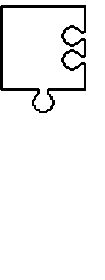

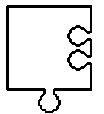

Results:
NCC mode:
1. :6/d scores: 1.0
2. :6/s scores: 0.995869270026
3. :6/y scores: 0.99424167514
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvod
Processed: 599/715
Processing:


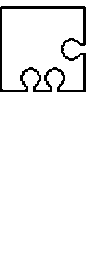

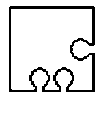

Results:
NCC mode:
1. :6/n scores: 1.0
2. :6/k scores: 0.994964639084
3. :6/h scores: 0.994671725158
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodn
Processed: 600/715
Processing:


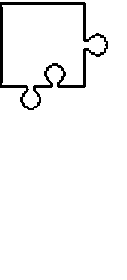

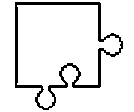

Results:
NCC mode:
1. :6/w scores: 1.0
2. :6/o scores: 0.997247643248
3. :6/b scores: 0.997237441276
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnw
Processed: 601/715
Processing:


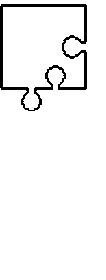

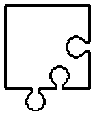

Results:
NCC mode:
1. :6/c scores: 1.0
2. :6/s scores: 0.995846695675
3. :6/x scores: 0.994676811809
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwc
Processed: 602/715
Processing:


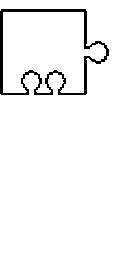

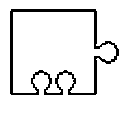

Results:
NCC mode:
1. :6/r scores: 1.0
2. :6/h scores: 0.999092876822
3. :6/u scores: 0.997749520426
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcr
Processed: 603/715
Processing:


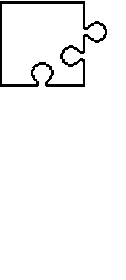

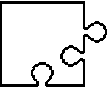

Results:
NCC mode:
1. :6/s scores: 1.0
2. :6/h scores: 0.996269583227
3. :6/r scores: 0.995503364079
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrs
Processed: 604/715
Processing:


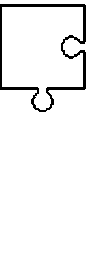

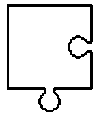

Results:
NCC mode:
1. :6/a scores: 1.0
2. :6/q scores: 0.996461409735
3. :6/d scores: 0.995869270026
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsa
Processed: 605/715
Processing:


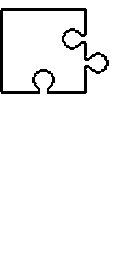

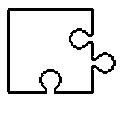

Results:
NCC mode:
1. :6/h scores: 1.0
2. :6/h scores: 0.997006708656
3. :6/r scores: 0.99604462173
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsah
Processed: 606/715
Processing:


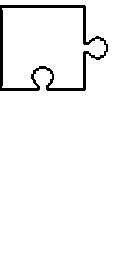

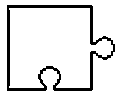

Results:
NCC mode:
1. :6/t scores: 1.0
2. :6/r scores: 0.999092876822
3. :6/u scores: 0.998584203894
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaht
Processed: 607/715
Processing:


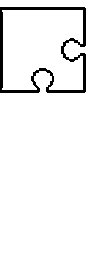

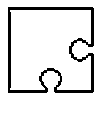

Results:
NCC mode:
1. :6/e scores: 1.0
2. :7/j scores: 0.994862714343
3. :6/n scores: 0.994671725158
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahte
Processed: 608/715
Processing:


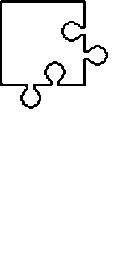

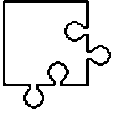

Results:
NCC mode:
1. :6/j scores: 1.0
2. :6/w scores: 0.997169707676
3. :6/p scores: 0.996993314152
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtej
Processed: 609/715
Processing:


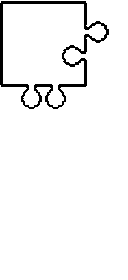

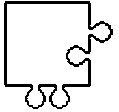

Results:
NCC mode:
1. :6/x scores: 1.0
2. :6/p scores: 0.99929882793
3. :6/b scores: 0.997414816008
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejx
Processed: 610/715
Processing:


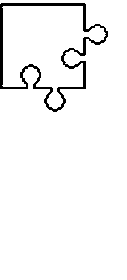

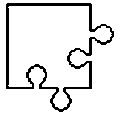

Results:
NCC mode:
1. :6/q scores: 1.0
2. :6/m scores: 0.997551342944
3. :6/q scores: 0.997532006335
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxq
Processed: 611/715
Processing:


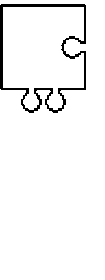

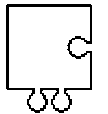

Results:
NCC mode:
1. :6/p scores: 1.0
2. :6/a scores: 0.996461409735
3. :6/g scores: 0.995391885713
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqp
Processed: 612/715
Processing:


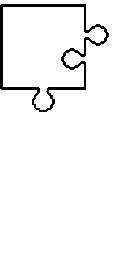

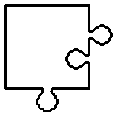

Results:
NCC mode:
1. :6/g scores: 1.0
2. :6/x scores: 0.99929882793
3. :6/x scores: 0.997532081565
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 613/715
Processing:


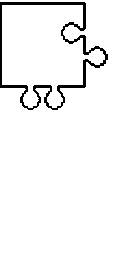

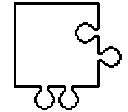

Results:
NCC mode:
1. :6/z scores: 1.0
2. :6/f scores: 0.999056604333
3. :6/u scores: 0.997555628744
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgz
Processed: 614/715
Processing:


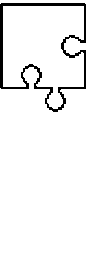

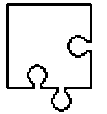

Results:
NCC mode:
1. :6/l scores: 1.0
2. :6/p scores: 0.995391885713
3. :6/a scores: 0.994085357032
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 615/715
Processing:


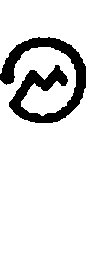

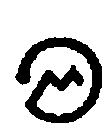

Results:
NCC mode:
1. :10/i scores: 0.998485815229
2. :12/y scores: 0.940278823868
3. :19/a scores: 0.931500153234
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzli
Processed: 616/715
Processing:


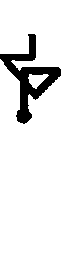

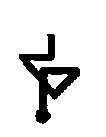

Results:
NCC mode:
1. :10/k scores: 1.0
2. :29/e scores: 0.885081103484
3. :18/f scores: 0.8820198017
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlik
Processed: 617/715
Processing:


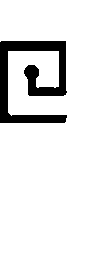

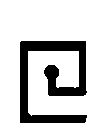

Results:
NCC mode:
1. :10/f scores: 1.0
2. :12/f scores: 0.90630558419
3. :16/h scores: 0.903729131543
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikf
Processed: 618/715
Processing:


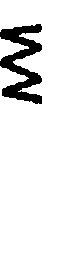

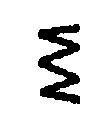

Results:
NCC mode:
1. :10/y scores: 1.0
2. :28/w scores: 0.786289635204
3. :25/b scores: 0.773113078837
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfy
Processed: 619/715
Processing:


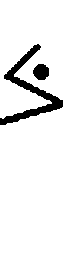

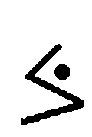

Results:
NCC mode:
1. :10/b scores: 1.0
2. :25/t scores: 0.901555759251
3. :6/j scores: 0.896401134505
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfyb
Processed: 620/715
Processing:


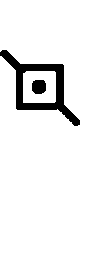

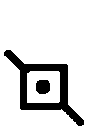

Results:
NCC mode:
1. :10/m scores: 1.0
2. :8/j scores: 0.921678206171
3. :29/p scores: 0.907847661875
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybm
Processed: 621/715
Processing:


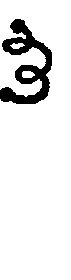

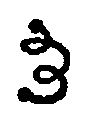

Results:
NCC mode:
1. :10/u scores: 0.998174142372
2. :26/r scores: 0.842533042046
3. :26/h scores: 0.835353827607
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmu
Processed: 622/715
Processing:


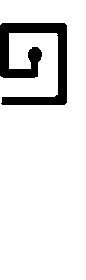

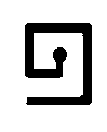

Results:
NCC mode:
1. :10/v scores: 1.0
2. :12/f scores: 0.914047843413
3. :16/u scores: 0.900936746969
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuv
Processed: 623/715
Processing:


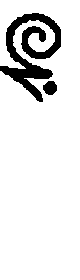

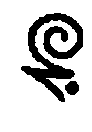

Results:
NCC mode:
1. :10/o scores: 0.997599610083
2. :25/w scores: 0.863434517706
3. :25/d scores: 0.851317414707
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvo
Processed: 624/715
Processing:


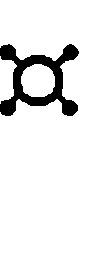

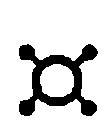

Results:
NCC mode:
1. :10/d scores: 1.0
2. :8/j scores: 0.899640536076
3. :10/m scores: 0.895343748554
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvod
Processed: 625/715
Processing:


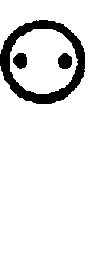

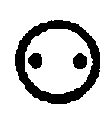

Results:
NCC mode:
1. :10/n scores: 1.0
2. :12/o scores: 0.977313402314
3. :12/h scores: 0.976792215381
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodn
Processed: 626/715
Processing:


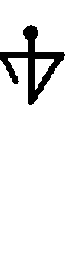

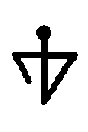

Results:
NCC mode:
1. :10/w scores: 0.998554538835
2. :10/s scores: 0.930739394727
3. :29/t scores: 0.926556013786
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnw
Processed: 627/715
Processing:


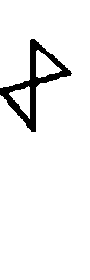

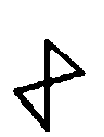

Results:
NCC mode:
1. :10/c scores: 0.999330962314
2. :29/h scores: 0.934067442425
3. :25/c scores: 0.926285202138
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwc
Processed: 628/715
Processing:


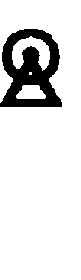

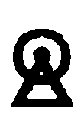

Results:
NCC mode:
1. :10/r scores: 1.0
2. :20/j scores: 0.783689903741
3. :29/g scores: 0.769037555057
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcr
Processed: 629/715
Processing:


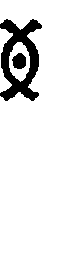

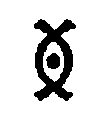

Results:
NCC mode:
1. :10/s scores: 1.0
2. :12/l scores: 0.779633463687
3. :25/r scores: 0.772441783094
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrs
Processed: 630/715
Processing:


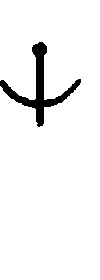

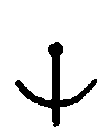

Results:
NCC mode:
1. :10/a scores: 0.999361623939
2. :10/a scores: 0.968407435535
3. :28/u scores: 0.947496654126
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsa
Processed: 631/715
Processing:


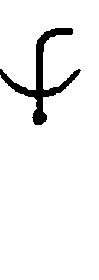

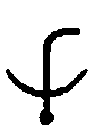

Results:
NCC mode:
1. :10/h scores: 0.999484757066
2. :10/a scores: 0.969467318276
3. :28/u scores: 0.944684417618
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsah
Processed: 632/715
Processing:


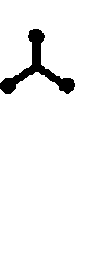

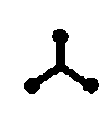

Results:
NCC mode:
1. :10/t scores: 1.0
2. :29/g scores: 0.96557504855
3. :27/n scores: 0.949451786039
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaht
Processed: 633/715
Processing:


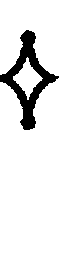

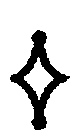

Results:
NCC mode:
1. :10/e scores: 0.998728619686
2. :27/i scores: 0.913221990888
3. :28/u scores: 0.906358113878
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahte
Processed: 634/715
Processing:


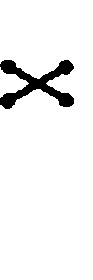

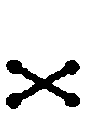

Results:
NCC mode:
1. :10/j scores: 1.0
2. :16/j scores: 0.956358182415
3. :7/m scores: 0.954969525117
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtej
Processed: 635/715
Processing:


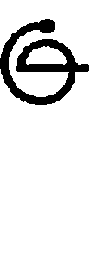

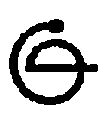

Results:
NCC mode:
1. :10/x scores: 1.0
2. :2/l scores: 0.903485923994
3. :28/v scores: 0.900057464488
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejx
Processed: 636/715
Processing:


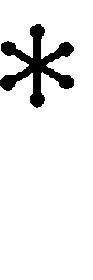

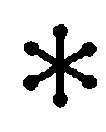

Results:
NCC mode:
1. :10/q scores: 1.0
2. :29/e scores: 0.962225988525
3. :18/a scores: 0.947262343082
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxq
Processed: 637/715
Processing:


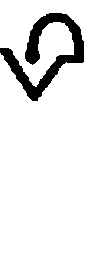

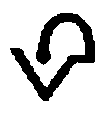

Results:
NCC mode:
1. :10/p scores: 0.998898347403
2. :10/h scores: 0.896120409314
3. :28/u scores: 0.8889113462
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqp
Processed: 638/715
Processing:


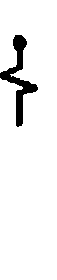

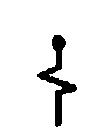

Results:
NCC mode:
1. :10/g scores: 0.993005172831
2. :29/d scores: 0.947119665214
3. :27/i scores: 0.917657809122
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 639/715
Processing:


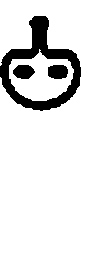

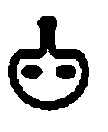

Results:
NCC mode:
1. :10/z scores: 1.0
2. :2/l scores: 0.890865549877
3. :18/w scores: 0.881408977833
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgz
Processed: 640/715
Processing:


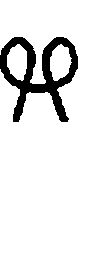

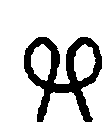

Results:
NCC mode:
1. :10/l scores: 1.0
2. :24/f scores: 0.877383001196
3. :24/g scores: 0.877341802001
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 641/715
Processing:


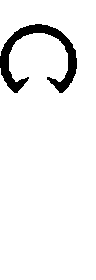

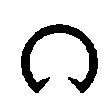

Results:
NCC mode:
1. :12/i scores: 1.0
2. :19/v scores: 0.955589755233
3. :12/o scores: 0.937982437642
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzli
Processed: 642/715
Processing:


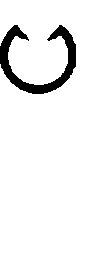

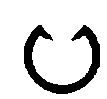

Results:
NCC mode:
1. :12/k scores: 1.0
2. :19/v scores: 0.941401974844
3. :19/r scores: 0.930780565552
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlik
Processed: 643/715
Processing:


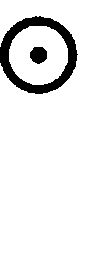

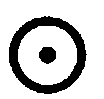

Results:
NCC mode:
1. :12/f scores: 1.0
2. :19/v scores: 0.962322329932
3. :12/o scores: 0.960668775539
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikf
Processed: 644/715
Processing:


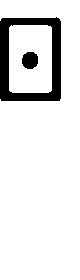

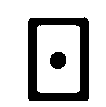

Results:
NCC mode:
1. :12/y scores: 1.0
2. :12/c scores: 0.967340756453
3. :12/c scores: 0.95757404644
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfy
Processed: 645/715
Processing:


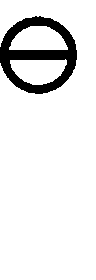

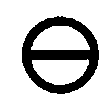

Results:
NCC mode:
1. :12/b scores: 1.0
2. :19/h scores: 0.968098411852
3. :10/n scores: 0.957321351059
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfyb
Processed: 646/715
Processing:


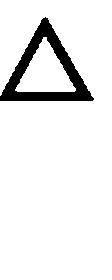

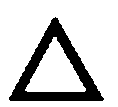

Results:
NCC mode:
1. :12/m scores: 0.999180039514
2. :27/y scores: 0.944854625114
3. :20/y scores: 0.923586316171
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybm
Processed: 647/715
Processing:


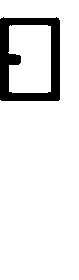

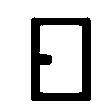

Results:
NCC mode:
1. :12/v scores: 1.0
2. :12/c scores: 0.983506709765
3. :12/t scores: 0.964461286379
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmv
Processed: 648/715
Processing:


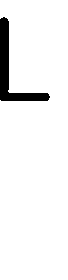

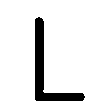

Results:
NCC mode:
1. :12/o scores: 1.0
2. :16/z scores: 0.975183529851
3. :1/g scores: 0.971667452478
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvo
Processed: 649/715
Processing:


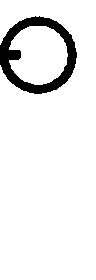

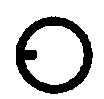

Results:
NCC mode:
1. :12/d scores: 1.0
2. :19/v scores: 0.978467240116
3. :12/t scores: 0.977453893184
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvod
Processed: 650/715
Processing:


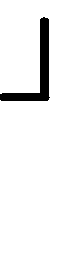

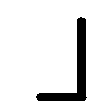

Results:
NCC mode:
1. :12/n scores: 0.999872298047
2. :20/l scores: 0.966479683257
3. :16/e scores: 0.958147011846
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodn
Processed: 651/715
Processing:


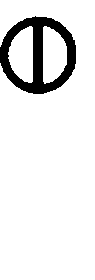

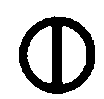

Results:
NCC mode:
1. :12/c scores: 1.0
2. :27/l scores: 0.97636840629
3. :19/q scores: 0.958909722721
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodnc
Processed: 652/715
Processing:


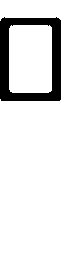

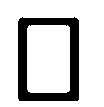

Results:
NCC mode:
1. :12/r scores: 1.0
2. :12/v scores: 0.985862862958
3. :12/t scores: 0.982221607791
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncr
Processed: 653/715
Processing:


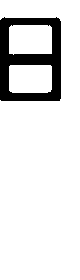

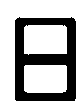

Results:
NCC mode:
1. :12/s scores: 1.0
2. :12/y scores: 0.95757404644
3. :12/m scores: 0.953640172624
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrs
Processed: 654/715
Processing:


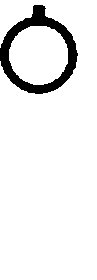

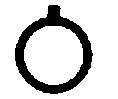

Results:
NCC mode:
1. :12/a scores: 1.0
2. :2/l scores: 0.957620911994
3. :13/z scores: 0.926345805107
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsa
Processed: 655/715
Processing:


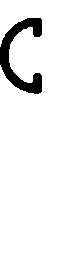

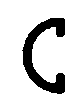

Results:
NCC mode:
1. :12/h scores: 0.996250394759
2. :28/w scores: 0.860571307442
3. :14/t scores: 0.85505786642
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsah
Processed: 656/715
Processing:


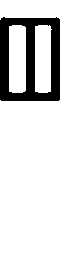

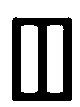

Results:
NCC mode:
1. :12/t scores: 1.0
2. :12/y scores: 0.914024756152
3. :12/c scores: 0.897430241378
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsaht
Processed: 657/715
Processing:


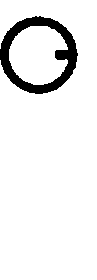

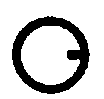

Results:
NCC mode:
1. :12/e scores: 1.0
2. :12/d scores: 0.977453893184
3. :10/n scores: 0.974443518634
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahte
Processed: 658/715
Processing:


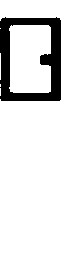

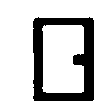

Results:
NCC mode:
1. :12/x scores: 1.0
2. :12/r scores: 0.982221607791
3. :12/v scores: 0.968986244362
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtex
Processed: 659/715
Processing:


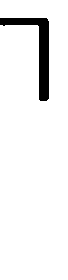

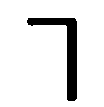

Results:
NCC mode:
1. :12/q scores: 0.999919752316
2. :1/h scores: 0.956248423682
3. :16/h scores: 0.949048033604
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexq
Processed: 660/715
Processing:


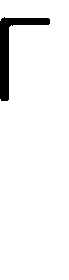

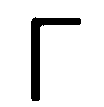

Results:
NCC mode:
1. :12/p scores: 1.0
2. :16/k scores: 0.975154151396
3. :1/w scores: 0.972800791854
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqp
Processed: 661/715
Processing:


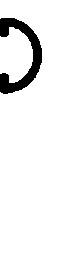

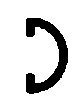

Results:
NCC mode:
1. :12/g scores: 1.0
2. :28/l scores: 0.854484386698
3. :6/z scores: 0.849675983852
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpg
Processed: 662/715
Processing:


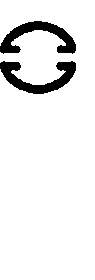

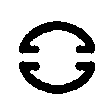

Results:
NCC mode:
1. :12/l scores: 1.0
2. :19/v scores: 0.956422284629
3. :12/d scores: 0.950034764355
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpgl
Processed: 663/715
Processing:


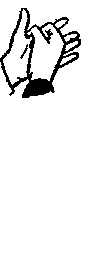

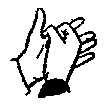

Results:
NCC mode:
1. :25/i scores: 0.985516798052
2. :6/z scores: 0.956890851269
3. :6/b scores: 0.956187400362
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpgli
Processed: 664/715
Processing:


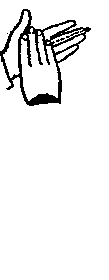

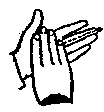

Results:
NCC mode:
1. :25/k scores: 0.998541483526
2. :25/f scores: 0.976473587406
3. :25/m scores: 0.966910914846
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglik
Processed: 665/715
Processing:


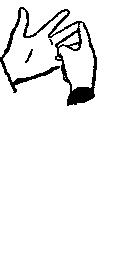

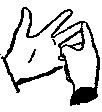

Results:
NCC mode:
1. :25/f scores: 0.998637506689
2. :25/v scores: 0.981128456617
3. :25/t scores: 0.976472990028
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikf
Processed: 666/715
Processing:


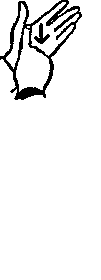

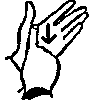

Results:
NCC mode:
1. :25/y scores: 0.998905290579
2. :25/k scores: 0.968680785869
3. :25/o scores: 0.965071768612
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfy
Processed: 667/715
Processing:


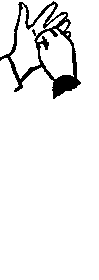

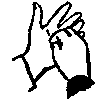

Results:
NCC mode:
1. :25/b scores: 0.99844251289
2. :25/a scores: 0.971016972139
3. :25/o scores: 0.9694675212
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfyb
Processed: 668/715
Processing:


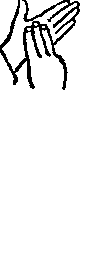

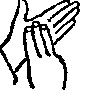

Results:
NCC mode:
1. :25/m scores: 1.0
2. :25/d scores: 0.98613201803
3. :25/u scores: 0.979155449856
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybm
Processed: 669/715
Processing:


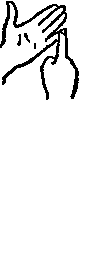

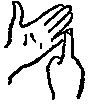

Results:
NCC mode:
1. :25/u scores: 0.998846102764
2. :25/r scores: 0.973405534323
3. :6/v scores: 0.966882891222
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmu
Processed: 670/715
Processing:


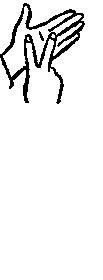

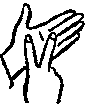

Results:
NCC mode:
1. :25/v scores: 1.0
2. :25/d scores: 0.984413065497
3. :25/m scores: 0.979155449856
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuv
Processed: 671/715
Processing:


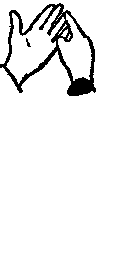

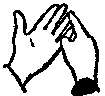

Results:
NCC mode:
1. :25/o scores: 0.999724630411
2. :25/f scores: 0.980548811845
3. :25/s scores: 0.974476178131
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvo
Processed: 672/715
Processing:


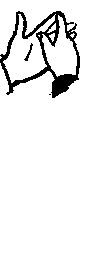

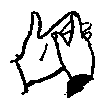

Results:
NCC mode:
1. :25/d scores: 0.990508372219
2. :25/q scores: 0.973755437392
3. :25/t scores: 0.973533999718
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvod
Processed: 673/715
Processing:


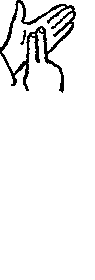

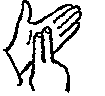

Results:
NCC mode:
1. :25/n scores: 0.99675767926
2. :25/m scores: 0.988794843934
3. :25/u scores: 0.984516581112
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodn
Processed: 674/715
Processing:


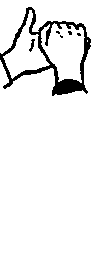

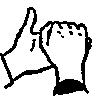

Results:
NCC mode:
1. :25/w scores: 0.999774282395
2. :25/p scores: 0.977060021816
3. :25/f scores: 0.965261914586
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnw
Processed: 675/715
Processing:


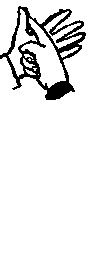

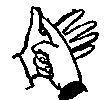

Results:
NCC mode:
1. :25/c scores: 0.99961911089
2. :25/p scores: 0.964484247757
3. :25/j scores: 0.960403755847
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwc
Processed: 676/715
Processing:


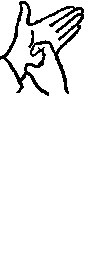

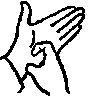

Results:
NCC mode:
1. :25/r scores: 0.999678450579
2. :25/n scores: 0.985612646211
3. :25/a scores: 0.980520269779
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcr
Processed: 677/715
Processing:


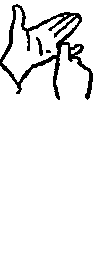

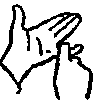

Results:
NCC mode:
1. :25/s scores: 1.0
2. :25/u scores: 0.981383368019
3. :6/j scores: 0.96944105085
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrs
Processed: 678/715
Processing:


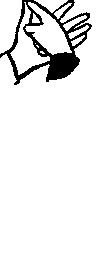

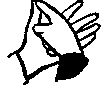

Results:
NCC mode:
1. :25/a scores: 0.998719393688
2. :6/w scores: 0.947853572336
3. :6/e scores: 0.945284963876
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsa
Processed: 679/715
Processing:


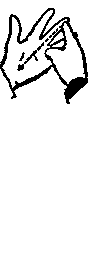

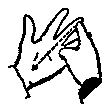

Results:
NCC mode:
1. :25/h scores: 0.991942558599
2. :25/f scores: 0.972881028845
3. :25/t scores: 0.972652643536
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsah
Processed: 680/715
Processing:


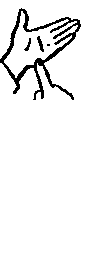

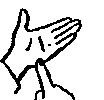

Results:
NCC mode:
1. :25/t scores: 0.999616232621
2. :25/r scores: 0.978123798557
3. :25/v scores: 0.977871111935
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsaht
Processed: 681/715
Processing:


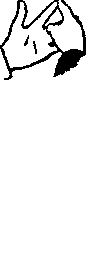

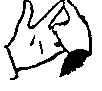

Results:
NCC mode:
1. :25/e scores: 0.998963777841
2. :25/d scores: 0.970827035874
3. :25/x scores: 0.968610408507
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahte
Processed: 682/715
Processing:


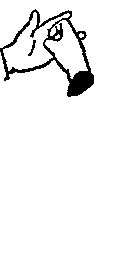

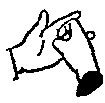

Results:
NCC mode:
1. :25/j scores: 0.998683520687
2. :25/f scores: 0.979460658367
3. :25/a scores: 0.97381207364
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtej
Processed: 683/715
Processing:


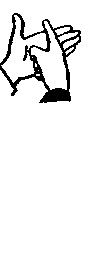

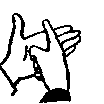

Results:
NCC mode:
1. :25/x scores: 1.0
2. :25/p scores: 0.97106887436
3. :25/w scores: 0.960204214978
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejx
Processed: 684/715
Processing:


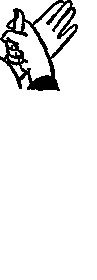

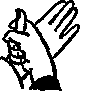

Results:
NCC mode:
1. :25/q scores: 0.997783187487
2. :25/k scores: 0.951055661166
3. :25/f scores: 0.944294728835
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxq
Processed: 685/715
Processing:


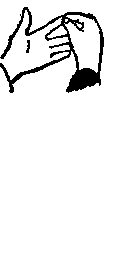

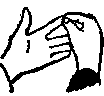

Results:
NCC mode:
1. :25/p scores: 1.0
2. :25/f scores: 0.977339271345
3. :25/a scores: 0.974773371384
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqp
Processed: 686/715
Processing:


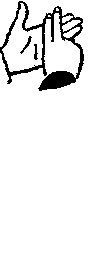

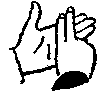

Results:
NCC mode:
1. :25/g scores: 0.996065030667
2. :25/x scores: 0.97453793587
3. :25/w scores: 0.96933927185
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpg
Processed: 687/715
Processing:


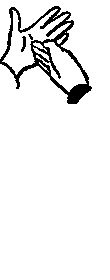

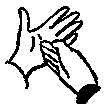

Results:
NCC mode:
1. :25/z scores: 0.996212995883
2. :25/f scores: 0.9661621312
3. :25/a scores: 0.963734053624
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgz
Processed: 688/715
Processing:


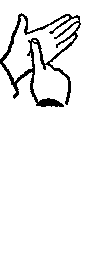

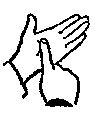

Results:
NCC mode:
1. :25/l scores: 0.989442240301
2. :25/m scores: 0.976781256702
3. :25/c scores: 0.972235254696
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzl
Processed: 689/715
Processing:


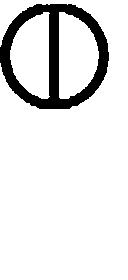

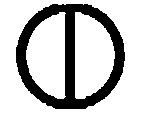

Results:
NCC mode:
1. :19/i scores: 1.0
2. :12/c scores: 0.978652198412
3. :19/t scores: 0.977213121809
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzli
Processed: 690/715
Processing:


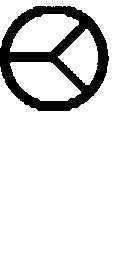

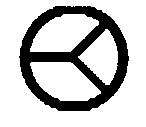

Results:
NCC mode:
1. :19/k scores: 0.999239560463
2. :19/f scores: 0.956159861582
3. :19/u scores: 0.946395368984
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlik
Processed: 691/715
Processing:


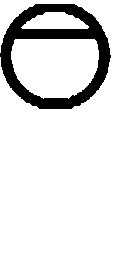

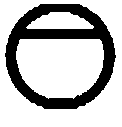

Results:
NCC mode:
1. :19/f scores: 1.0
2. :19/v scores: 0.964972123699
3. :19/m scores: 0.964792298411
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikf
Processed: 692/715
Processing:


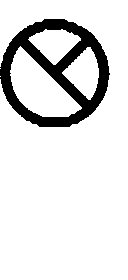

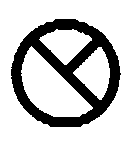

Results:
NCC mode:
1. :19/y scores: 1.0
2. :19/d scores: 0.980269338504
3. :19/e scores: 0.980027515176
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfy
Processed: 693/715
Processing:


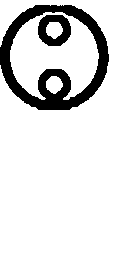

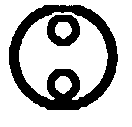

Results:
NCC mode:
1. :19/b scores: 1.0
2. :19/i scores: 0.975235950421
3. :19/r scores: 0.974501961921
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfyb
Processed: 694/715
Processing:


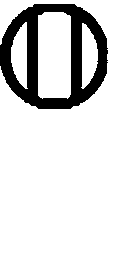

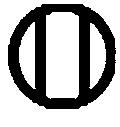

Results:
NCC mode:
1. :19/m scores: 1.0
2. :19/v scores: 0.93685947945
3. :10/n scores: 0.934838127008
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybm
Processed: 695/715
Processing:


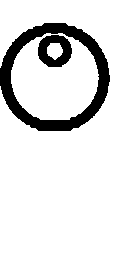

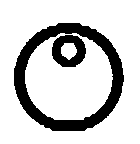

Results:
NCC mode:
1. :19/u scores: 1.0
2. :19/v scores: 0.9761561135
3. :19/b scores: 0.97022001006
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmu
Processed: 696/715
Processing:


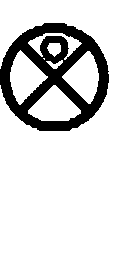

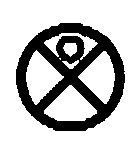

Results:
NCC mode:
1. :19/v scores: 1.0
2. :19/j scores: 0.98136078422
3. :19/y scores: 0.965115876282
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuv
Processed: 697/715
Processing:


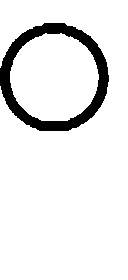

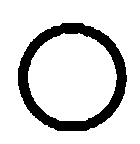

Results:
NCC mode:
1. :19/o scores: 1.0
2. :12/d scores: 0.979193380957
3. :19/m scores: 0.9761561135
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvo
Processed: 698/715
Processing:


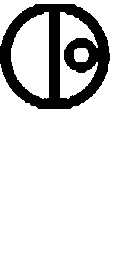

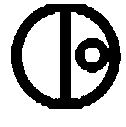

Results:
NCC mode:
1. :19/d scores: 1.0
2. :19/p scores: 0.9742421368
3. :19/c scores: 0.960196955922
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvod
Processed: 699/715
Processing:


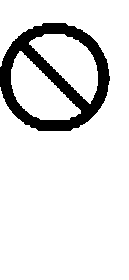

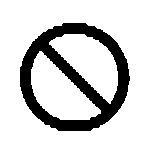

Results:
NCC mode:
1. :19/n scores: 1.0
2. :19/y scores: 0.980269338504
3. :19/e scores: 0.961389209844
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodn
Processed: 700/715
Processing:


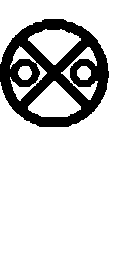

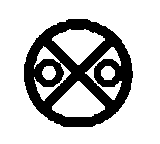

Results:
NCC mode:
1. :19/w scores: 1.0
2. :19/j scores: 0.958151250636
3. :19/y scores: 0.94172462837
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnw
Processed: 701/715
Processing:


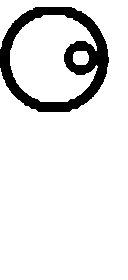

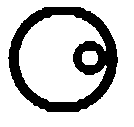

Results:
NCC mode:
1. :19/c scores: 0.999335716979
2. :19/o scores: 0.965176003391
3. :19/o scores: 0.955105613387
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwc
Processed: 702/715
Processing:


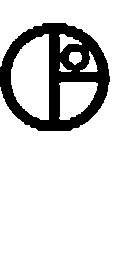

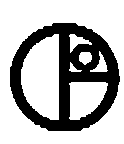

Results:
NCC mode:
1. :19/r scores: 1.0
2. :19/q scores: 0.984677734384
3. :19/q scores: 0.972700314273
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcr
Processed: 703/715
Processing:


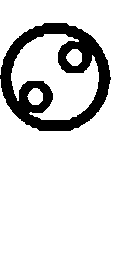

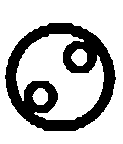

Results:
NCC mode:
1. :19/s scores: 1.0
2. :19/o scores: 0.952807863884
3. :19/p scores: 0.948693255009
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrs
Processed: 704/715
Processing:


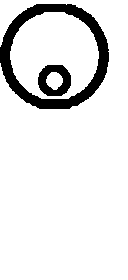

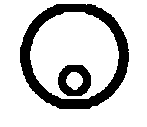

Results:
NCC mode:
1. :19/a scores: 1.0
2. :19/b scores: 0.974501961921
3. :19/v scores: 0.972410283453
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsa
Processed: 705/715
Processing:


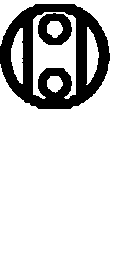

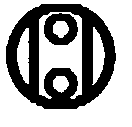

Results:
NCC mode:
1. :19/h scores: 1.0
2. :19/m scores: 0.92740041691
3. :19/b scores: 0.923324697145
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsah
Processed: 706/715
Processing:


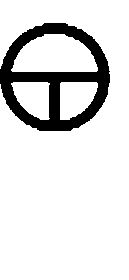

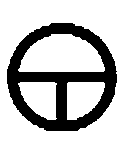

Results:
NCC mode:
1. :19/t scores: 1.0
2. :12/b scores: 0.969527855998
3. :19/q scores: 0.952275473021
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaht
Processed: 707/715
Processing:


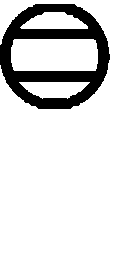

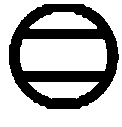

Results:
NCC mode:
1. :19/e scores: 1.0
2. :19/f scores: 0.961736713287
3. :19/v scores: 0.932503132182
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahte
Processed: 708/715
Processing:


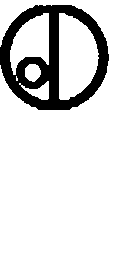

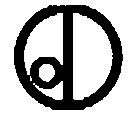

Results:
NCC mode:
1. :19/j scores: 1.0
2. :19/i scores: 0.977213121809
3. :12/c scores: 0.957322171549
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtej
Processed: 709/715
Processing:


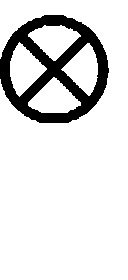

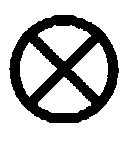

Results:
NCC mode:
1. :19/x scores: 0.999052266393
2. :19/v scores: 0.980840210375
3. :19/y scores: 0.980045751201
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejx
Processed: 710/715
Processing:


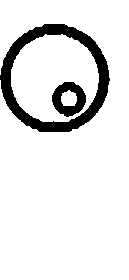

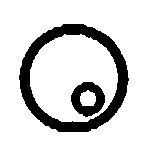

Results:
NCC mode:
1. :19/q scores: 1.0
2. :19/o scores: 0.97531254488
3. :19/s scores: 0.969813530222
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxq
Processed: 711/715
Processing:


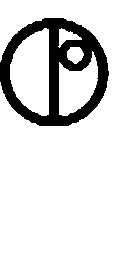

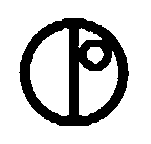

Results:
NCC mode:
1. :19/p scores: 0.998926428157
2. :19/r scores: 0.985274890696
3. :19/i scores: 0.969853793049
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqp
Processed: 712/715
Processing:


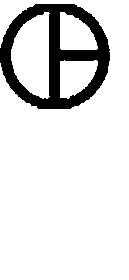

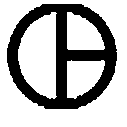

Results:
NCC mode:
1. :19/g scores: 1.0
2. :19/i scores: 0.975435696093
3. :19/o scores: 0.9742421368
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpg
Processed: 713/715
Processing:


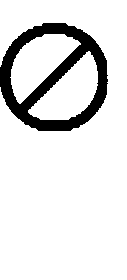

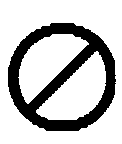

Results:
NCC mode:
1. :19/z scores: 1.0
2. :19/x scores: 0.955195187575
3. :19/o scores: 0.954115284243
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgz
Processed: 714/715
Processing:


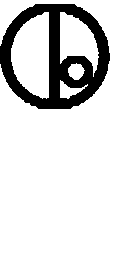

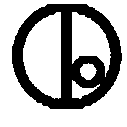

Results:
NCC mode:
1. :19/l scores: 1.0
2. :19/i scores: 0.971278042699
3. :19/p scores: 0.966070468738
Result:ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsaettejxqpgzlikfybmuvodnwcrsahtejxqpgdzlikfybmuvodnwcrsahtejxqpgzlikfqmbmuvzdnwcrsahtejxqpgzlicfybmuodnwcrsahteipgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfbmuvodnchrsahtejpgzl0i0k0f0y0b0m0u0v0o0d0n0w0c0r0s0a0h0t0e0j0x0q0p0g0z0lifybmuvodnwcrsahtepgzlikfybmuvdnwcrsahtejqpgzlikfybmuvodnwcrsahtejxqpgzlkfybvodwchjxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzlikfybmvodncrsahtexqpglikfybmuvodnwcrsahtejxqpgzlikfybmuvodnwcrsahtejxqpgzl
Processed: 715/715
Message: ikfybmuvodnwcrsahtejxqpgzlikfybmuvodnjtcchsahtejxqpgzlybmdrhepguvikfybmuvodnwcrsahtexqpgzlikfybmuvodnwcrsahtejxqpgzli

In [18]:
main()